(prior_predictive)=
# Prior Predictive Modeling

This guide provides an introduction to prior predictive modeling using PyMC (and PyMC Marketing) and the {class}`Prior <pymc_marketing.prior.Prior>` class from PyMC-Marketing.  We start by looking into a simpler example and then we will see how to apply to real case scenarios with marketing mix models in PyMC-Marketing.


Before diving into the technical details, let's understand why priors are crucial in Bayesian analysis and their practical importance in industry applications.

## Understanding Bayesian Inference

Bayesian inference is based on Bayes' theorem, which provides a formal way to update our beliefs about parameters $\theta$ (say, saturation or decay rate in a marketing mix models) given observed data $y$:

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)}$$

Where:
- $p(\theta|y)$ is the posterior probability (what we want to learn)
- $p(y|\theta)$ is the likelihood (how the data is generated)
- $p(\theta)$ is the prior probability (our initial beliefs)
- $p(y)$ is the evidence (a normalizing constant), which can be written as $p(y) = \displaystyle{ \int p(y|\theta)p(\theta)d\theta }$

The posterior distribution combines our prior knowledge with the observed data to give us updated beliefs about the parameters. In practice, we often work with the unnormalized posterior:

$$p(\theta|y) \propto p(y|\theta)p(\theta)$$

This is because the normalizing constant $p(y)$ is often intractable to compute directly.

### Why Priors Matter in Industry

In industry applications, priors serve several crucial purposes:

1. **Domain Knowledge Integration**:
   - Incorporating expert knowledge into models
   - Leveraging historical data from similar projects
   - Encoding business constraints and requirements

2. **Risk Management**:
   - Preventing unrealistic predictions
   - Ensuring stable model behavior
   - Managing uncertainty in decision-making

3. **Data Efficiency**:
   - Making models work with limited data
   - Faster convergence to reasonable solutions
   - Robust predictions in new scenarios

4. **Model Regularization**:
   - Preventing overfitting
   - Handling multicollinearity
   - Dealing with sparse data

### Common Prior Specification Scenarios

In marketing analytics, you'll often encounter these scenarios:

1. **Marketing Mix Models**:
   - Media channel effectiveness (typically positive)
   - Diminishing returns (shape constraints)
   - Lift tests calibration

2. **Customer Lifetime Value**:
   - Purchase rates (positive values)
   - Churn probabilities (between 0 and 1)
   - Monetary value distributions (positive, often log-normal)

3. **A/B Testing**:
   - Conversion rates (bounded between 0 and 1)
   - Lift measurements (centered around small effects)
   - Revenue impacts (potentially heavy-tailed)

A/B tests is a fascinating field where Bayesian methods can provide huge benefits. Still, omiting prior predictive analysis can lead to bad results as described in the great article ["The Bet Test: Spotting Problems in Bayesian A/B Test Analysis"](https://www.geteppo.com/blog/the-bet-test-problems-in-bayesian-ab-test-analysis) by Tyler Buffington.

## What is Prior Predictive Modeling?

Prior predictive modeling is a crucial step in Bayesian workflow that helps us validate our prior choices before seeing the actual data. The process involves:

1. **Specification**: 
   - Define prior distributions for model parameters
   - Encode domain knowledge and constraints
   - Document assumptions and choices

2. **Simulation**:
   - Sample parameters from prior distributions
   - Generate synthetic data using the model structure
   - Create multiple scenarios of possible outcomes

3. **Validation**:
   - Check if simulated data matches domain expertise
   - Verify that impossible scenarios are excluded
   - Ensure reasonable coverage of possible outcomes

### Benefits in Practice

1. **Early Problem Detection**:
   - Identify unrealistic assumptions
   - Catch numerical issues before model fitting
   - Validate model structure

2. **Stakeholder Communication**:
   - Visualize model implications
   - Justify modeling choices
   - Set realistic expectations

3. **Model Development**:
   - Iterate on prior choices efficiently
   - Compare alternative specifications
   - Document model evolution

4. **Risk Assessment**:
   - Understand model limitations
   - Identify edge cases
   - Plan for failure modes

The prior predictive distribution $p(y)$ represents our beliefs about the data before we observe it. Mathematically, it's the distribution of the data marginalized over the prior:

$$p(y) = \int p(y|\theta)p(\theta)d\theta$$

In practice, we can sample from this distribution by:
1. Drawing parameters from the prior: $\theta^{(s)} \sim p(\theta)$
2. Generating data from the likelihood: $y^{(s)} \sim p(y|\theta^{(s)})$

This process helps us validate our model in several ways:

1. **Parameter Space Coverage**: 
   The samples $\{\theta^{(s)}\}_{s=1}^S$ show us what parameter values we consider plausible

2. **Data Space Coverage**: 
   The samples $\{y^{(s)}\}_{s=1}^S$ show us what data our model can generate

3. **Model Sensitivity**: 
   The relationship between $\theta^{(s)}$ and $y^{(s)}$ shows how parameters influence predictions

Let's explore these concepts through practical examples using the {class}`Prior <pymc_marketing.prior.Prior>` class from PyMC-Marketing.


## Prepare Notebook

In [1]:
from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns
from numpy.typing import NDArray

from pymc_marketing.hsgp_kwargs import HSGPKwargs
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

seed: int = sum(map(ord, "prior"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Simple Example: Normal Distribution

Let's start with a simple example using a normal distribution. We'll:
1. Generate a synthetic dataset
2. Study the observed distribution
3. Set a prior for the mean and standard deviation
4. Sample from its prior predictive distribution


First we generate a synthetic dataset from a normal distribution with mean one and standard deviation two.

In [2]:
true_mu: float = 1.0
true_sigma: float = 2.0
n_observations: int = 200

data: NDArray = rng.normal(loc=true_mu, scale=true_sigma, size=n_observations)

sample_mean: float = data.mean()
sample_std: float = data.std()

Let's visualize the observed data.



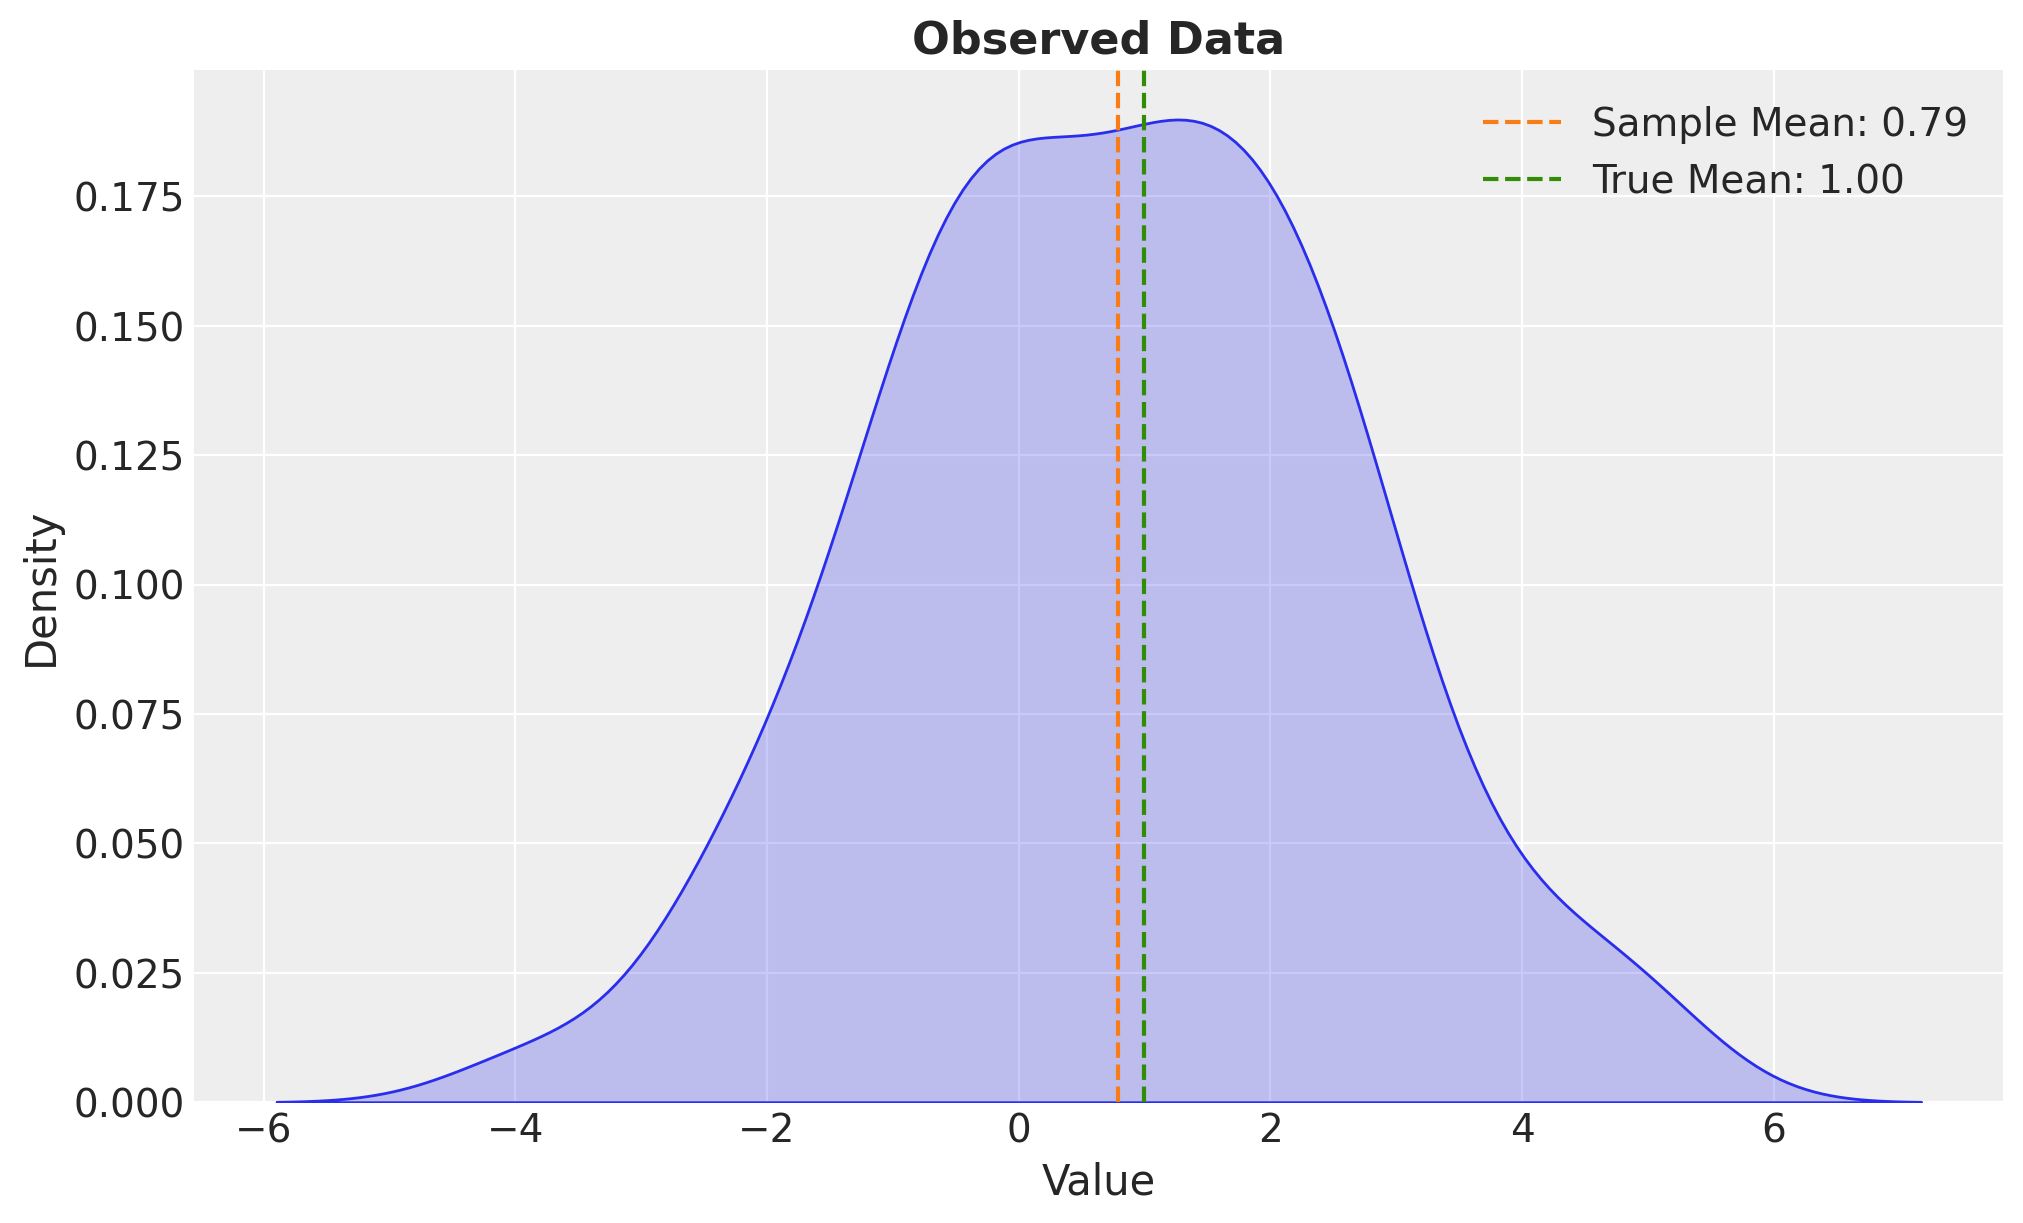

In [3]:
fig, ax = plt.subplots()
sns.kdeplot(data, fill=True, color="C0", ax=ax)
ax.axvline(
    sample_mean, color="C1", linestyle="--", label=f"Sample Mean: {sample_mean:.2f}"
)
ax.axvline(true_mu, color="C2", linestyle="--", label=f"True Mean: {true_mu:.2f}")
ax.legend()
ax.set(title="Observed Data", xlabel="Value", ylabel="Density")
ax.set_title("Observed Data", fontsize=16, fontweight="bold");

We assume we do not know the true mean and standard deviation of the data (as in almost all cases). Our idea is to fit a bayesian model to try to recover the true parameters.

We consider the parametric form of the data:

$$
y \sim \text{Normal}(\mu, \sigma)
$$

What could be sensible priors for the mean and standard deviation? This is where the prior predictive modeling comes in. 

### Fixed Mean and Standard Deviation

First, we consider the simple case where we set fixed values for the mean and standard deviation and we sample from the prior predictive distribution (the normal distribution). 

Consider the following values for the mean and standard deviation:

In [4]:
mu_1, mu_2 = -2, 0
sigma_1, sigma_2 = 0.5, 3

Given these values, we can simply sample from a normal distribution with these parameters and compare it with the observed data.


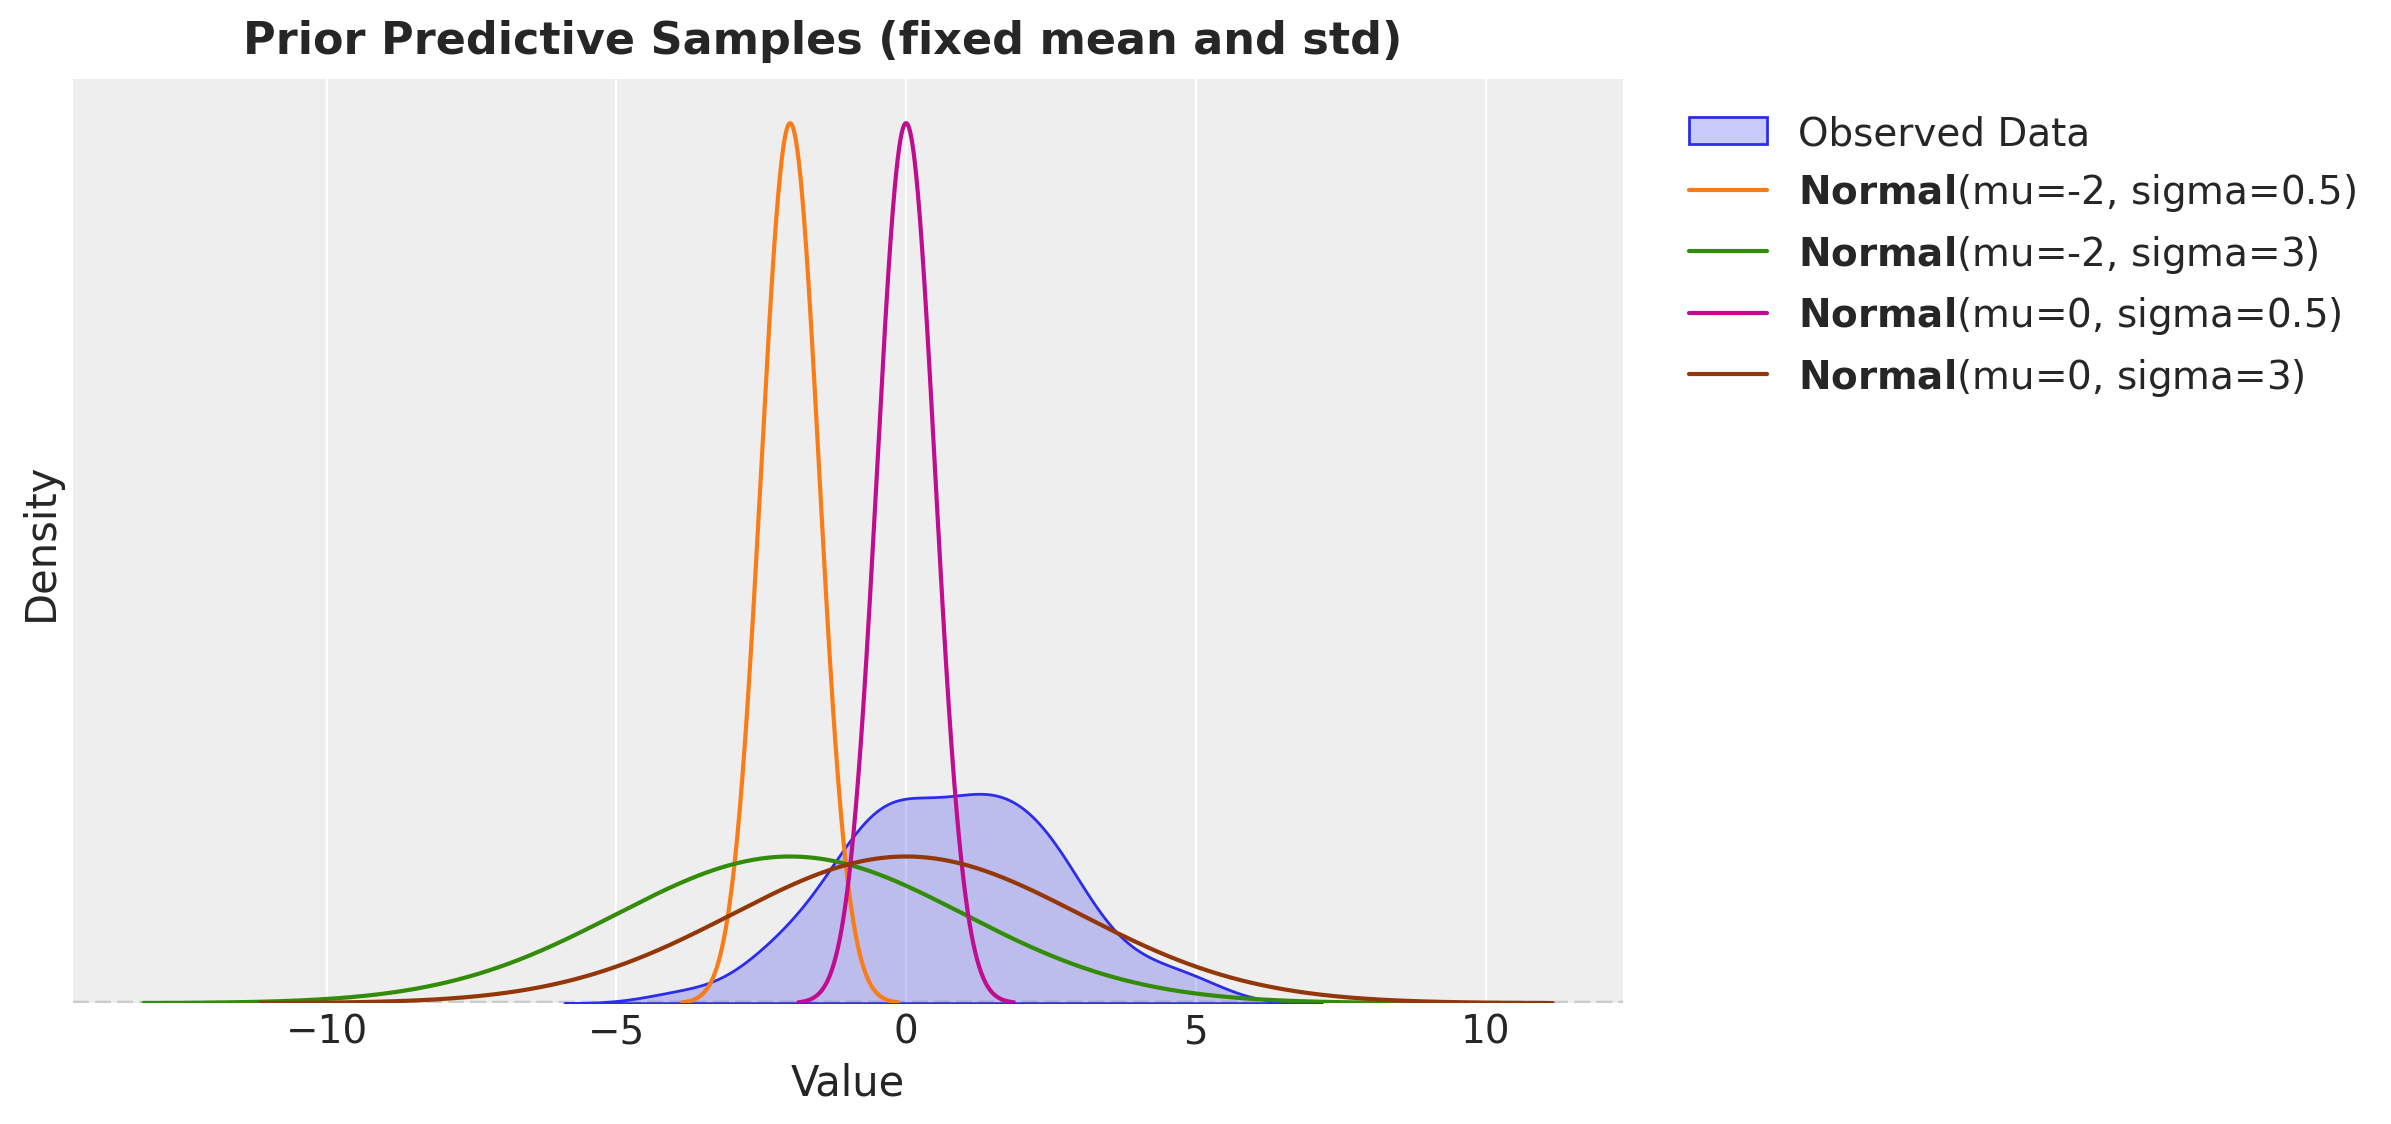

In [5]:
fig, ax = plt.subplots()

sns.kdeplot(data, fill=True, color="C0", label="Observed Data", ax=ax)
for i, (mu, sigma) in enumerate(product((mu_1, mu_2), (sigma_1, sigma_2))):
    normal_prior = pz.Normal(mu=mu, sigma=sigma)
    normal_prior.plot_pdf(color=f"C{i + 1}", legend="legend", ax=ax)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
ax.set(xlabel="Value", ylabel="Density")
fig.suptitle(
    "Prior Predictive Samples (fixed mean and std)",
    fontsize=16,
    fontweight="bold",
    y=0.93,
);

Looking at the plots above, we can see how different combinations of mean (μ) and standard deviation (σ) parameters affect the fit to our observed data:

- $\mu=-2, \sigma=0.5$: The distribution is too narrow and centered too far to the left
- $\mu=-2, \sigma=3$: Better spread but still centered too far left
- $\mu=0, \sigma=0.5$: Better centered but too narrow
- $\mu=0, \sigma=3$: This appears to be the best fit, with both good center and spread matching the observed data

This visual comparison helps us understand that priors centered around $\mu=0$ with a wider standard deviation ($\sigma=3$) may be more appropriate for our data.


### Prior Predictive Sampling

Now we can take a step forward and instead of fixing the mean and standard deviation, we can set a prior for them. To start, we set the following priors for the mean and standard deviation:

- $\mu \sim \text{Normal}(0, 2)$
- $\sigma \sim \text{Exponential}(1/3)$

We first sample from the model parameters.

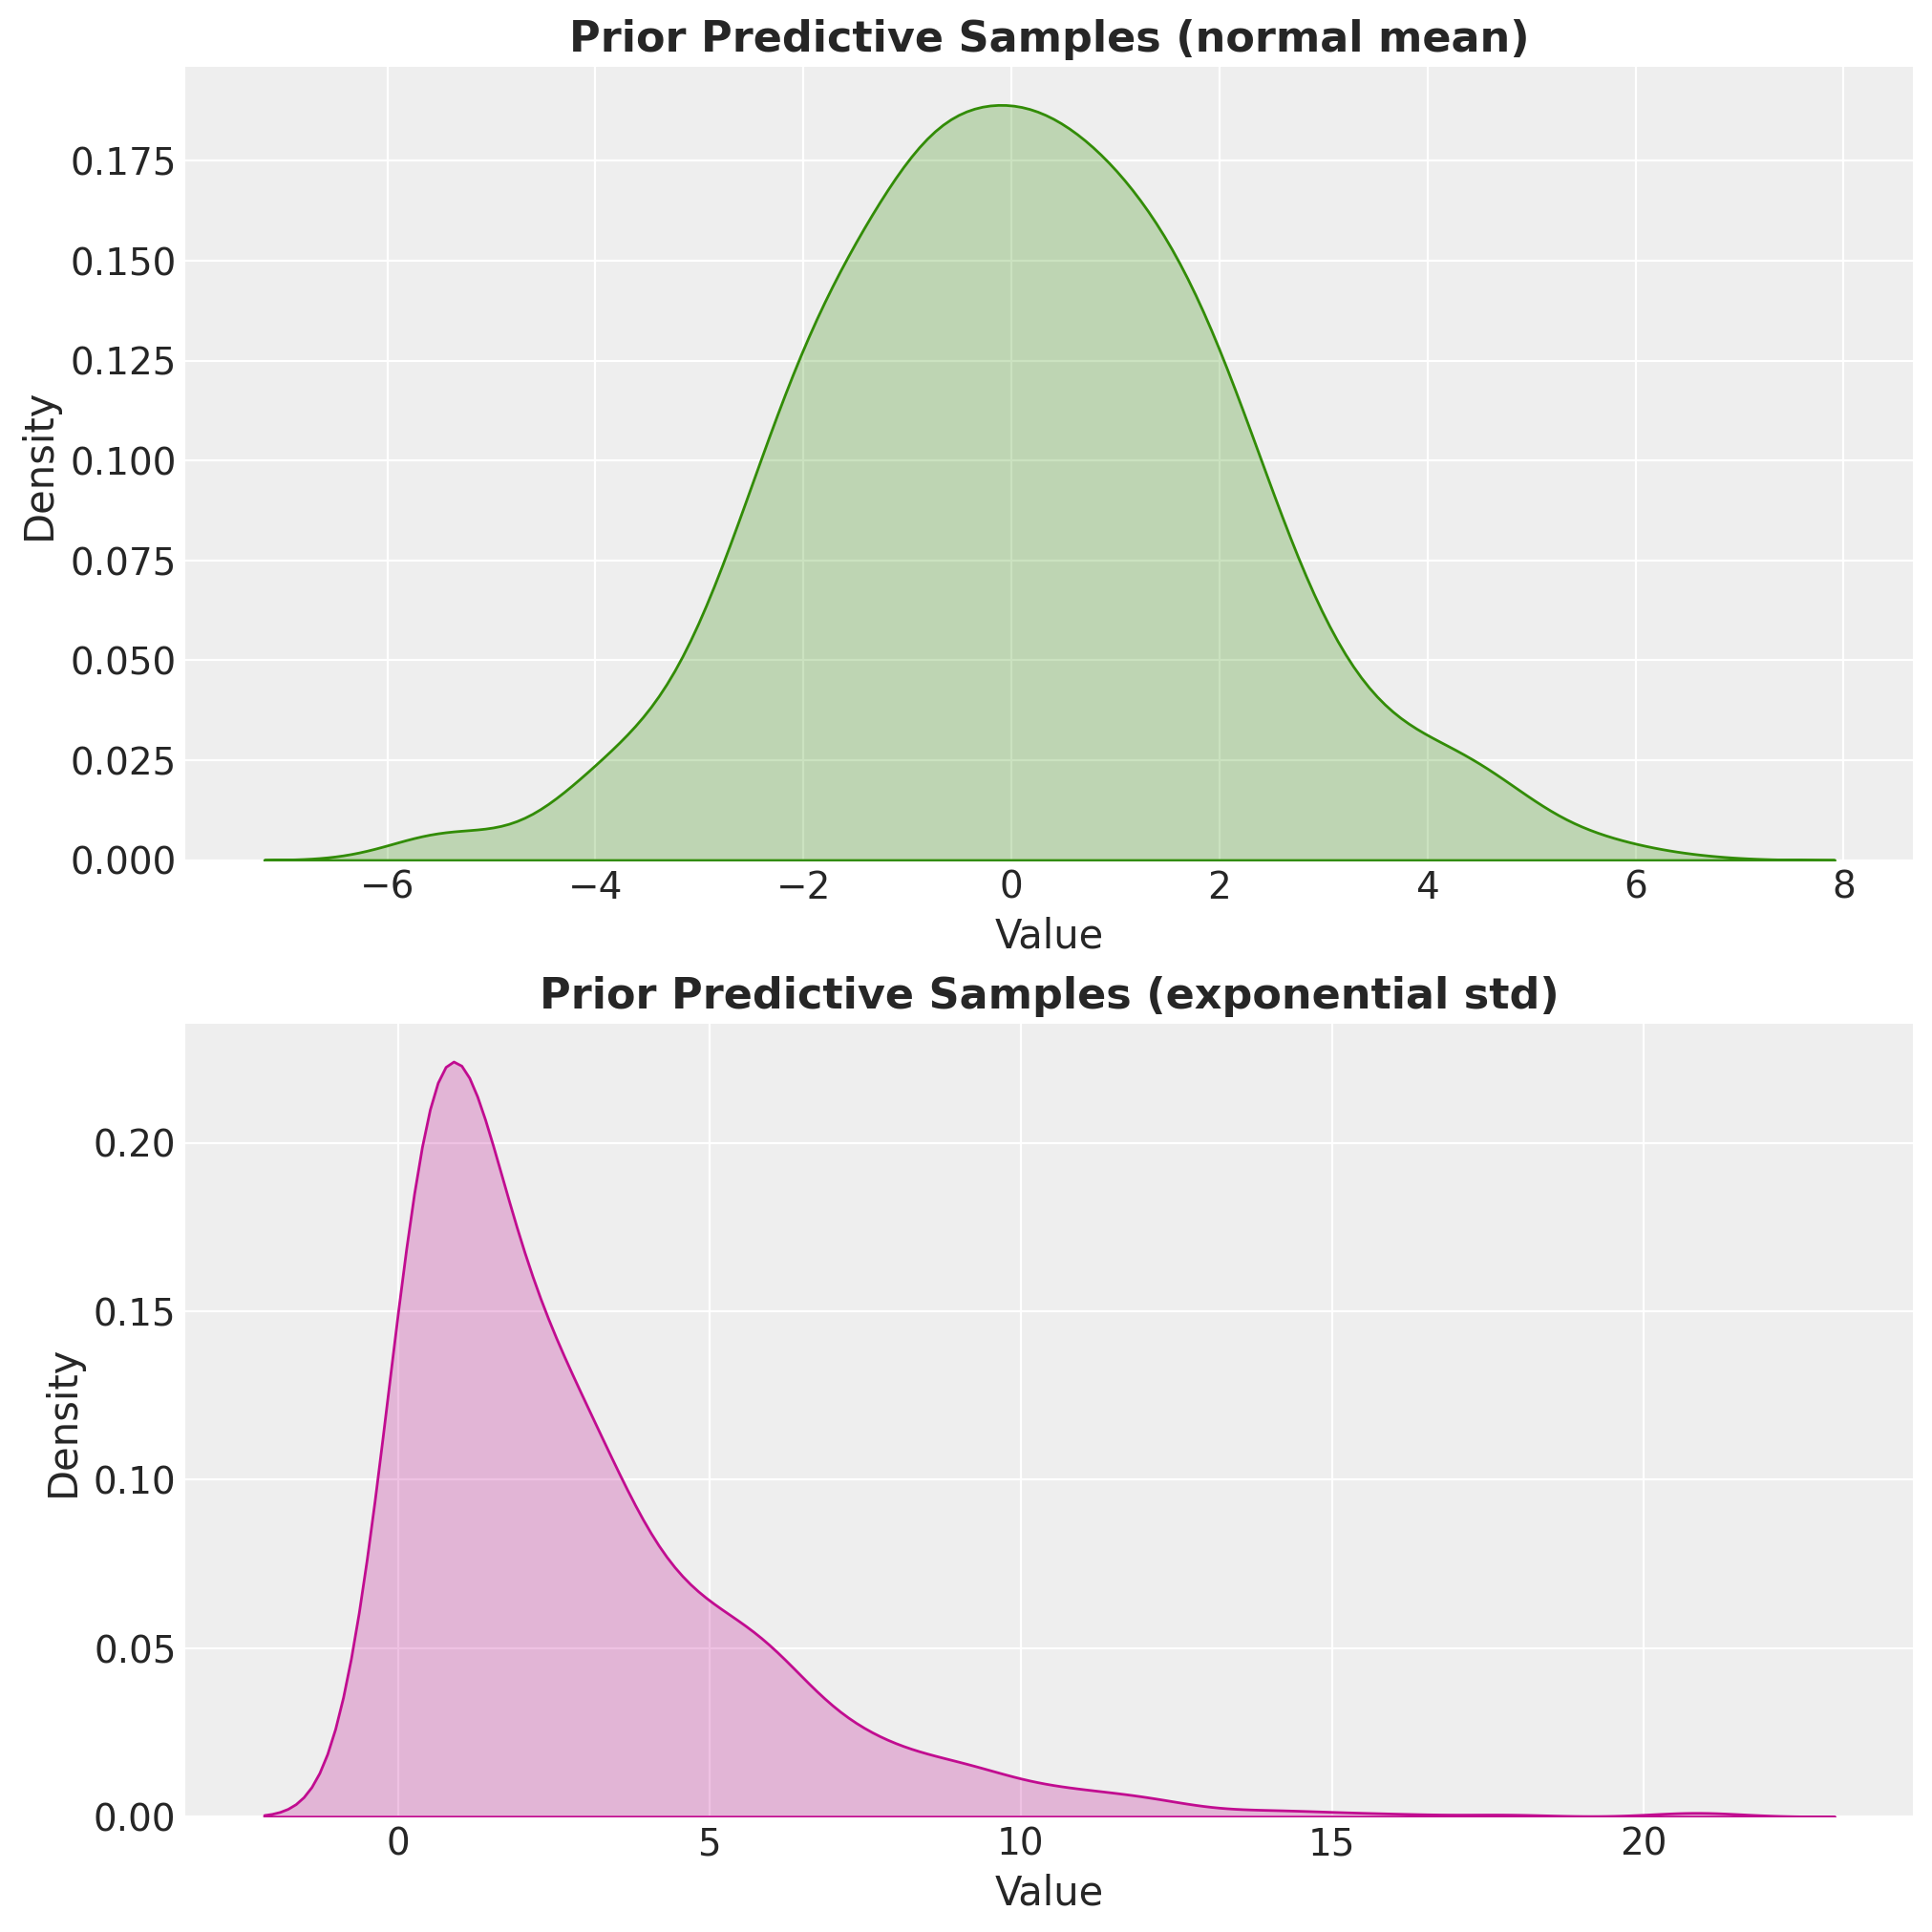

In [6]:
# Set the number of prior samples
n_prior_samples: int = 1_000

# Sample from the prior distributions
mus = rng.normal(loc=0, scale=2, size=n_prior_samples)
sigmas = rng.exponential(scale=3, size=n_prior_samples)

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 10),
    sharex=False,
    sharey=False,
    layout="constrained",
)

sns.kdeplot(mus, fill=True, color="C2", ax=ax[0])
ax[0].set(xlabel="Value", ylabel="Density")
ax[0].set_title(
    "Prior Predictive Samples (normal mean)", fontsize=16, fontweight="bold"
)

sns.kdeplot(sigmas, fill=True, color="C3", ax=ax[1])
ax[1].set(xlabel="Value", ylabel="Density")
ax[1].set_title(
    "Prior Predictive Samples (exponential std)", fontsize=16, fontweight="bold"
);

Next, we pass these samples through a normal distribution to get the prior predictive samples.

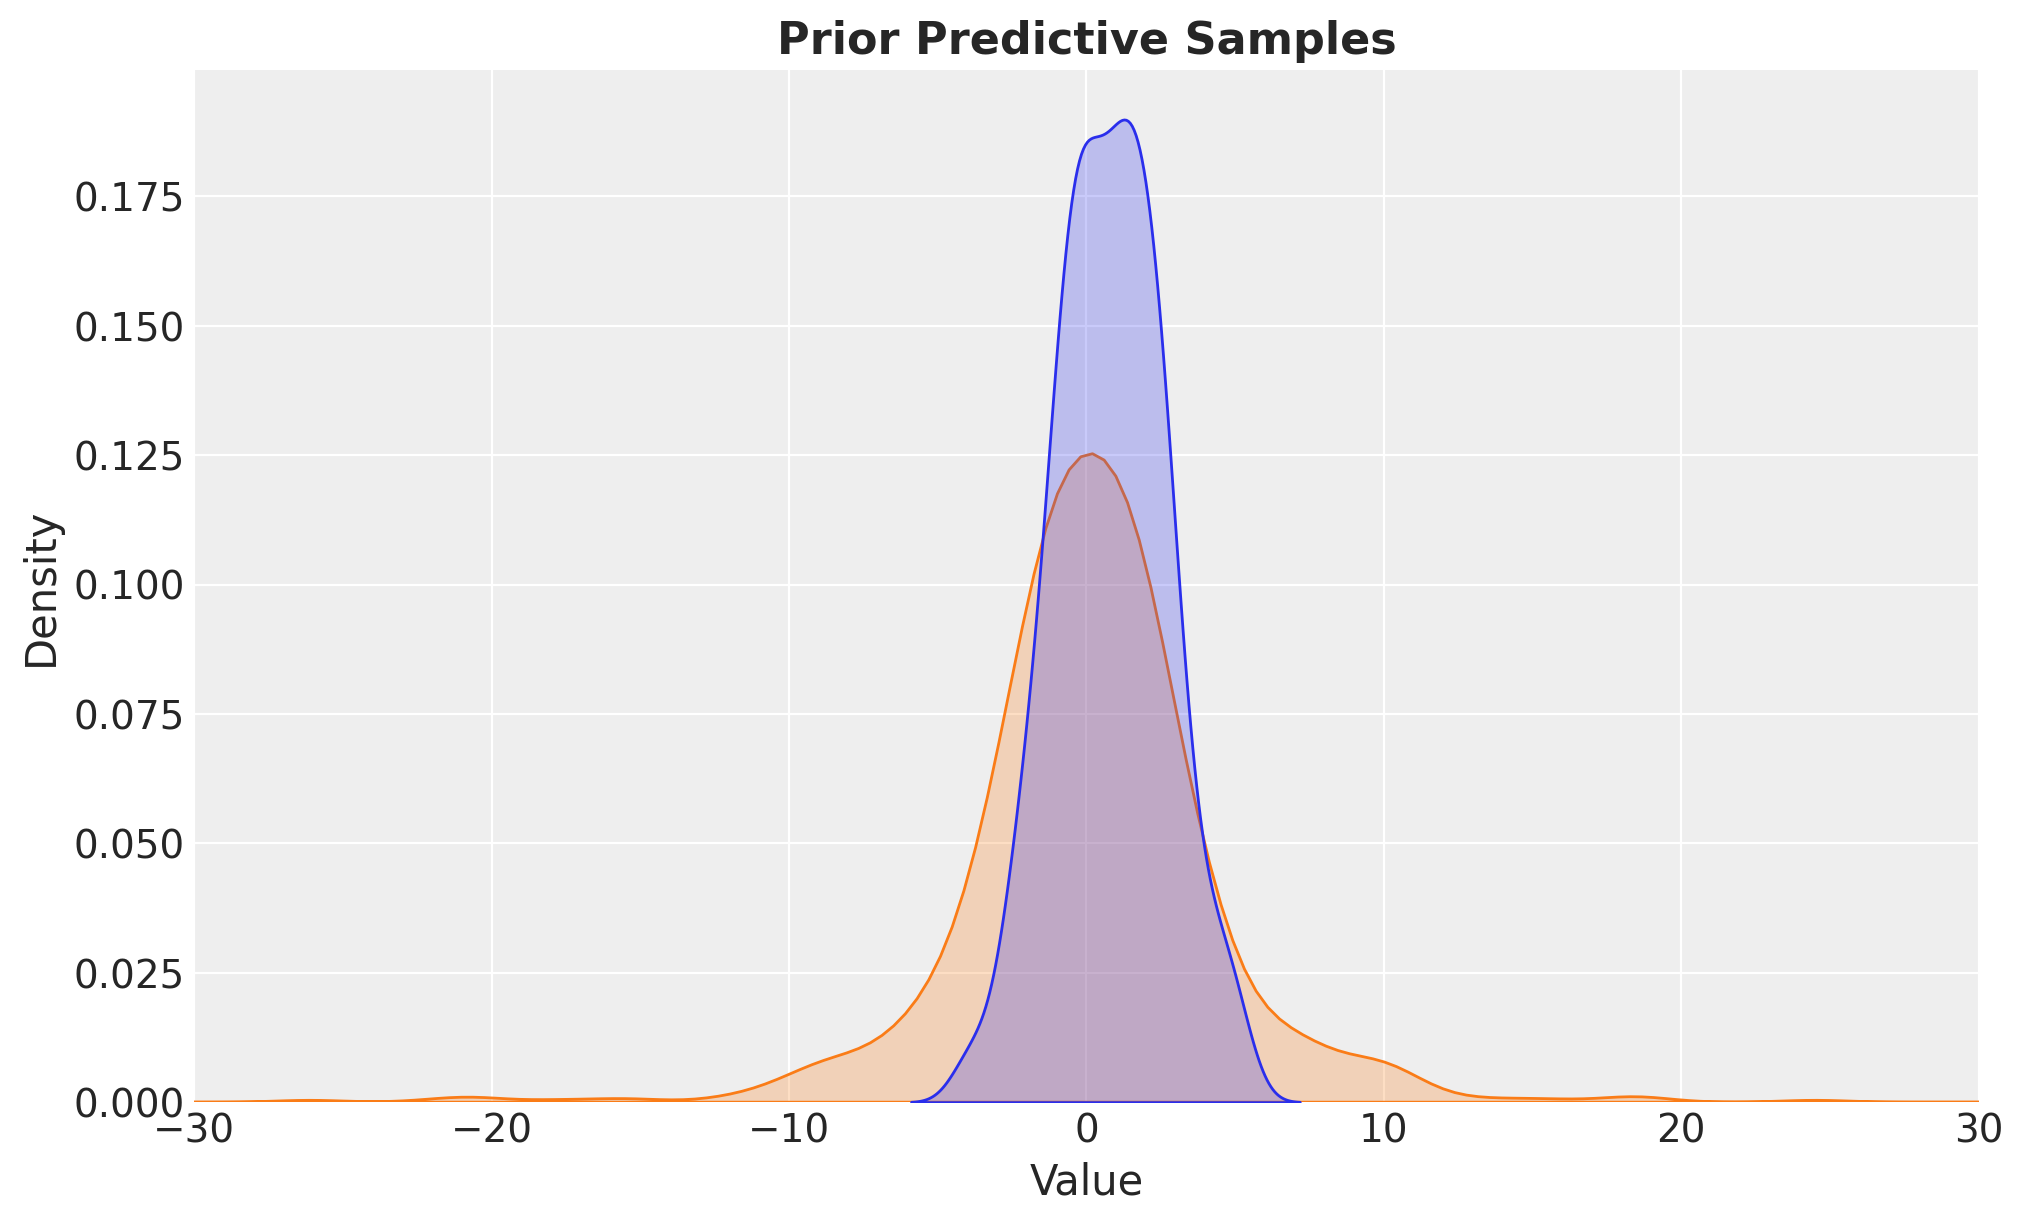

In [7]:
prior_predictive_samples = rng.normal(loc=mus, scale=sigmas)

fig, ax = plt.subplots()
sns.kdeplot(prior_predictive_samples, fill=True, color="C1", ax=ax)
sns.kdeplot(data, fill=True, color="C0", ax=ax)
ax.set(xlim=(-30, 30))
ax.set(xlabel="Value", ylabel="Density")
ax.set_title("Prior Predictive Samples", fontsize=16, fontweight="bold");

The prior predictive check shows a good agreement between our simulated data and the prior predictive samples. The overlapping densities indicate that our chosen prior distributions for the mean (normal) and standard deviation (exponential) are reasonable and can generate data similar to what we observe. This suggests our prior specifications are appropriate for this modeling task.


### Prior Predictive Sampling with PyMC

We start by defining the model in PyMC. Note that we do not need to pass the observed data (yet) in order to sample from the prior predictive distribution.

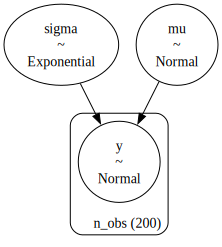

In [8]:
with pm.Model(coords={"n_obs": range(data.shape[0])}) as model:
    # Define the prior distributions
    mu = pm.Normal("mu", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1 / 3)

    # Define the likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, dims="n_obs")

model.to_graphviz()

PyMC offers a convenient way to sample from the prior predictive distribution using the {func}`pymc.sample_prior_predictive <pymc.sample_prior_predictive>` function.

In [9]:
with model:
    # Sample from the prior predictive distribution
    idata = pm.sample_prior_predictive(samples=n_prior_samples)

Sampling: [mu, sigma, y]


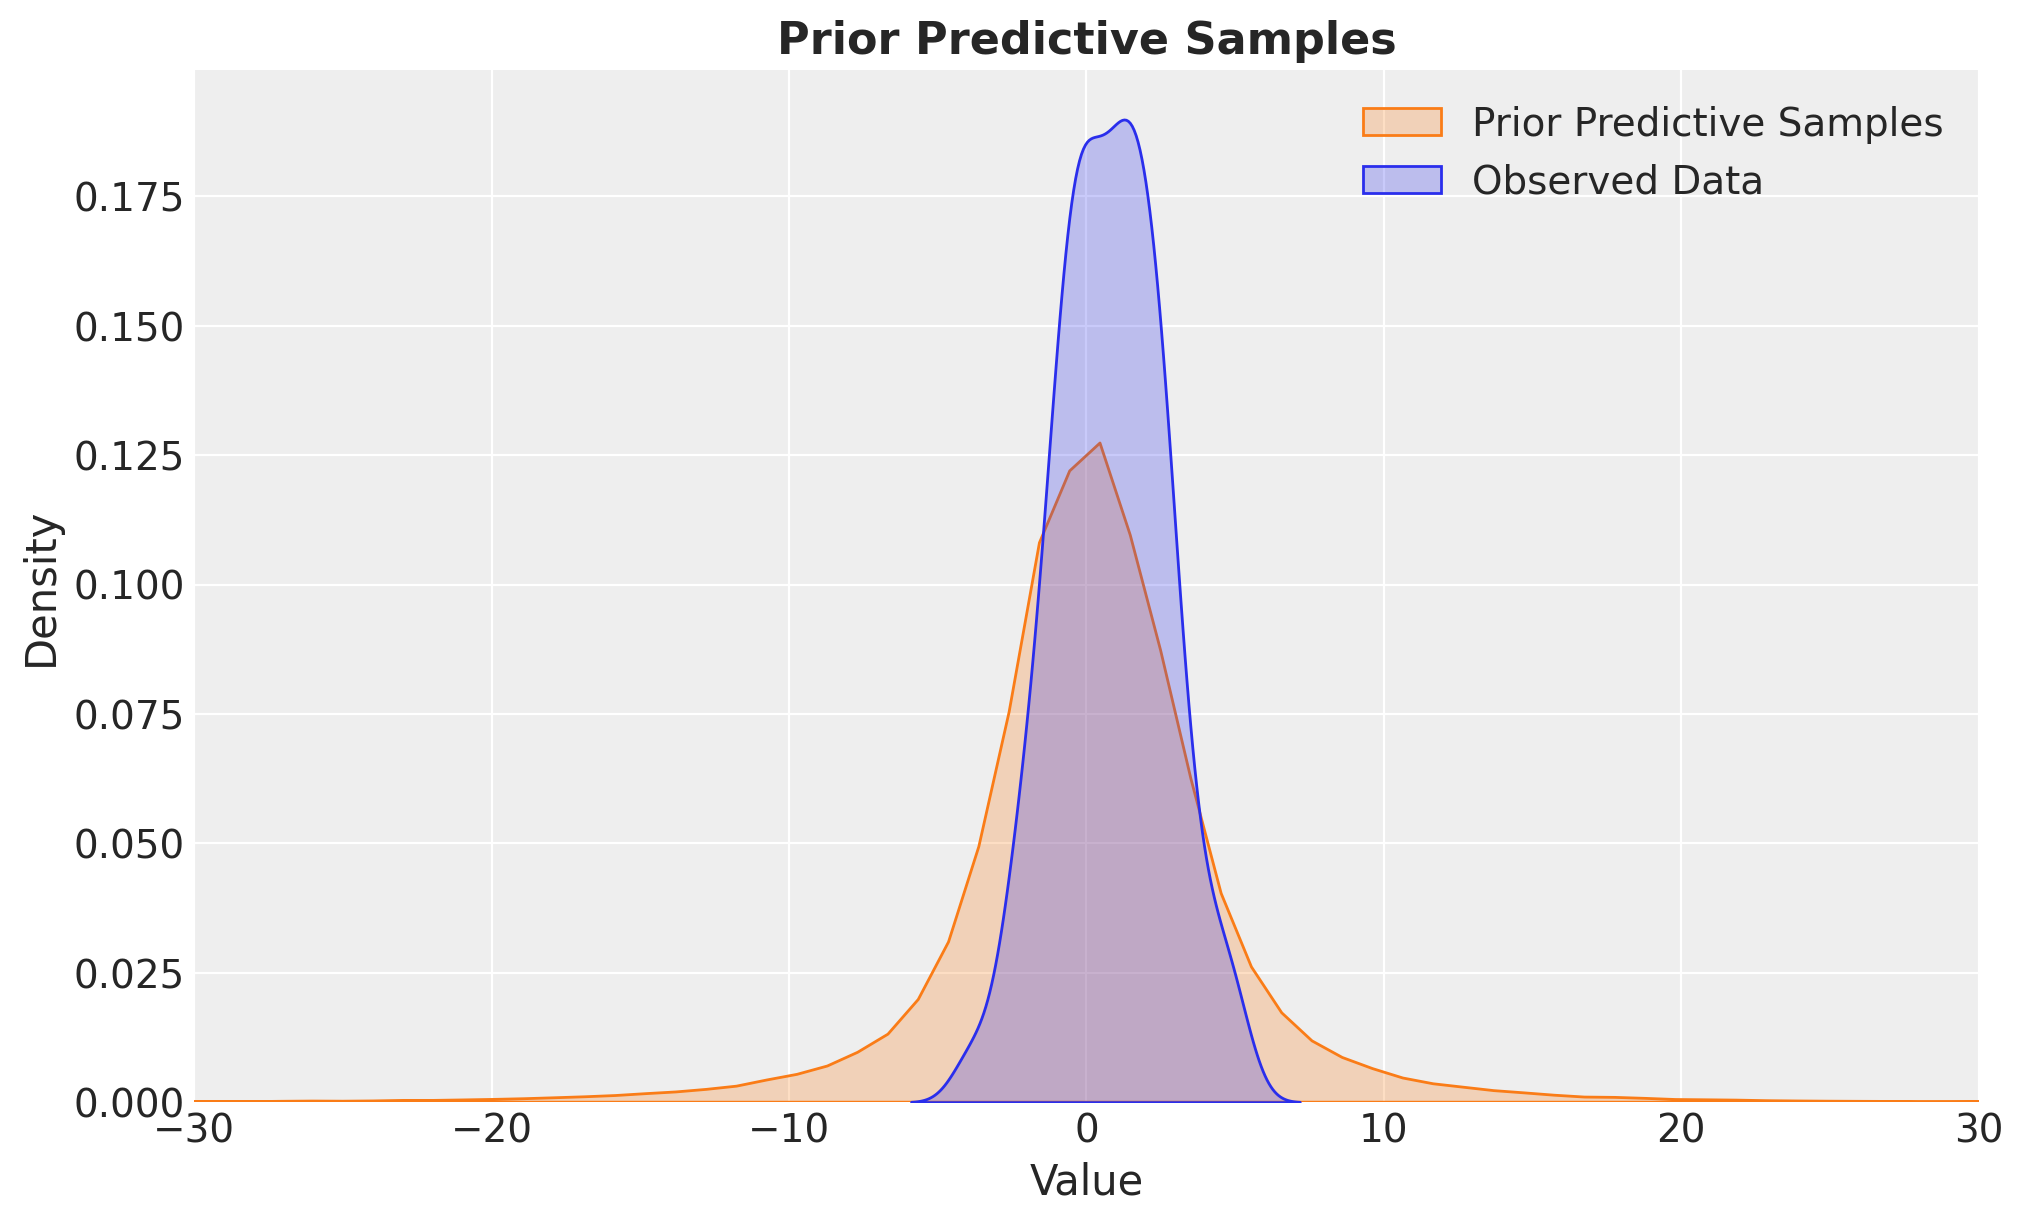

In [10]:
fig, ax = plt.subplots()
sns.kdeplot(
    idata["prior"]["y"].to_numpy().flatten(),
    fill=True,
    color="C1",
    label="Prior Predictive Samples",
    ax=ax,
)
sns.kdeplot(data, fill=True, color="C0", label="Observed Data", ax=ax)
ax.legend()
ax.set(xlabel="Value", ylabel="Density", xlim=(-30, 30))
ax.set_title("Prior Predictive Samples", fontsize=16, fontweight="bold");

The prior predictive samples are very similar to the ones obtained from the manual sampling.

### Posterior Predictive Sampling

Now we can fit the model to the observed data and sample from the posterior predictive distribution.

In [11]:
# Condition the model on the observed data
conditioned_model = pm.observe(model, {"y": data})

# Sample
with conditioned_model:
    # Sample from the posterior distribution
    idata.extend(pm.sample())
    # Sample from the posterior predictive distribution
    idata.extend(pm.sample_posterior_predictive(idata))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


Output()

Let's plot the posterior distributions of the mean and standard deviation parameters.

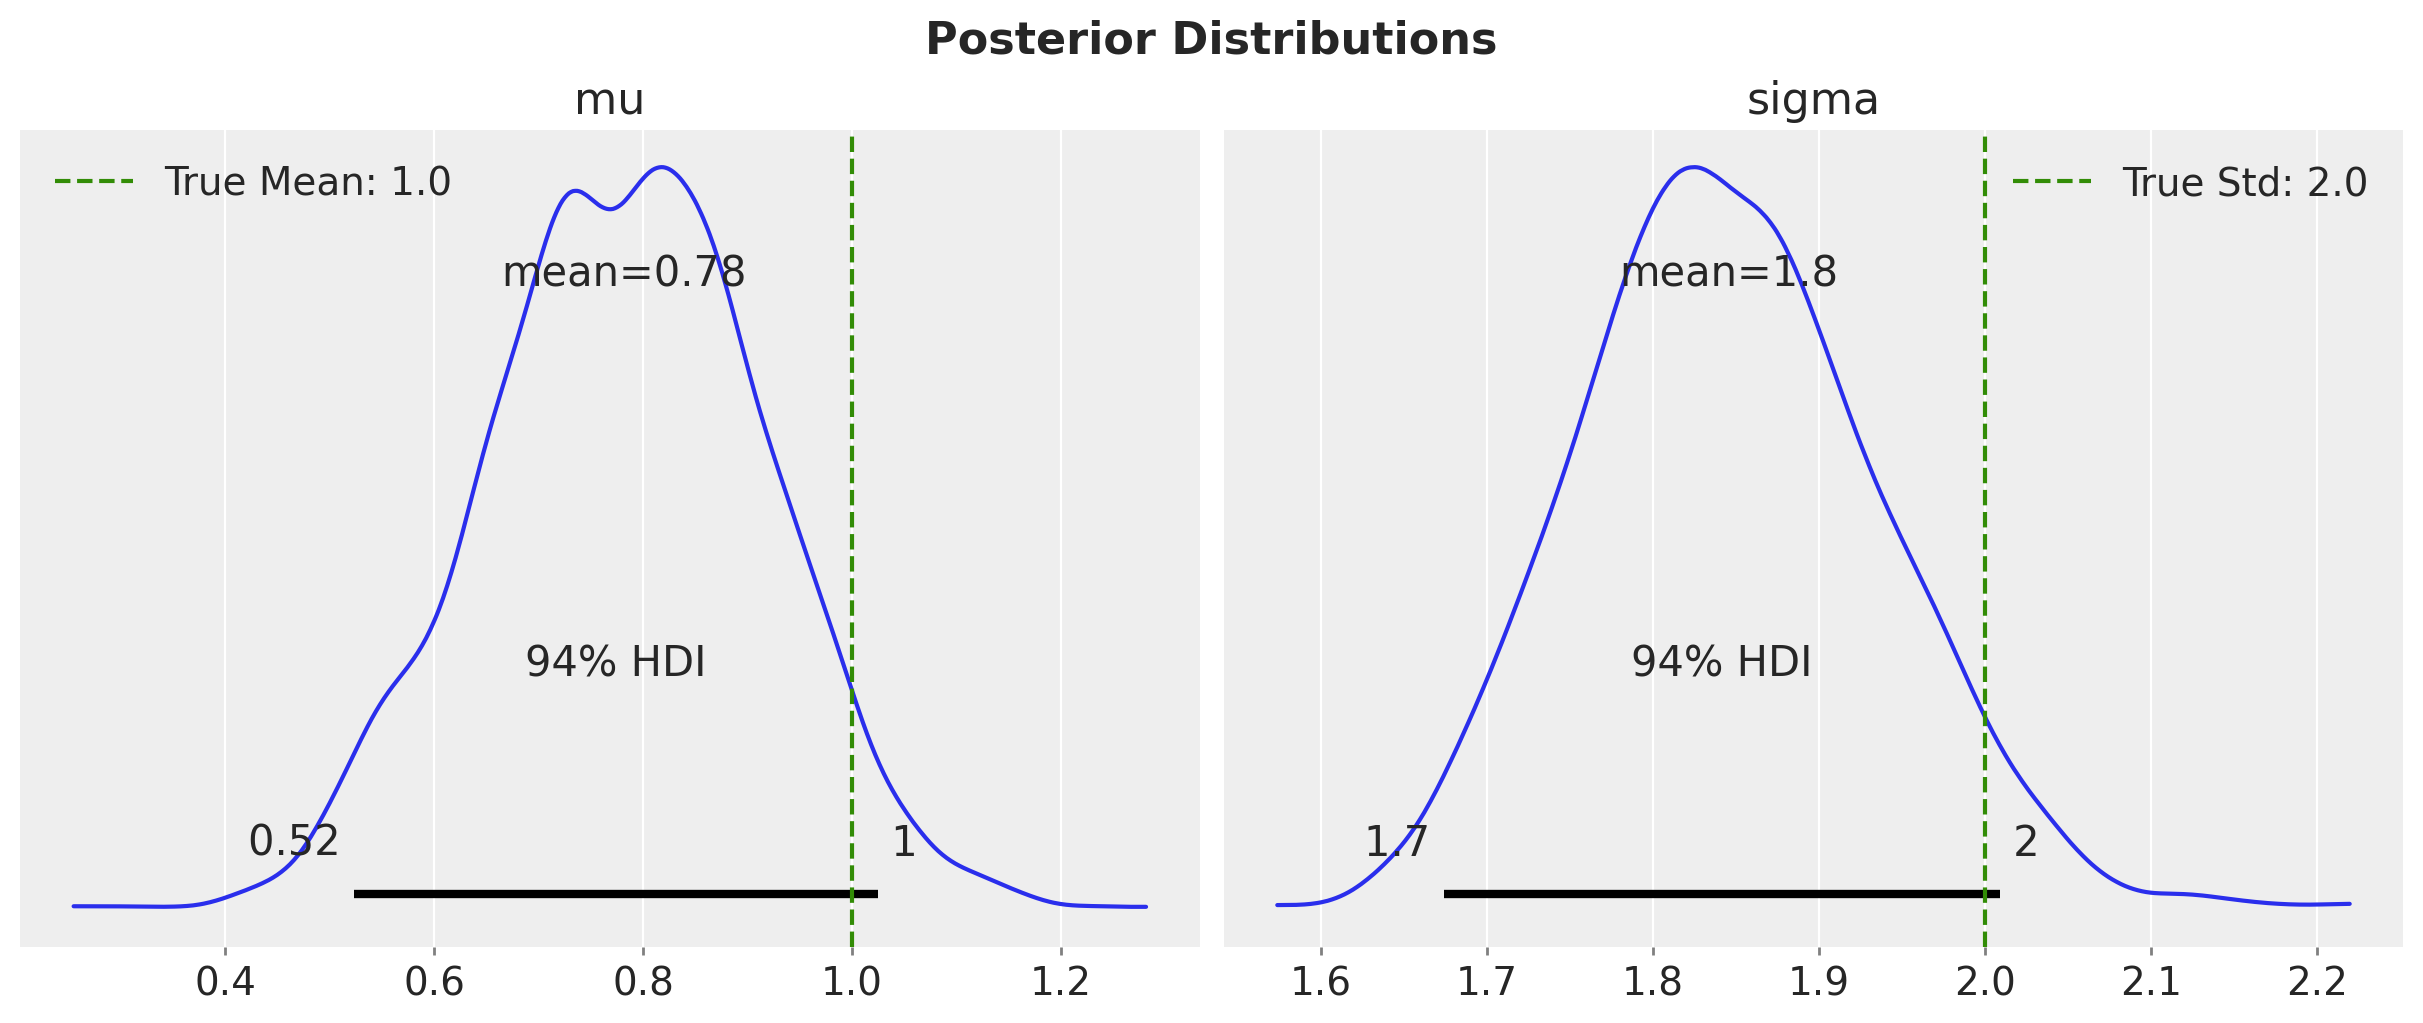

In [12]:
axes = az.plot_posterior(idata, var_names=["mu", "sigma"], figsize=(12, 5))

axes[0].axvline(true_mu, color="C2", linestyle="--", label=f"True Mean: {true_mu:.1f}")
axes[1].axvline(
    true_sigma, color="C2", linestyle="--", label=f"True Std: {true_sigma:.1f}"
)
axes[0].legend()
axes[1].legend()

fig = plt.gcf()
fig.suptitle("Posterior Distributions", fontsize=16, fontweight="bold");

We obtain values very close to the true values (this is known as parameter recovery).

We can compare the prior and posterior distributions of the mean and standard deviation parameters. These plots are very handy to understand the impact of the data on the parameters.

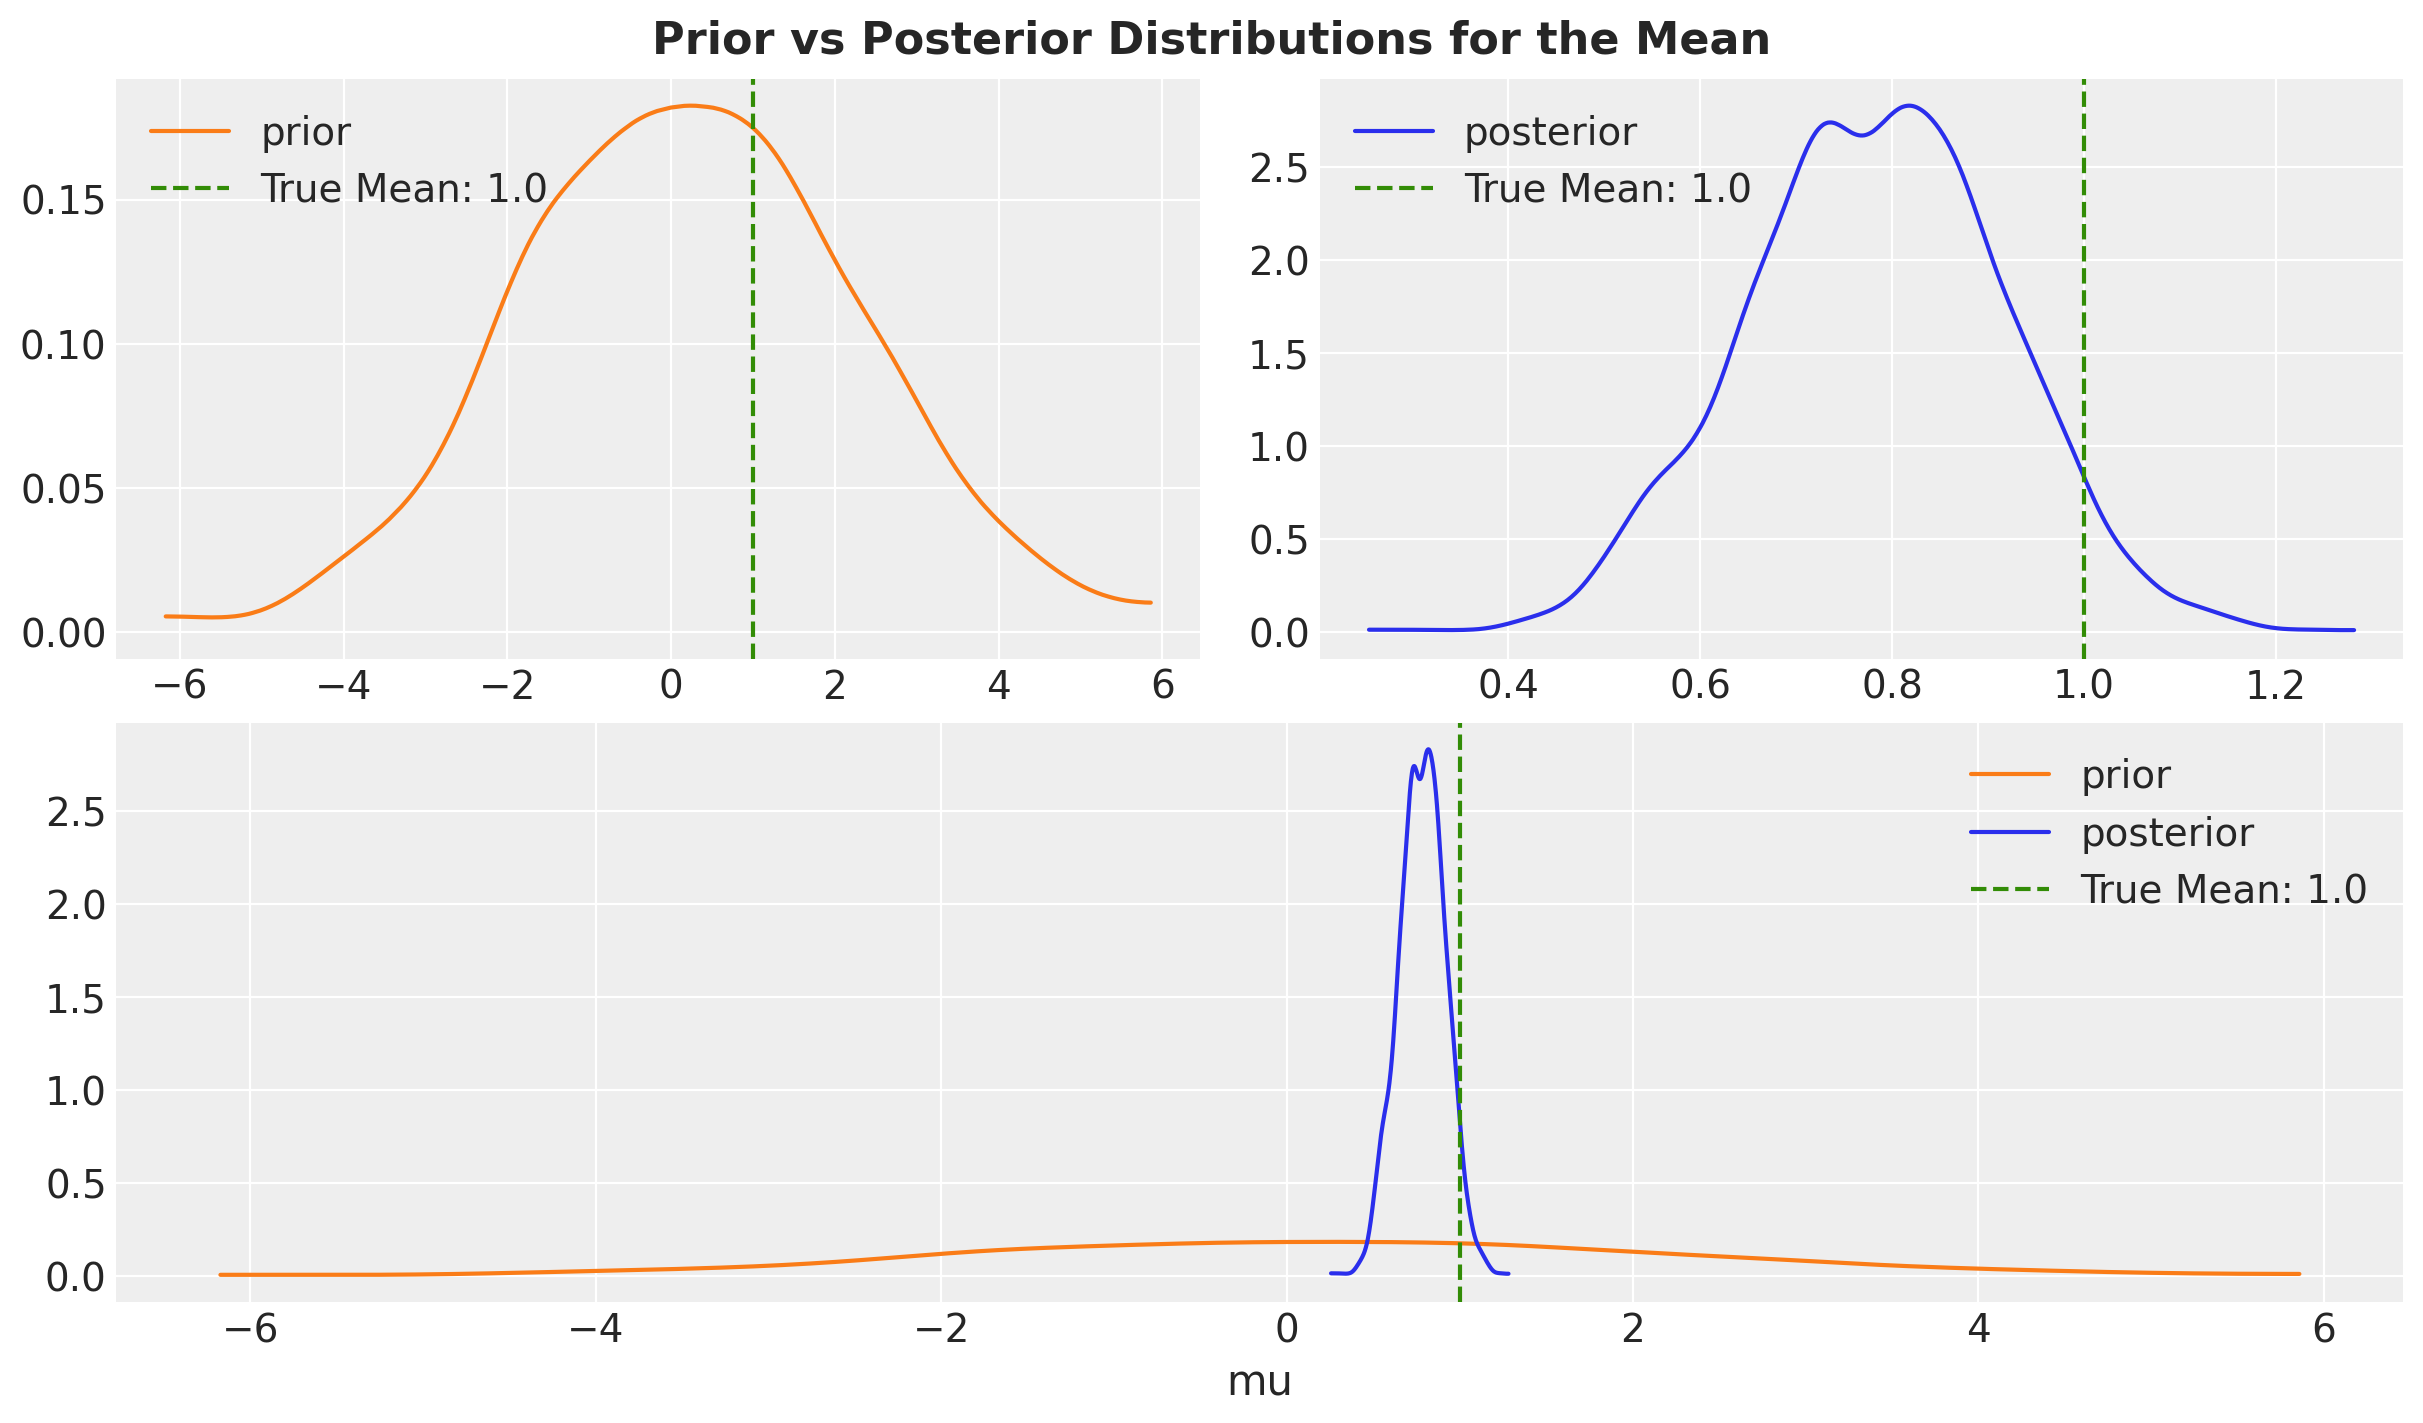

In [13]:
axes = az.plot_dist_comparison(idata, var_names=["mu"], figsize=(12, 7))
axes = axes.flatten()
for ax in axes:
    ax.axvline(true_mu, color="C2", linestyle="--", label=f"True Mean: {true_mu:.1f}")
    ax.legend()
fig = plt.gcf()
fig.suptitle(
    "Prior vs Posterior Distributions for the Mean", fontsize=16, fontweight="bold"
);

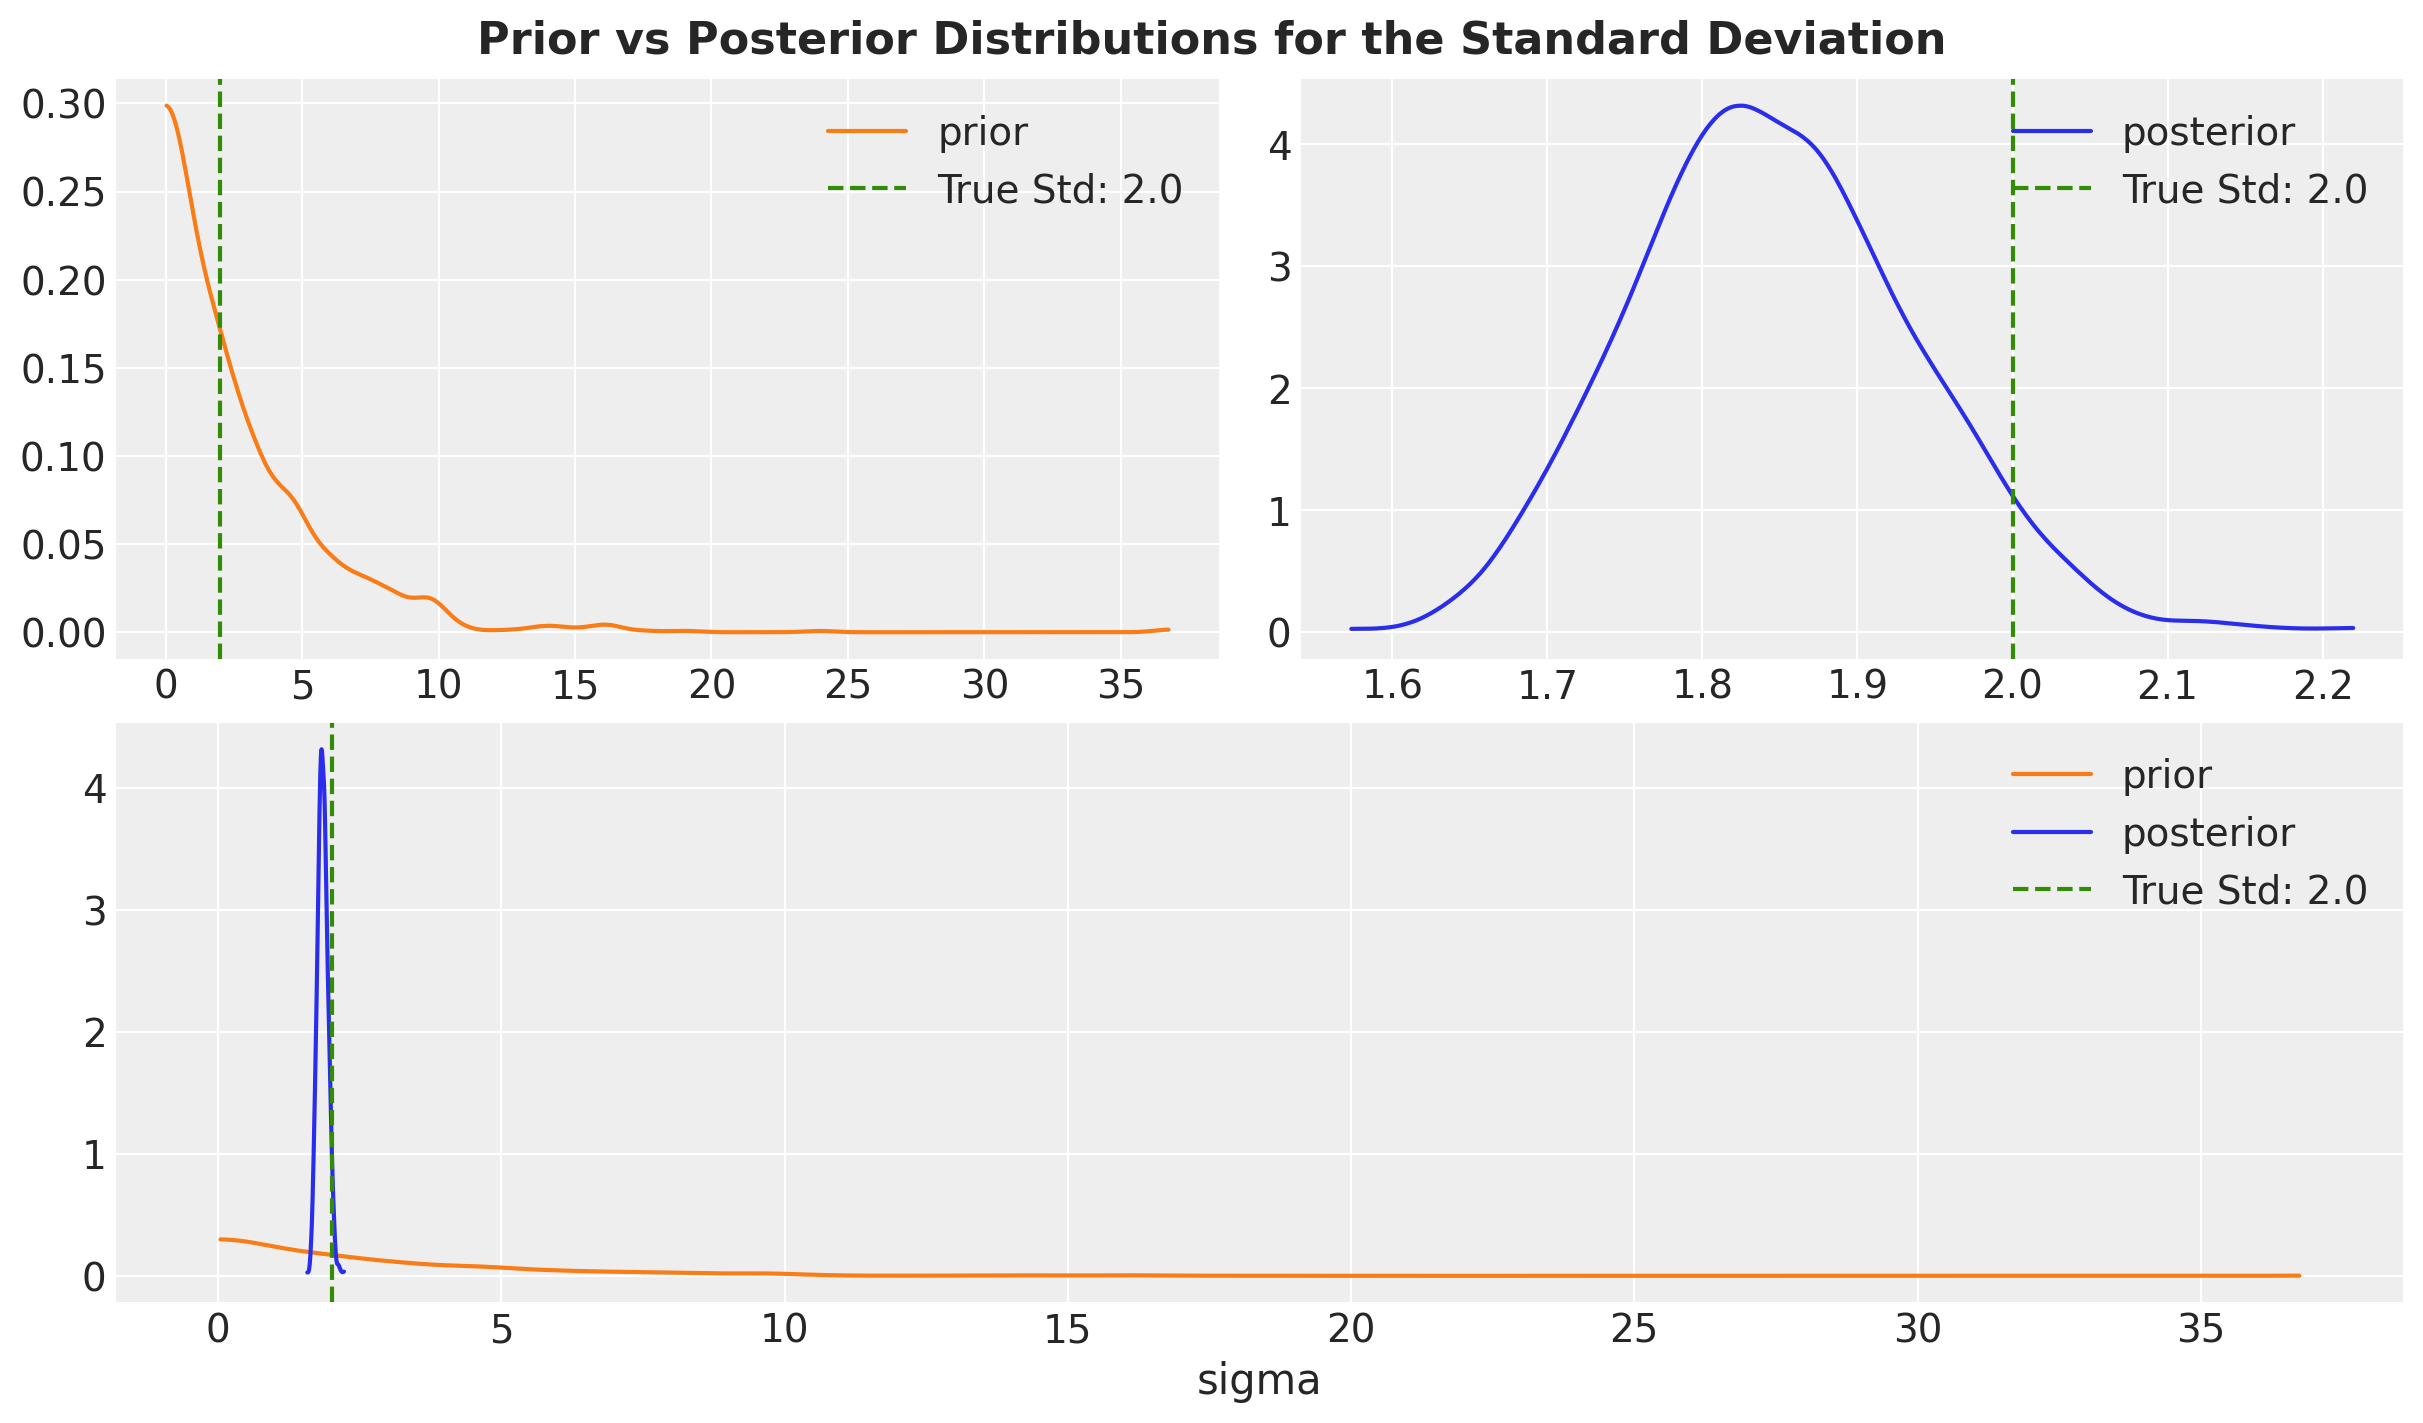

In [14]:
axes = az.plot_dist_comparison(idata, var_names=["sigma"], figsize=(12, 7))
axes = axes.flatten()
for ax in axes:
    ax.axvline(
        true_sigma, color="C2", linestyle="--", label=f"True Std: {true_sigma:.1f}"
    )
    ax.legend()
fig = plt.gcf()
fig.suptitle(
    "Prior vs Posterior Distributions for the Standard Deviation",
    fontsize=16,
    fontweight="bold",
);

Finally, we can plot the posterior predictive distribution vs the observed data.

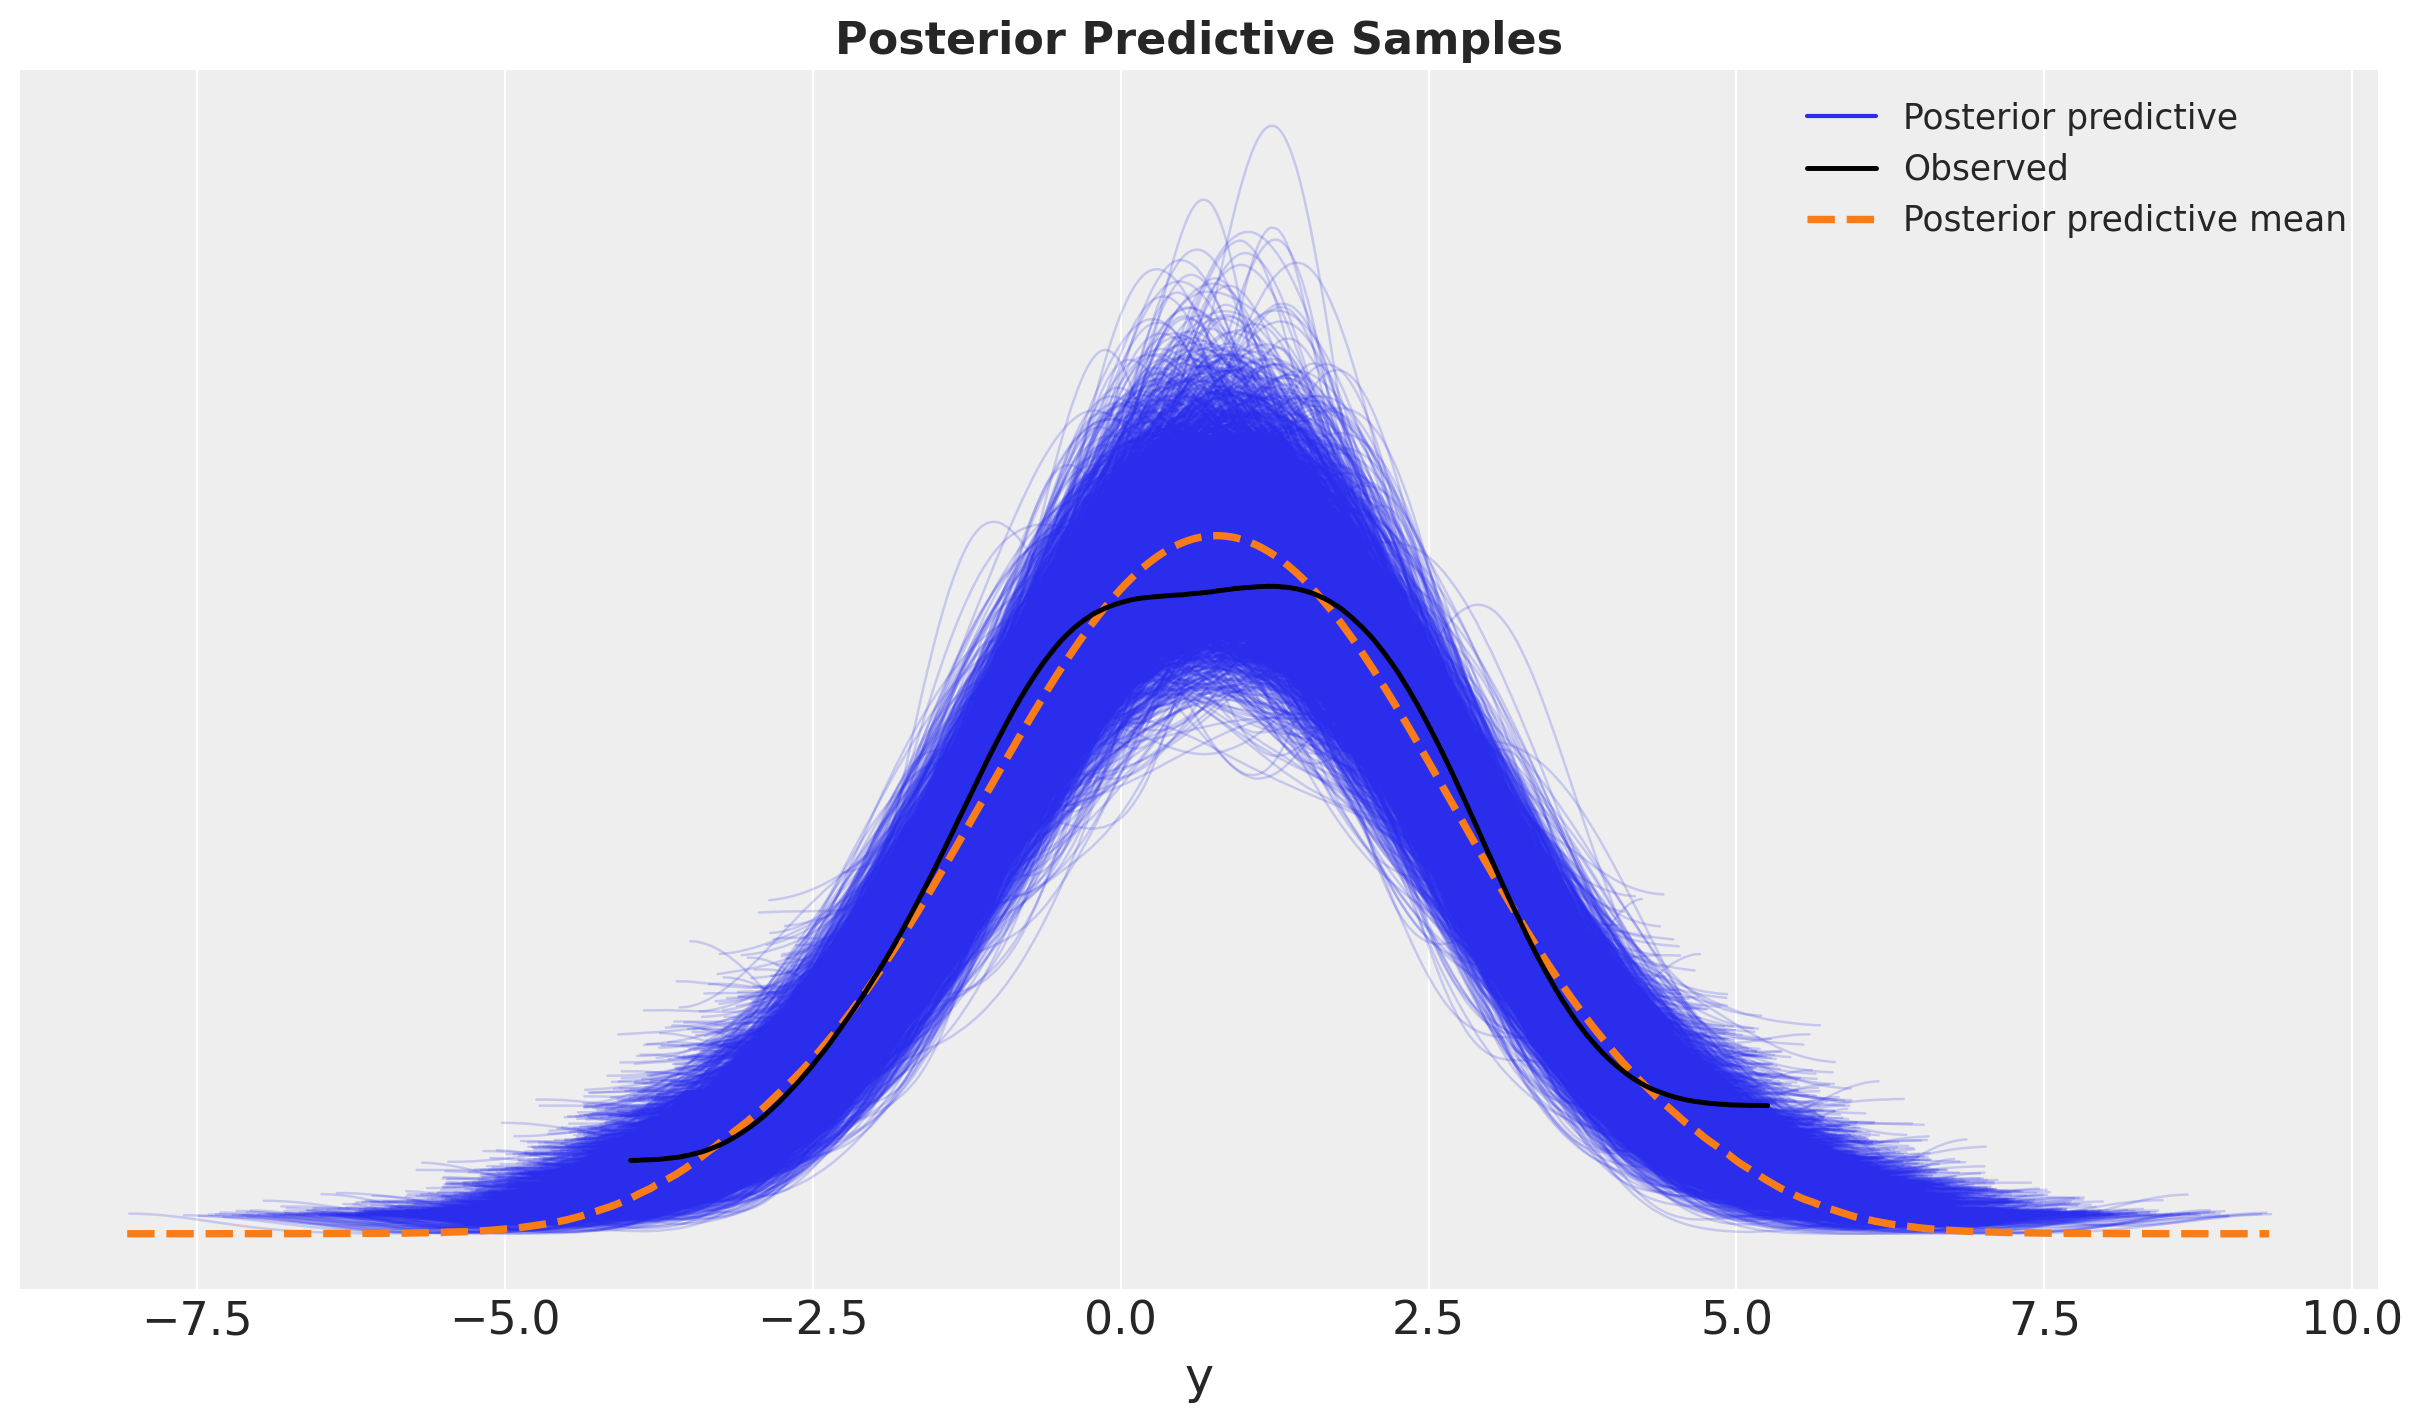

In [15]:
ax = az.plot_ppc(idata, var_names=["y"], figsize=(12, 7))
ax.set_title("Posterior Predictive Samples", fontsize=16, fontweight="bold");

We see that the posterior predictive distribution is very similar to the observed data. This is a good sign that our model is well specified.

```{warning}
When working with generalized linear models (GLMs), and models with non linear transformations (for example, media mix models), normal priors on coefficients can sometimes lead to unexpected behavior due to the non-linear link functions. Make sure to check the prior predictive distribution for these models carefully. This is beautifully explained in the (fantastic!) book ["Statistical Rethinking"](https://xcelab.net/rm/) by [Richard McElreath](https://www.eva.mpg.de/ecology/staff/richard-mcelreath/).
```

---

## Prior Predictive Sampling for Marketing Mix Models

In the section we we focus on how to do prior predictive sampling for marketing mix models. We will use the same data from the {ref}`mmm_example` notebook. In particular, we focus on the ROAS of the two channels `x1` and `x2`.

### Read Data

We start by reading the data.

In [16]:
data_path = data_dir / "mmm_example.csv"

data_df = pd.read_csv(data_path, parse_dates=["date_week"]).assign(
    y=lambda df: df["y"] / 1_000
)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_week  179 non-null    datetime64[ns]
 1   y          179 non-null    float64       
 2   x1         179 non-null    float64       
 3   x2         179 non-null    float64       
 4   event_1    179 non-null    float64       
 5   event_2    179 non-null    float64       
 6   dayofyear  179 non-null    int64         
 7   t          179 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.3 KB


Recall we want to understand the ROAS and contribution of the two channels `x1` and `x2` to the sales data `y`. Let's plot the data.

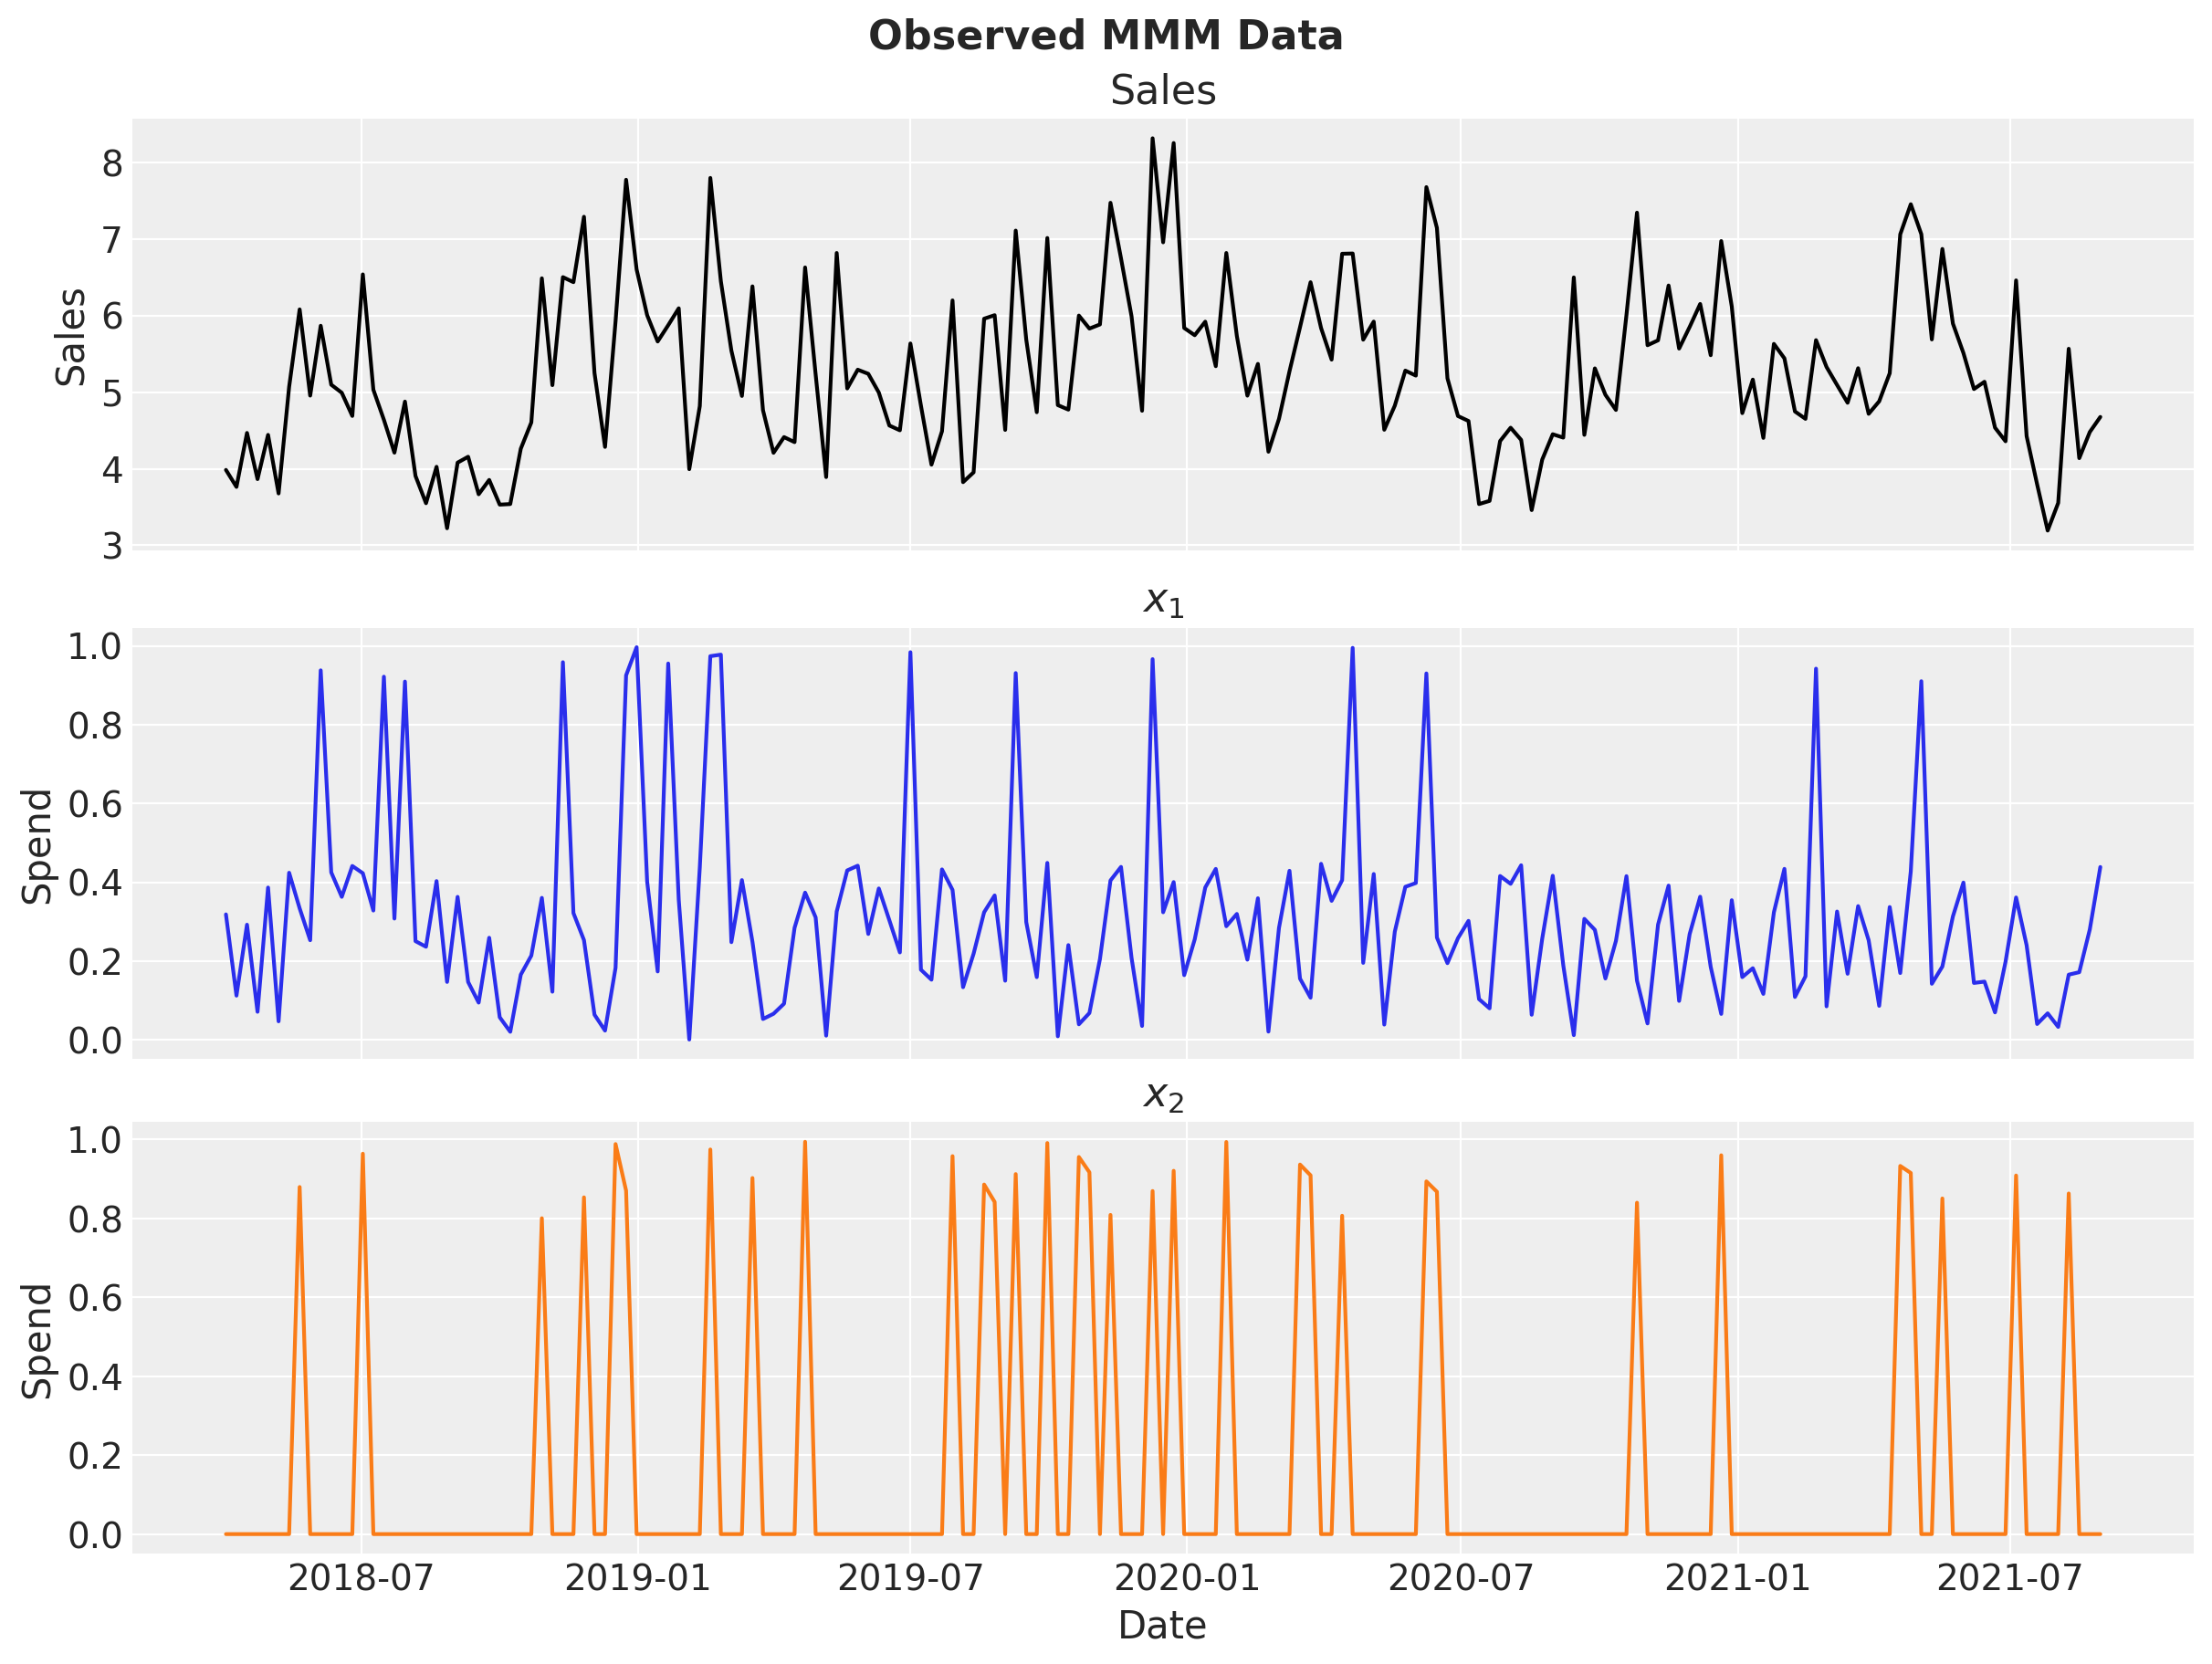

In [17]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained",
)

sns.lineplot(data=data_df, x="date_week", y="y", color="black", ax=ax[0])
ax[0].set(title="Sales", xlabel="Date", ylabel="Sales")

sns.lineplot(data=data_df, x="date_week", y="x1", color="C0", ax=ax[1])
ax[1].set(title=r"$x_1$", xlabel="Date", ylabel="Spend")

sns.lineplot(data=data_df, x="date_week", y="x2", color="C1", ax=ax[2])
ax[2].set(title=r"$x_2$", xlabel="Date", ylabel="Spend")

fig.suptitle("Observed MMM Data", fontsize=16, fontweight="bold");

Internally, during the fitting process via the class {class}`MMM <pymc_marketing.mmm.mmm.MMM>` , the channels and target variables are scaled by dividing by the maximum value (per variable). Let's visualize the scaled data.

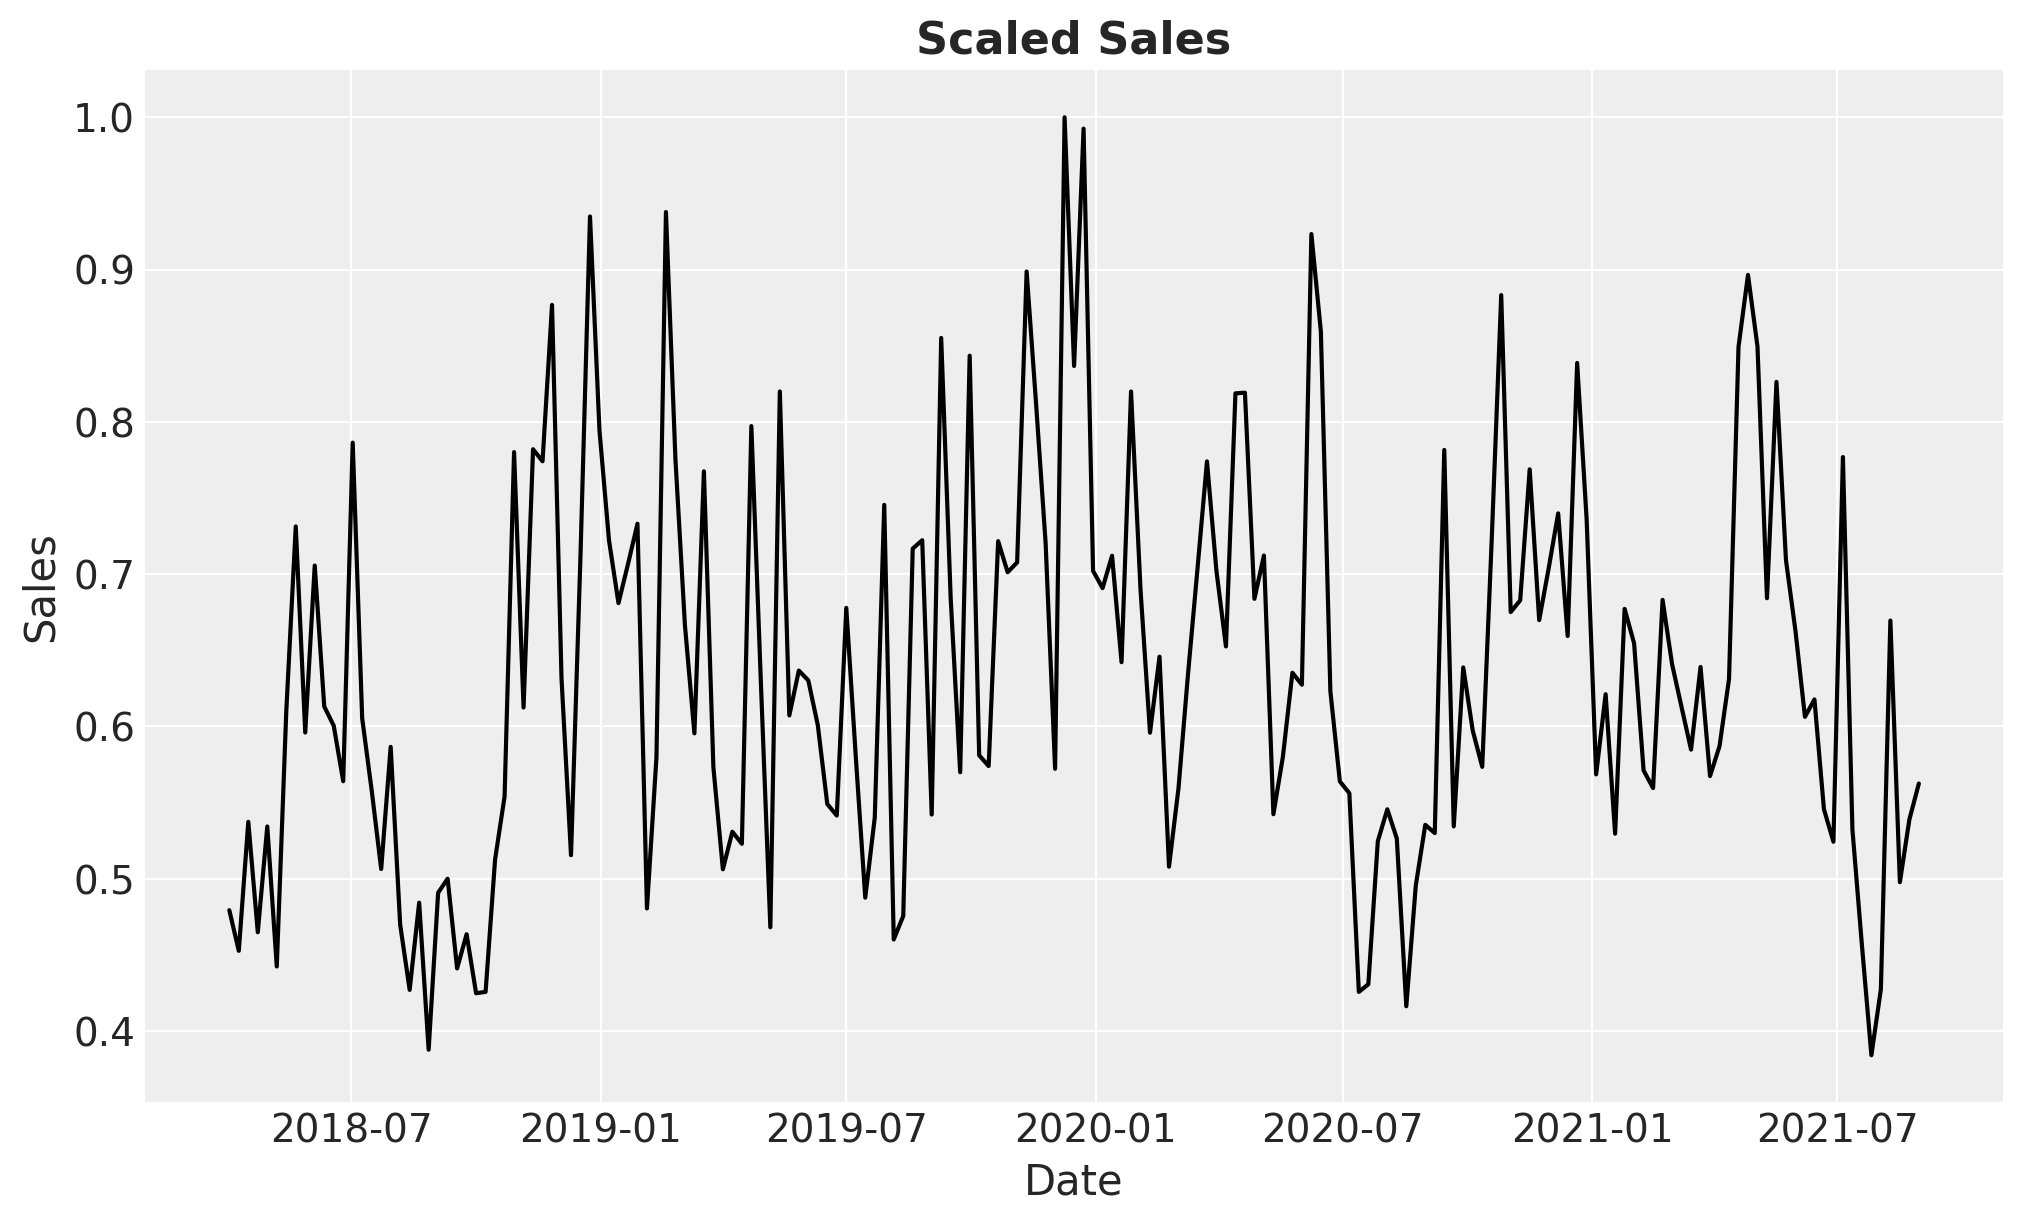

In [18]:
fig, ax = plt.subplots()
sns.lineplot(
    data=data_df.assign(y=lambda df: df["y"] / df["y"].max()),
    x="date_week",
    y="y",
    color="black",
    ax=ax,
)
ax.set(title="Sales", xlabel="Date", ylabel="Sales")
ax.set_title("Scaled Sales", fontsize=16, fontweight="bold");

We see there is a mild trend component and some seasonality (please refer to the {ref}`mmm_example` notebook for more details).

### Priors Specification on the Media Parameters

We now describe a way to think about the priors specification on the media parameters. In real applications, the modeler usually has additional valuable domain kwowledge and information to be incorporated into the model through priors (e.g lift tests, benchmarks, etc). In this example, we simply set priors from the input spend data.

Recall that the idea of these types of media mix models is to pass the media spend through an adstock transformation and then through a saturation function (both, non linear functions) before adding them to the linear model to add other control variables. These non linear transformations are controlled by the parameters $\alpha$ (adstock) , $\lambda$ (saturation) and $\beta$ (regression) coefficients. We must specify priors for these parameters. Nevertheless, the {class}`MMM <pymc_marketing.mmm.mmm.MMM>` class provides reasonable defaults priors.


#### Adstock

Let's start by looking into the adstock parameter. The adstock parameter controls the decay rate of the media effect over time. A higher value of $\alpha$ indicates a slower decay, meaning the media effect persists longer. The value of $\alpha$ is usually between 0 and 1. For many digital channels we expect this parameter to be close to $0$ whereas for offline channels (like TV) we expect this parameter to be close to $1$.

Assuming that $x_1$ and $x_2$ are digital channels, we expect the adstock parameter to be close to $0$. We can set a prior for the adstock parameter as follows:

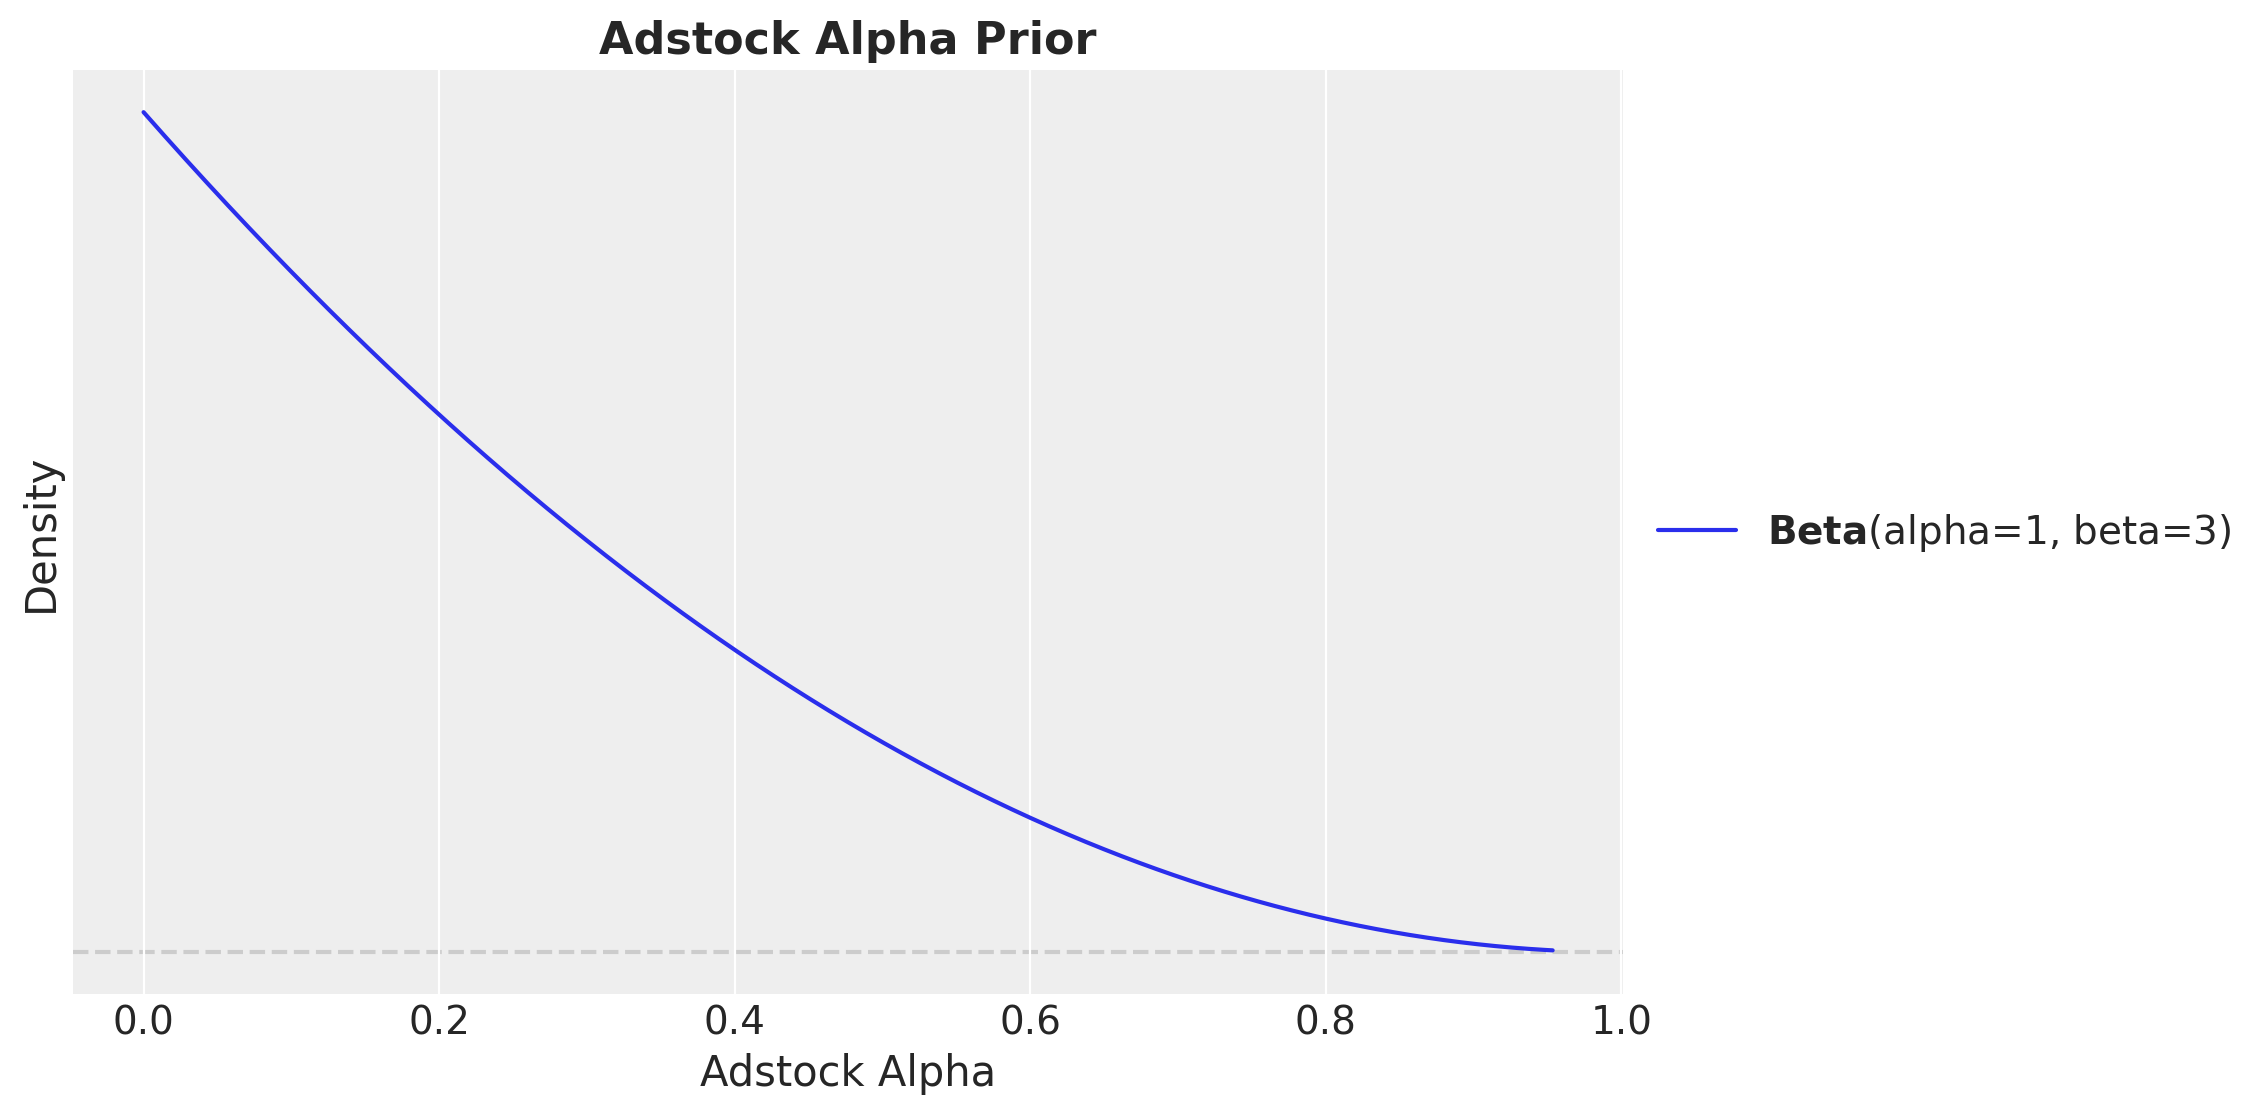

In [19]:
fig, ax = plt.subplots()
# The beta distribution has support in [0, 1]
adstock_alpha_prior = Prior("Beta", alpha=1, beta=3)
adstock_alpha_prior.preliz.plot_pdf(ax=ax)
ax.set(xlabel="Adstock Alpha", ylabel="Density")
ax.set_title("Adstock Alpha Prior", fontsize=16, fontweight="bold");

We can look into the implications of the adstock decay rate on the media effect.

Sampling: [adstock_alpha]
Sampling: []


Output()

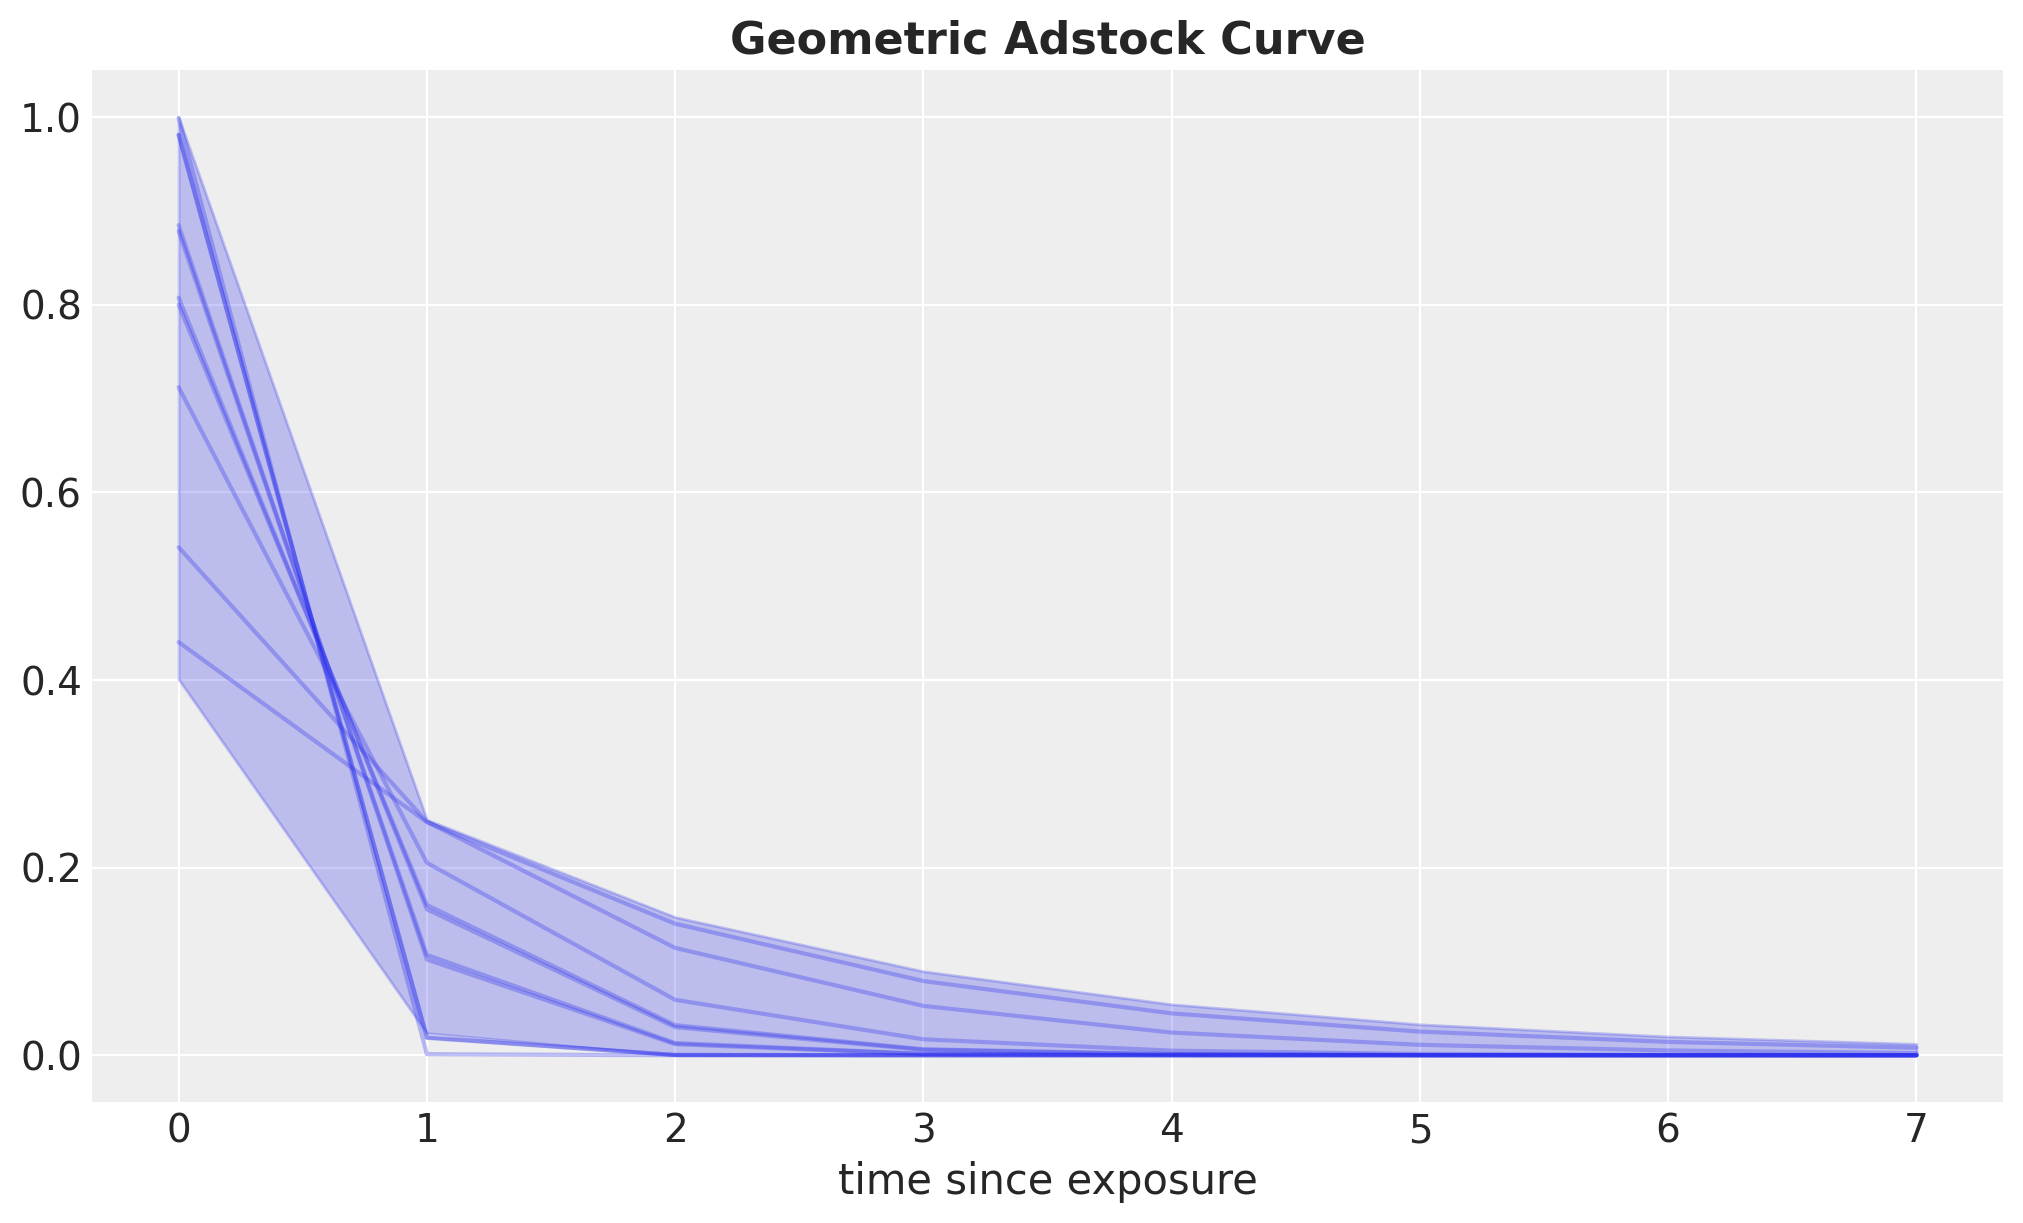

In [20]:
# We usually set the maximum lags based on the context, but we could even try to learn it from the data.
# The challenge is the typical number of data points available for media mix models.
adstock = GeometricAdstock(priors={"alpha": adstock_alpha_prior}, l_max=8)
prior = adstock.sample_prior(samples=1_000, random_seed=rng)
curve = adstock.sample_curve(prior)
fig, axes = adstock.plot_curve(curve, sample_kwargs={"rng": rng})
axes[0].set_title("Geometric Adstock Curve", fontsize=16, fontweight="bold");

#### Saturation

Next we look into the saturation parameter. The saturation parameter controls the saturation level of the media effect. A higher value of $\lambda$ indicates a higher saturation level, meaning the media effect saturates faster. The value of $\lambda$ is always positive. a reasonable prior to start with is something between $0$ and $3$ centered around $1$.

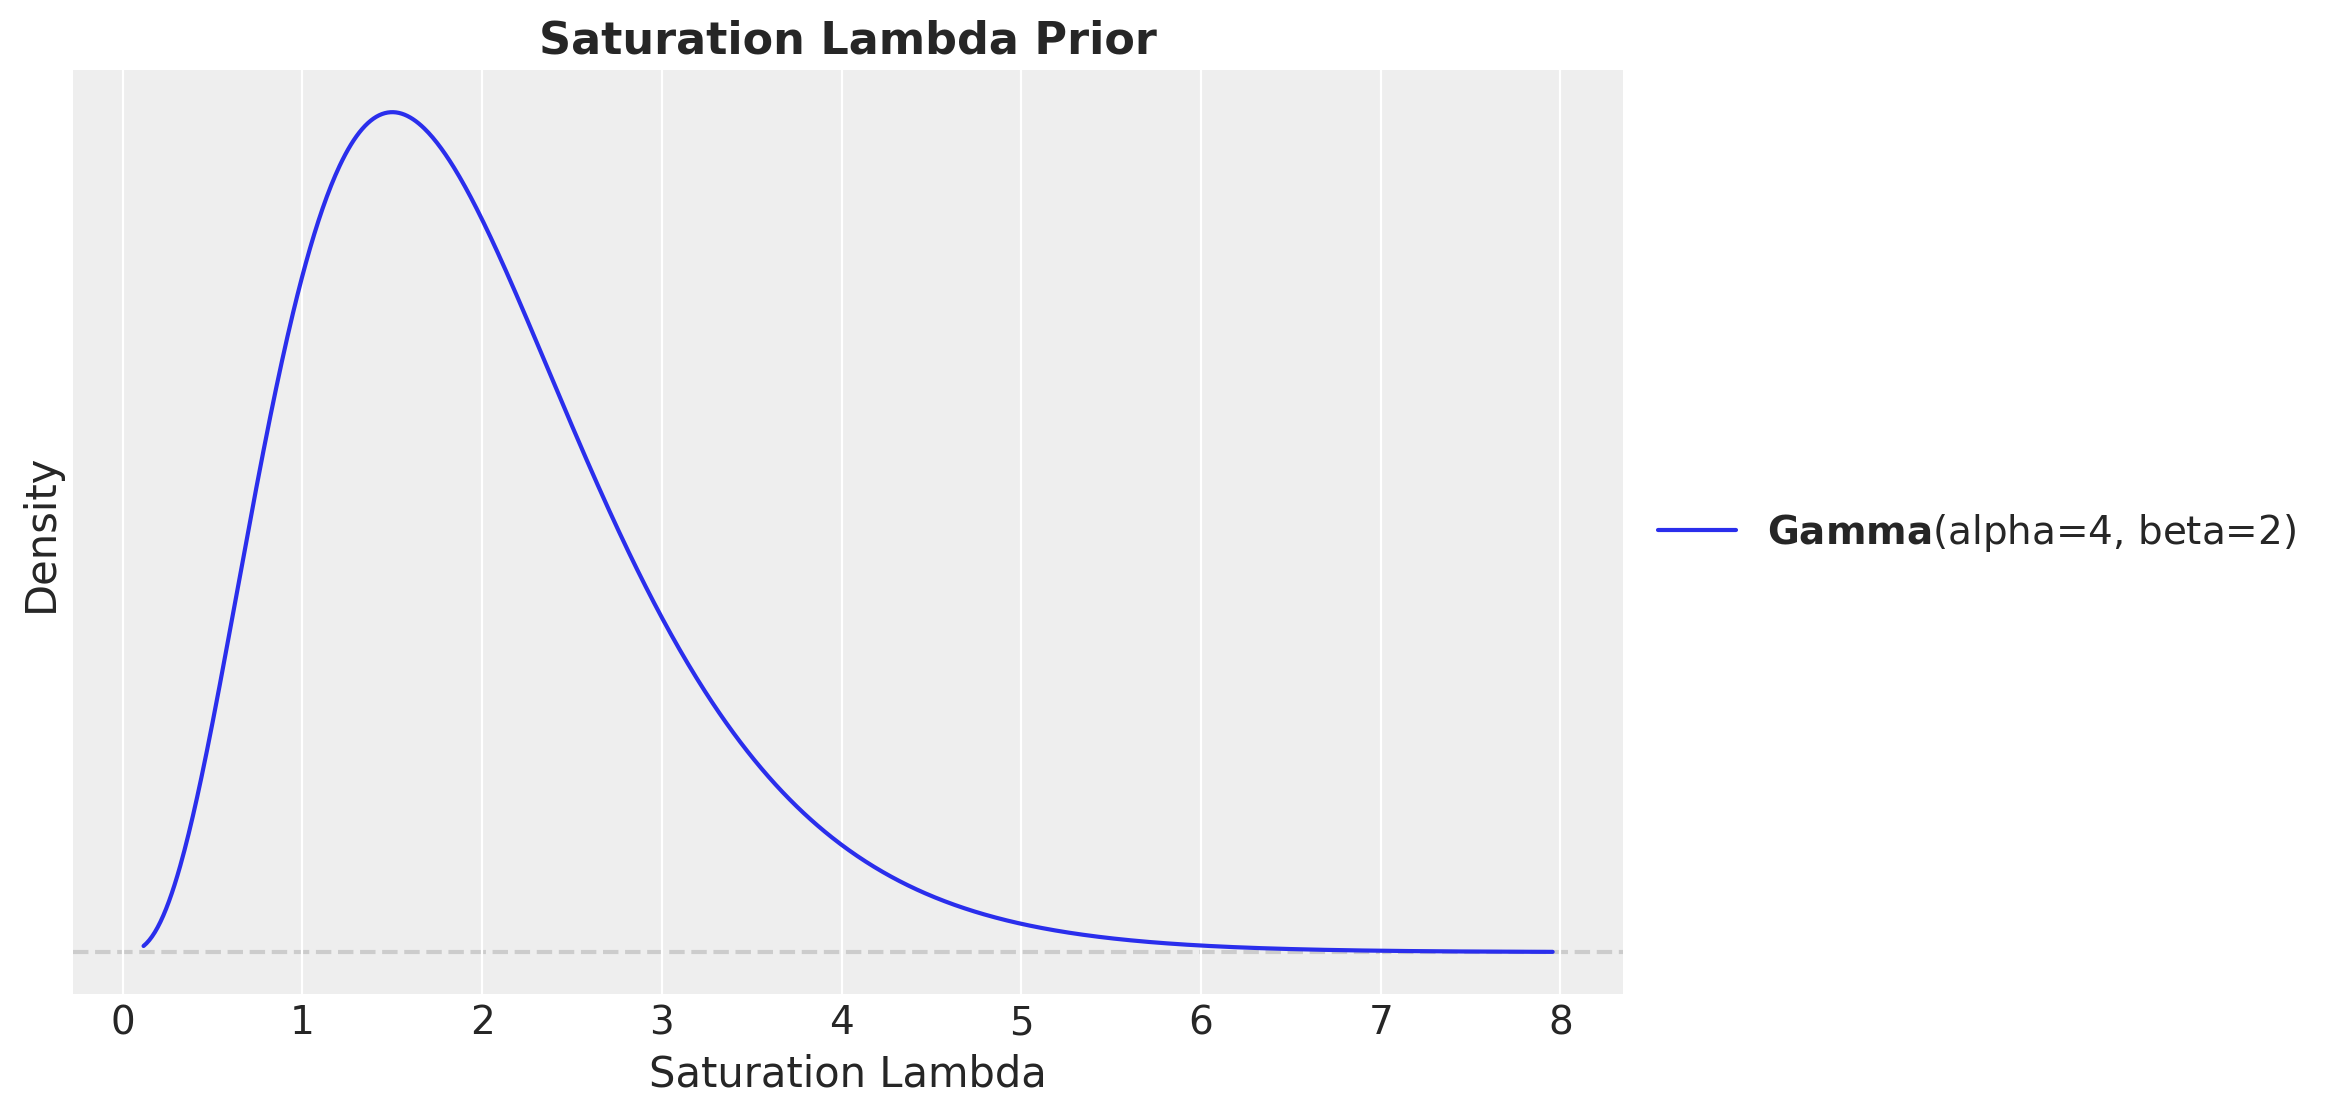

In [21]:
fig, ax = plt.subplots()
saturation_lam_prior = Prior("Gamma", alpha=4, beta=2)
saturation_lam_prior.preliz.plot_pdf(ax=ax)
ax.set(xlabel="Saturation Lambda", ylabel="Density")
ax.set_title("Saturation Lambda Prior", fontsize=16, fontweight="bold");

For the regression coefficients we can use the costs distributions. Without seeing the data is reasonable to expect the larger the channels (in terms of spend) the larger the effect (in terms of ROAS). This is not a constrain, but at least a starting point (we can also use the same priors for all the channels if we do not wanna make any assumption). We use the spend share as a proxy for the effect size trough the width of the prior (half normal distribution, as we want to ensure we have positive values).

In [22]:
channel_columns = ["x1", "x2"]

n_channels = len(channel_columns)

total_spend_per_channel = data_df[channel_columns].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

prior_sigma = n_channels * spend_share.to_numpy()

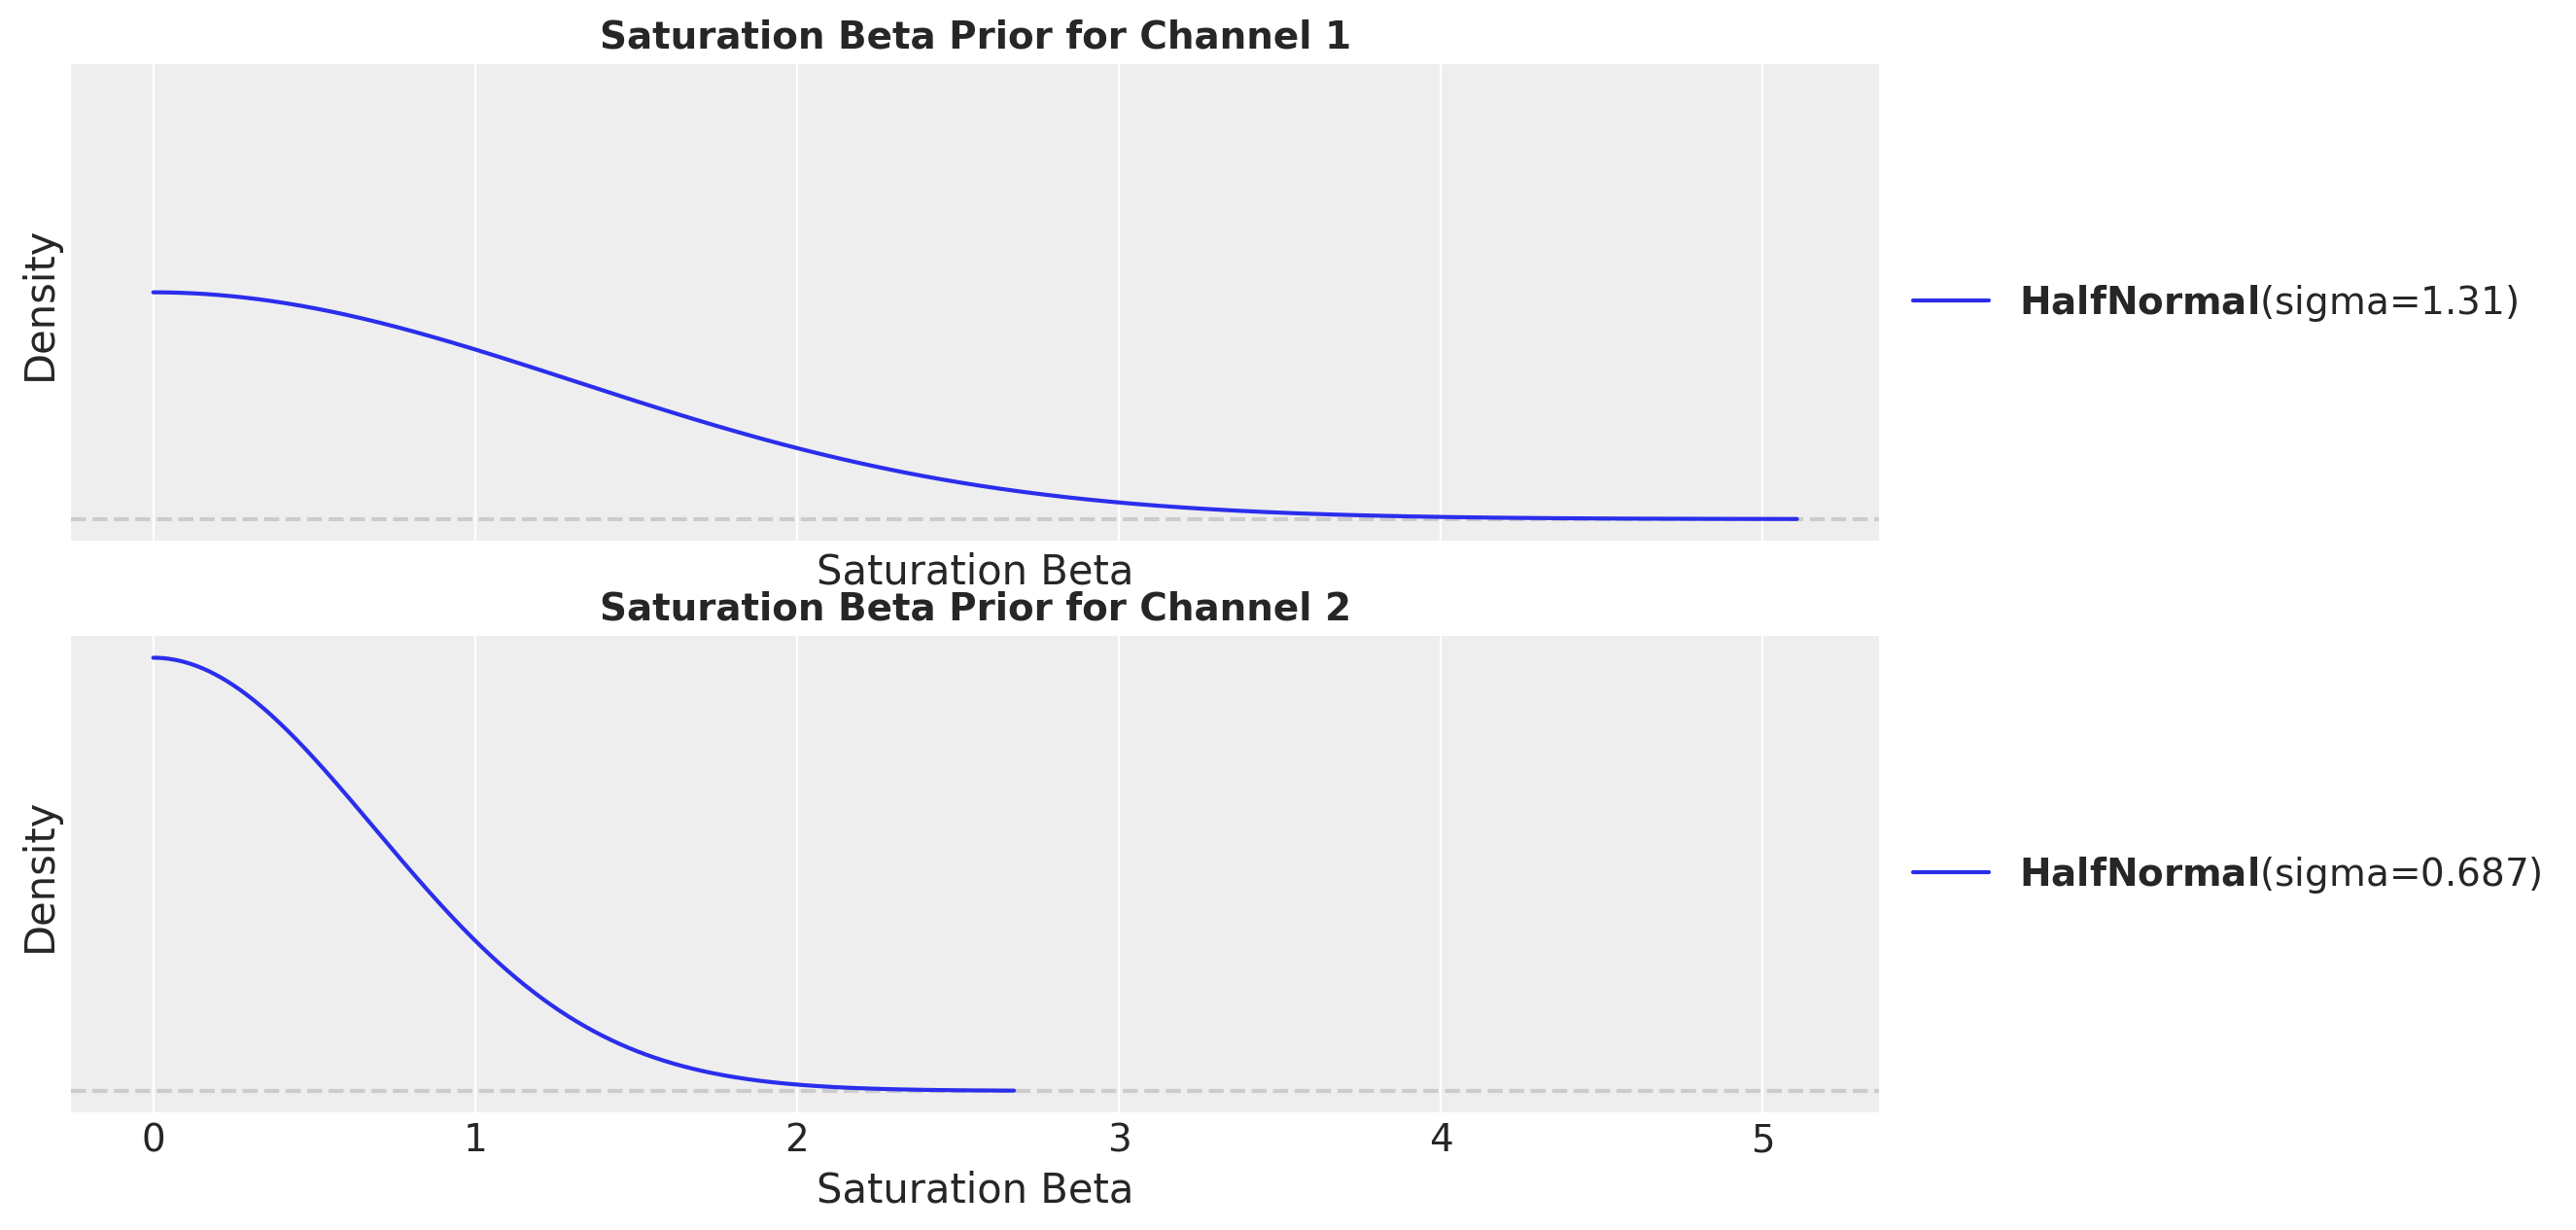

In [23]:
fig, ax = plt.subplots(
    nrows=n_channels,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, sigma in enumerate(prior_sigma):
    saturation_beta_prior = Prior("HalfNormal", sigma=sigma)
    saturation_beta_prior.preliz.plot_pdf(ax=ax[i])
    ax[i].set(xlabel="Saturation Beta", ylabel="Density")
    ax[i].set_title(
        f"Saturation Beta Prior for Channel {i+1}", fontsize=14, fontweight="bold"
    )

Similarly as above, we can look into the implications of the saturation parameter on the media effect.

Sampling: [channel_beta, channel_lam]
Sampling: []


Output()

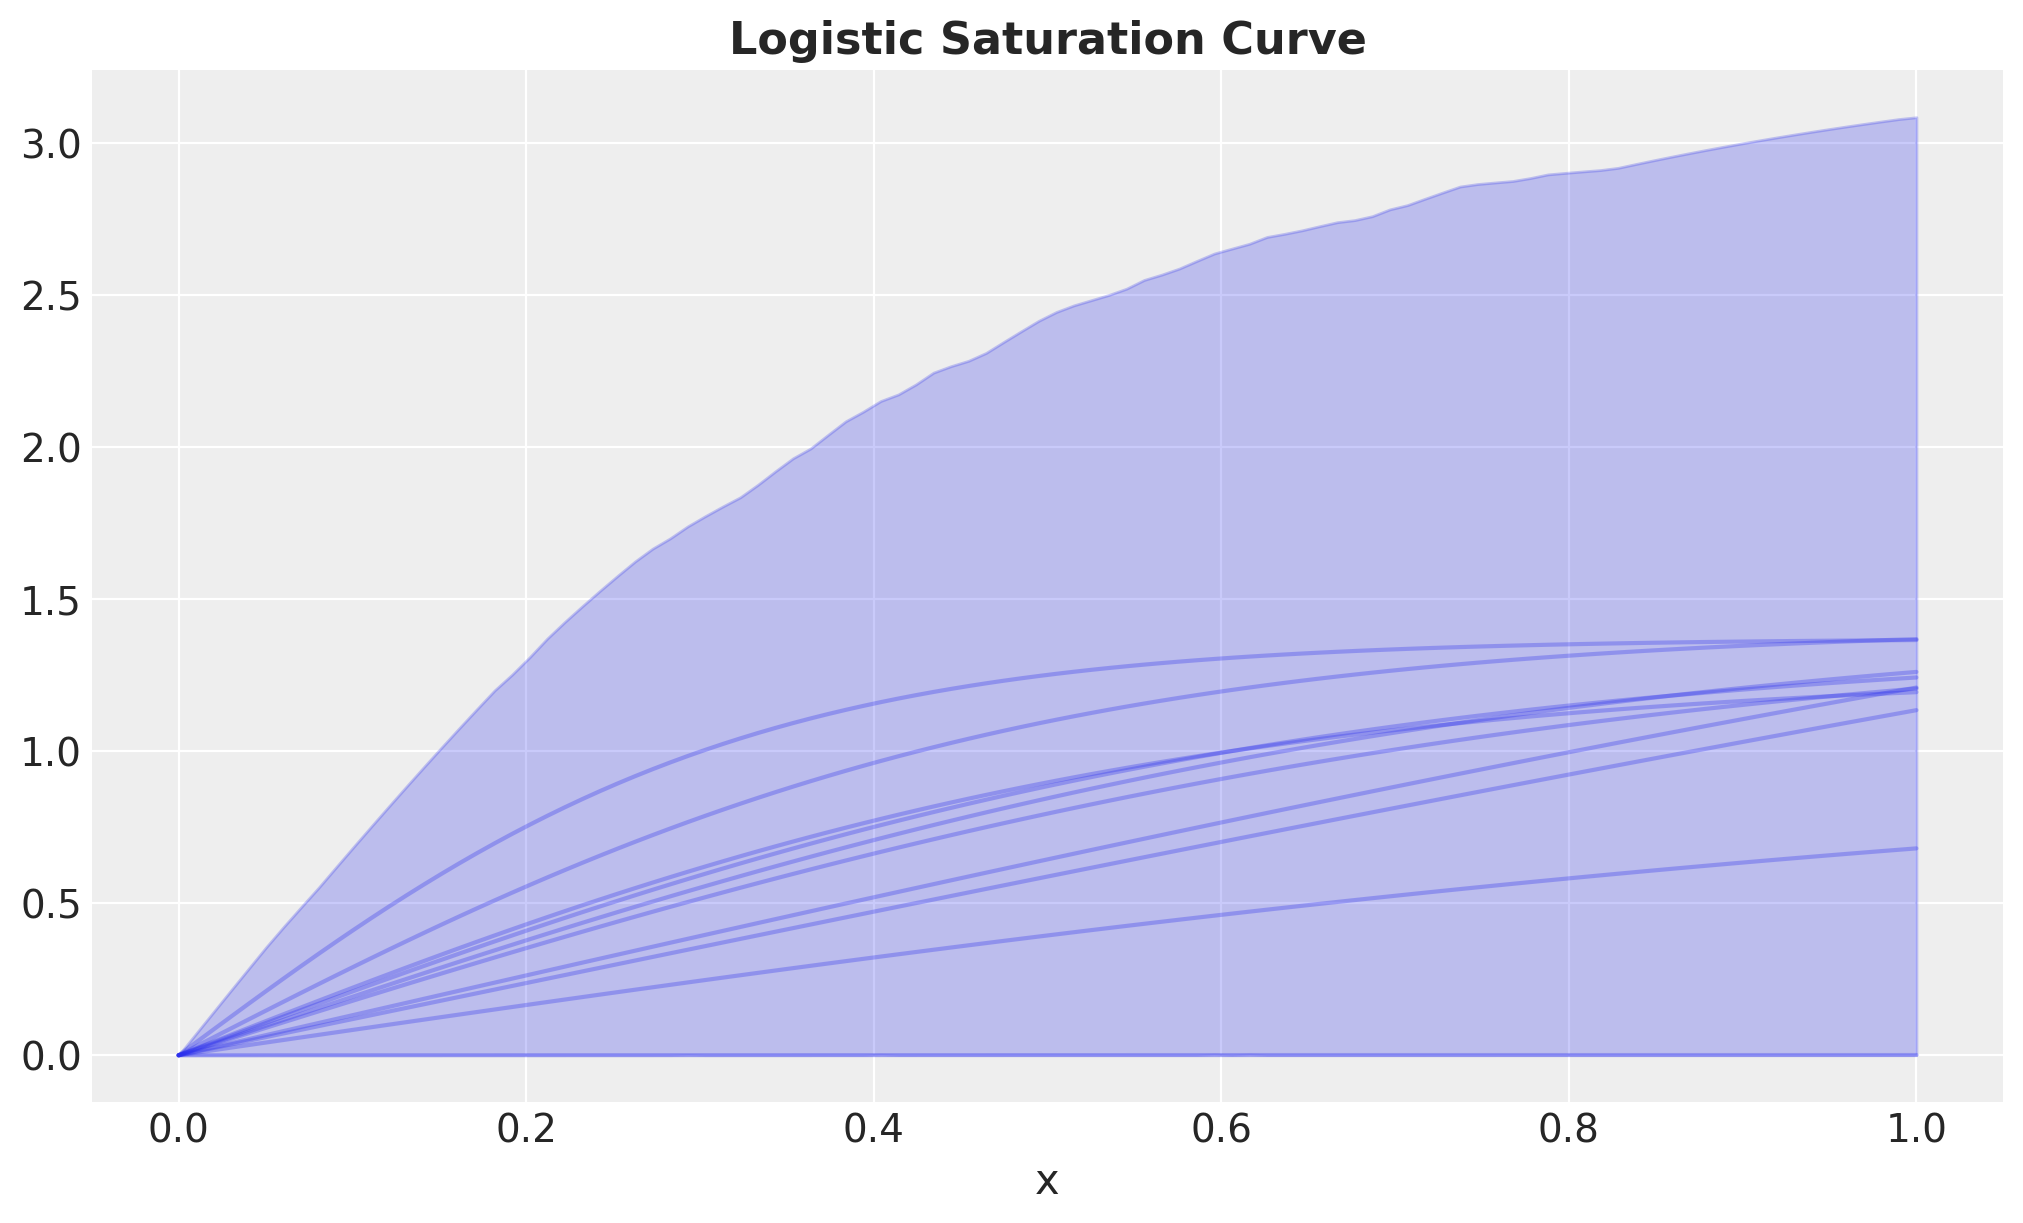

In [24]:
saturation = LogisticSaturation(
    priors={
        "saturation_lam": Prior("Gamma", alpha=4, beta=2),
        "saturation_beta": Prior("HalfNormal", sigma=prior_sigma),
    },
    prefix="channel",
)
prior = saturation.sample_prior(samples=1_000, random_seed=rng)
curve = saturation.sample_curve(prior)
fig, axes = saturation.plot_curve(curve, sample_kwargs={"rng": rng})
axes[0].set_title("Logistic Saturation Curve", fontsize=16, fontweight="bold");

These visualizations, together with the business context, can help us to set the priors for the media mix model! Make sure you make them part of your workflow.

### Priors on the Time-Varying Intercept

In contrast with the {ref}`mmm_example` notebook, we now include a time-varying intercept. This is a way to model the trend component of the data without assuming any specific functional form. We use a Hilbert Space Gaussian Process (HSGP) to model the time-varying intercept. If you are not familiar with HSGPs, please refer to the ["Gaussian Processes: HSGP Reference & First Steps"](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html) PyMC example notebook or the video ["A conceptual and practical introduction to Hilbert Space Gaussian Process (HSGP) approximation methods"](https://www.youtube.com/watch?v=SvefEqtoaxg).

As we will set priors on the length scales of the time component, we need to have in mind the number of data points we have:

In [25]:
data_df["date_week"].unique().size

179

The length scale parameter represents the distance between two points in the time series where we expect a change in the intercept. In our particular case, as we have weekly data and expect to capture a long term trend, we are want to consider length scales of around two or three weeks. The default prior for the length scale in PyMC-Marketing is an inverse gamma distribution. This distribution has many desirable properties: (1) is positive, (2) it goes to zero very fast (so we do not divide by zero) and (3) it has a long tail. In order to translate the length scale intuition into the inverse gamma parameters we can use a very handy function that maximizes the entropy of the distribution within a given expected interval:

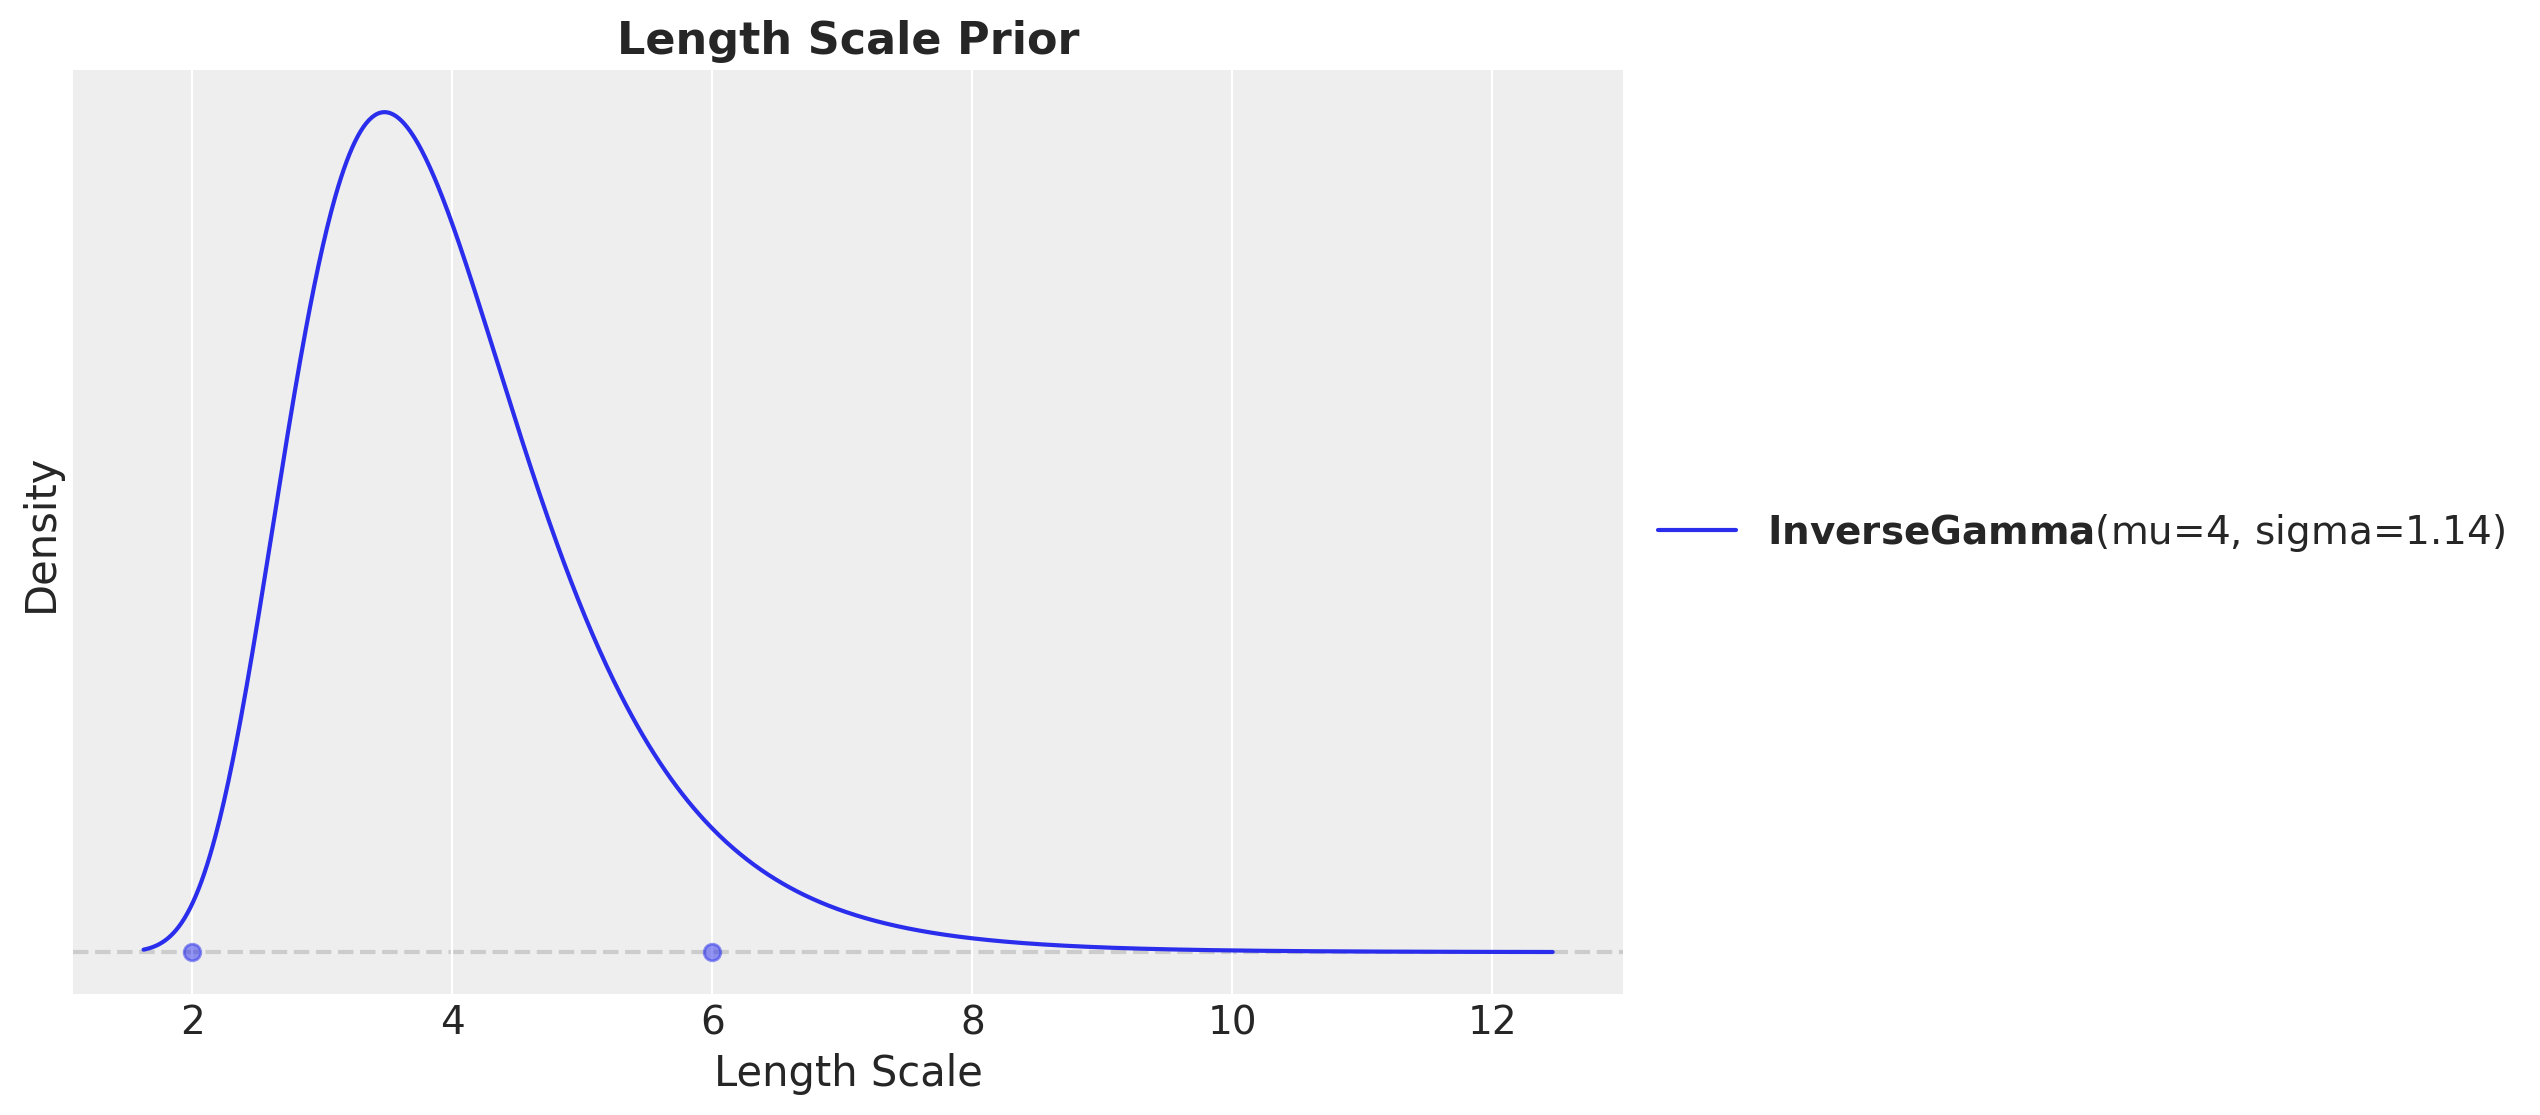

In [26]:
ls_inverse_gamma_distribution, ax = pz.maxent(
    # Distribution we want to consider.
    # We set the mean to 2.5 as we expect the length scale to be around two or three weeks.
    distribution=pz.InverseGamma(mu=4),
    # We set the probability range we want to cover when trying to find the best parameters.
    mass=0.94,
    # We hand the length scale interval to have a lower limit of two weeks.
    lower=2,
    # We set an upper limit of six weeks.
    upper=6,
)
ax.set(xlabel="Length Scale", ylabel="Density")
ax.set_title("Length Scale Prior", fontsize=16, fontweight="bold");

We also need to specify the amplitude of the Gaussian process. The default prior distribution in in PyMC-Marketing is an exponential distribution (note it has to be positive) As we are scaling the data, a good default is set this to one.

We can now encode these parameters into a {class}`HSGPKwargs <pymc_marketing.hsgp_kwargs.HSGPKwargs>` object.

In [27]:
hsgp_kwargs = HSGPKwargs(
    # m is the number of basis functions to use for the approximation.
    m=100,
    # This is the range we want to cover in the time series. As we have 179 points
    # it is always good to add more for the out of sample prediction.
    L=200,
    # This is the amplitude of the Gaussian process.
    eta_lam=1.0,
    # This is the mean of the length scale prior.
    # Note we extracted from the optimization result above
    ls_mu=ls_inverse_gamma_distribution.mu,
    # This is the standard deviation of the length scale prior.
    # Note we extracted from the optimization result above
    ls_sigma=ls_inverse_gamma_distribution.sigma,
)

### Media Mix Model Prior Configuration

We can do similar analysis for the rest of the components and pass our custom priors to the {class}`MMM <pymc_marketing.mmm.mmm.MMM>` class as a dictionary configuration.

In [28]:
my_model_config = {
    # Intercept: This we can see by looking into the (scaled!) data.
    "intercept": Prior("Normal", mu=0.5, sigma=0.1),
    # Control variables: We expect a mild trend component and effect of events.
    "gamma_control": Prior("Normal", mu=0, sigma=0.2),
    # Fourier terms: We expect a yearly seasonality.
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2),
    # Media parameters (see previous sections)
    "adstock_alpha": Prior("Beta", alpha=2, beta=3),
    "saturation_beta": Prior("HalfNormal", sigma=prior_sigma),
    "saturation_lam": Prior("Gamma", alpha=4, beta=2, dims="channel"),
    # Time-varying intercept: We set the HSGP configuration.
    "intercept_tvp_config": hsgp_kwargs,
    # Likelihood: We expect the data to be normally distributed and we set the scale
    # by looking into the (scaled!) data and expected deviations from the mean.
    "likelihood": Prior("Normal", sigma=Prior("Exponential", lam=1 / 0.5)),
}

Having the configuration, we can now initialize the model object:

In [29]:
mmm = MMM(
    model_config=my_model_config,
    date_column="date_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=channel_columns,
    control_columns=["event_1", "event_2"],
    time_varying_intercept=True,
    yearly_seasonality=2,
)

### Prior Predictive Sampling

With the model initialized, we can now sample from the prior predictive distribution.

In [30]:
X = data_df.drop("y", axis=1)
y = data_df["y"]

# Generate prior predictive samples
_ = mmm.sample_prior_predictive(X, y, samples=2_000)

Sampling: [adstock_alpha, baseline_intercept, gamma_control, gamma_fourier, intercept_temporal_latent_multiplier_raw_eta, intercept_temporal_latent_multiplier_raw_hsgp_coefs_offset, intercept_temporal_latent_multiplier_raw_ls, saturation_beta, saturation_lam, y, y_sigma]


Let's start by looking into the expected sales (remember this is before fitting the model).

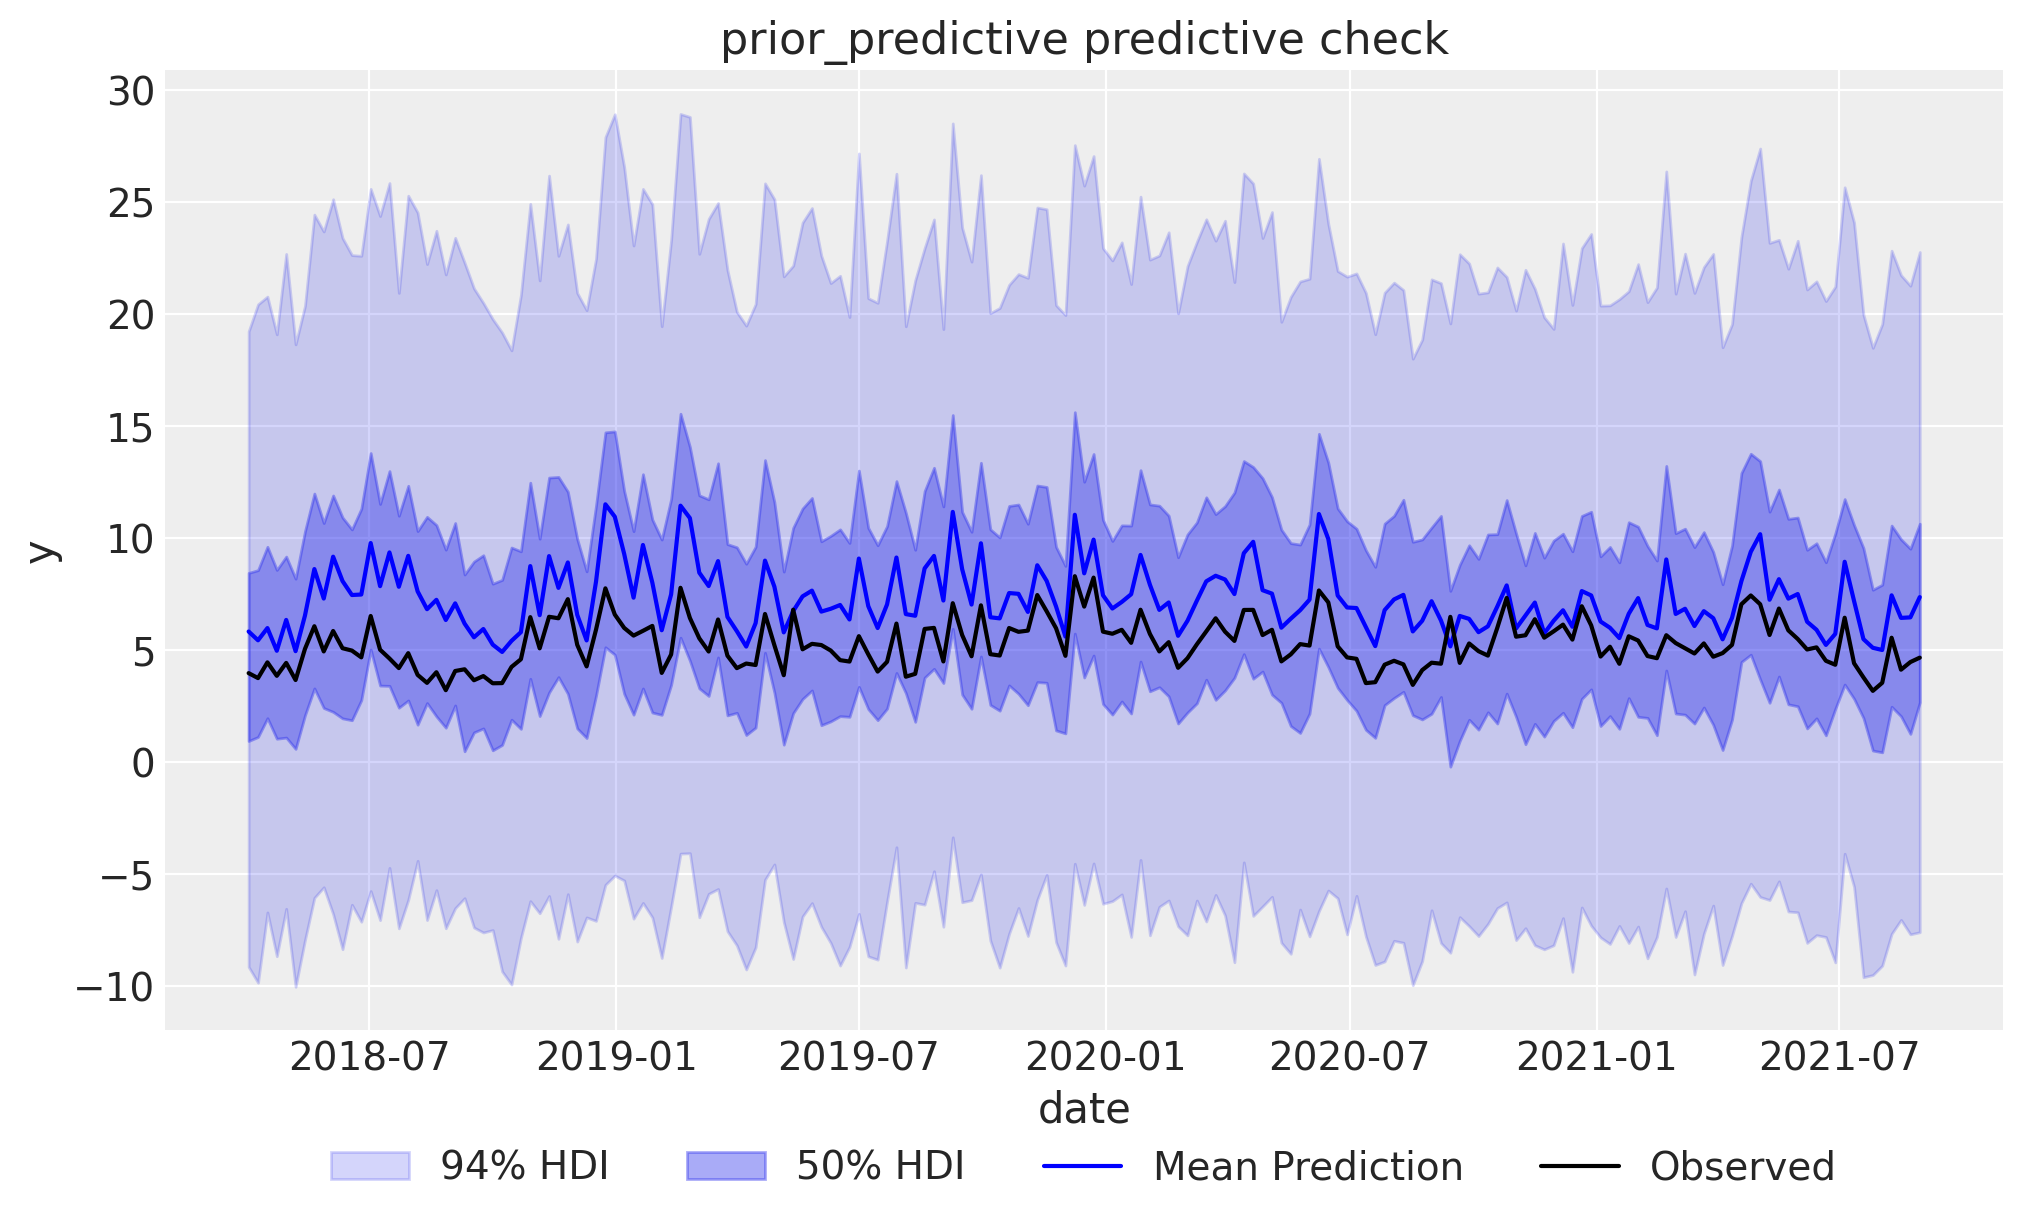

In [31]:
fig, ax = plt.subplots()
mmm.plot_prior_predictive(ax=ax, original_scale=True)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4);

The range covers our seen data and it ios in the same order of magnitude (tenths).

It is always good to look the Gaussian process components:

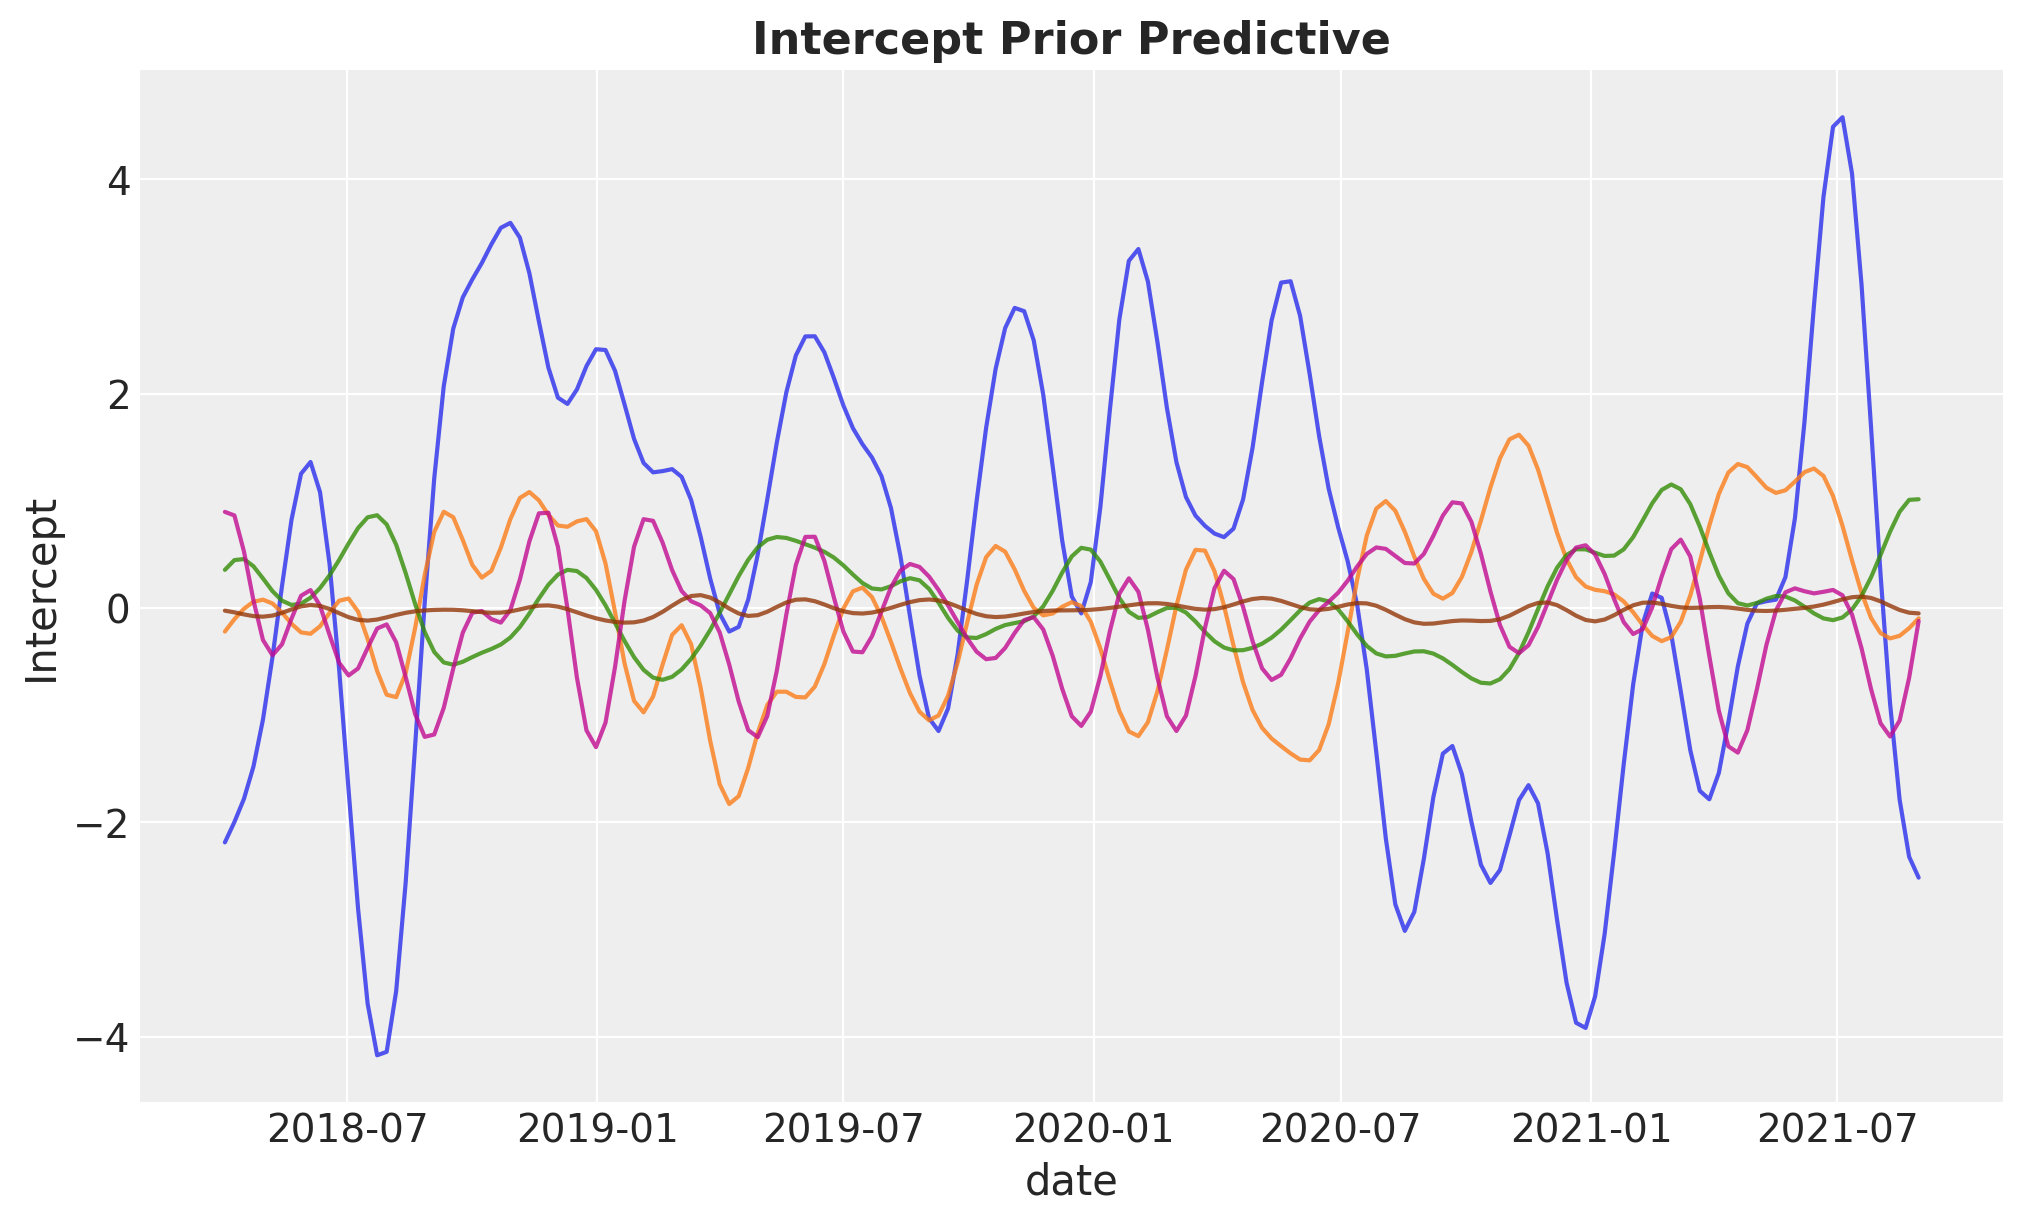

In [32]:
fig, ax = plt.subplots()


for draw in range(5):
    ax.plot(
        mmm.prior.coords["date"],
        mmm.prior["intercept_temporal_latent_multiplier_raw"].sel(chain=0, draw=draw),
        alpha=0.8,
    )
ax.set(xlabel="date", ylabel="Intercept")
ax.set_title("Intercept Prior Predictive", fontsize=16, fontweight="bold");

We confirm that the level of fluctuations is tin the order of months, as expected.

Next, we can look into the channel ROAS, which is what we want to understand. We simply compute them by dividing the channel contribution by the spend.


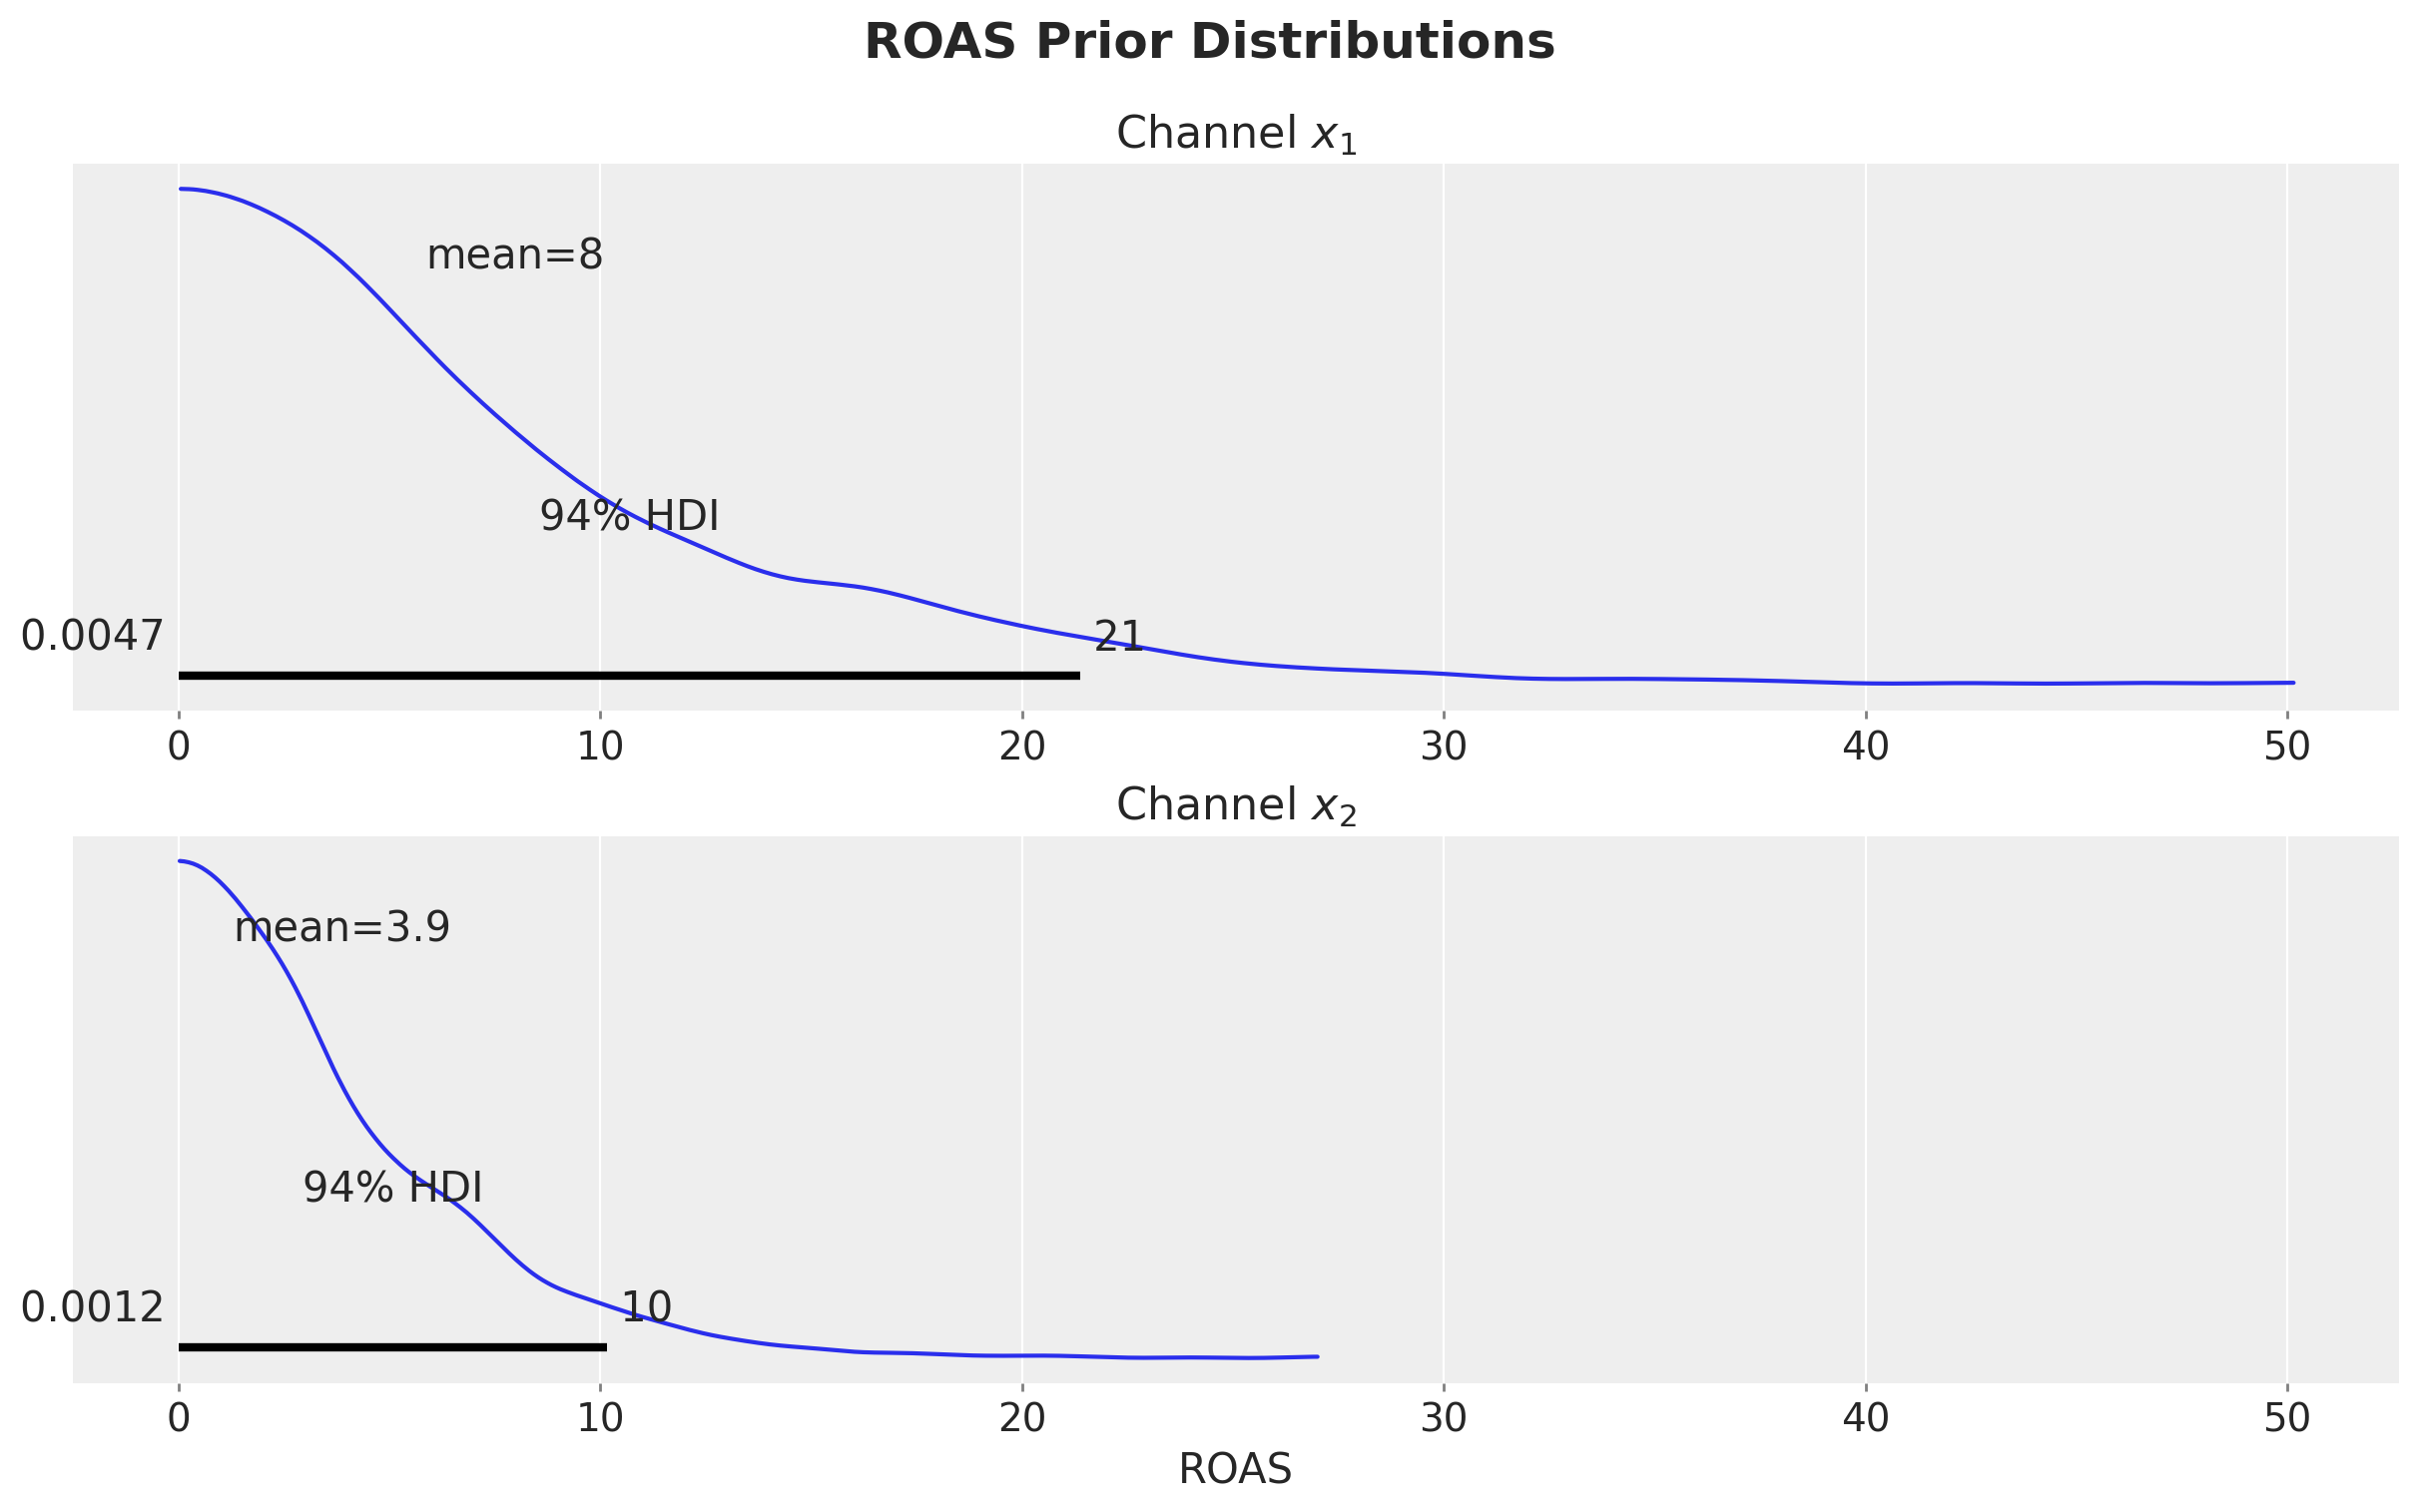

In [33]:
prior_channel_contribution_original_scale = (
    mmm.compute_channel_contribution_original_scale(prior=True)
)

spend_sum = X[channel_columns].sum().to_numpy()

prior_roas_samples = (
    prior_channel_contribution_original_scale.sum(dim="date")
    / spend_sum[np.newaxis, np.newaxis, :]
)

fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
az.plot_posterior(prior_roas_samples, ax=axes)
axes[0].set(title="Channel $x_{1}$")
axes[1].set(title="Channel $x_{2}$", xlabel="ROAS")
fig.suptitle("ROAS Prior Distributions", fontsize=18, fontweight="bold", y=1.06);

As expected, the ROAS are positive! Moreover, for our particular case, the set of plausible values are very reasonable (as we own the simulation 😉). We can not stress enough how important this step is! If the expected ROAS are not reasonable, before seeing the data it is most likely that the model will not fit the data well. Also, conceptually the model would be very flawed. So if you take anything from this notebook, please always do prior predictive checks on the quantities you want to infer 🙂.


```{warning}
There is a little detail regarding the computation of the ROAS as we are not considering the adstock contributions and we should be more precise about the time intervals, see formula (10) in ["Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects"](https://research.google/pubs/bayesian-methods-for-media-mix-modeling-with-carryover-and-shape-effects/). We do not want to get lost in details here because our goal is to show the prior predictive sampling and we expect this small correction to have little impact on this example.
```

### Model Fit

We are ready to fit the model to the data.

In [34]:
_ = mmm.fit(
    X=X,
    y=y,
    target_accept=0.85,
    chains=4,
    draws=2_000,
    nuts_sampler="numpyro",
    random_seed=rng,
)
_ = mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

2025-01-09 12:06:05.492781: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce = f64[4,2000,100]{2,1,0} reduce(f64[4,2000,1,100]{3,2,1,0} %broadcast.30, f64[] %constant.38), dimensions={2}, to_apply=%region_0.70, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod" source_file="/var/folders/p5/ndc9d2b90_x9vnt8nzzygcb00000gp/T/tmpz8lar4a5" source_line=31}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-01-09 12:06:06.643286: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.155551s
Constant folding an instruction is taking > 1s:

  %reduce = 

Output()

In [35]:
# No divergences!
mmm.idata["sample_stats"]["diverging"].sum().item()

0

For more model diagnostics and error analysis, please refer to the {ref}`mmm_example` notebook.

### Posterior Predictive Sampling

Finally, we can look into the posterior predictive distribution. 

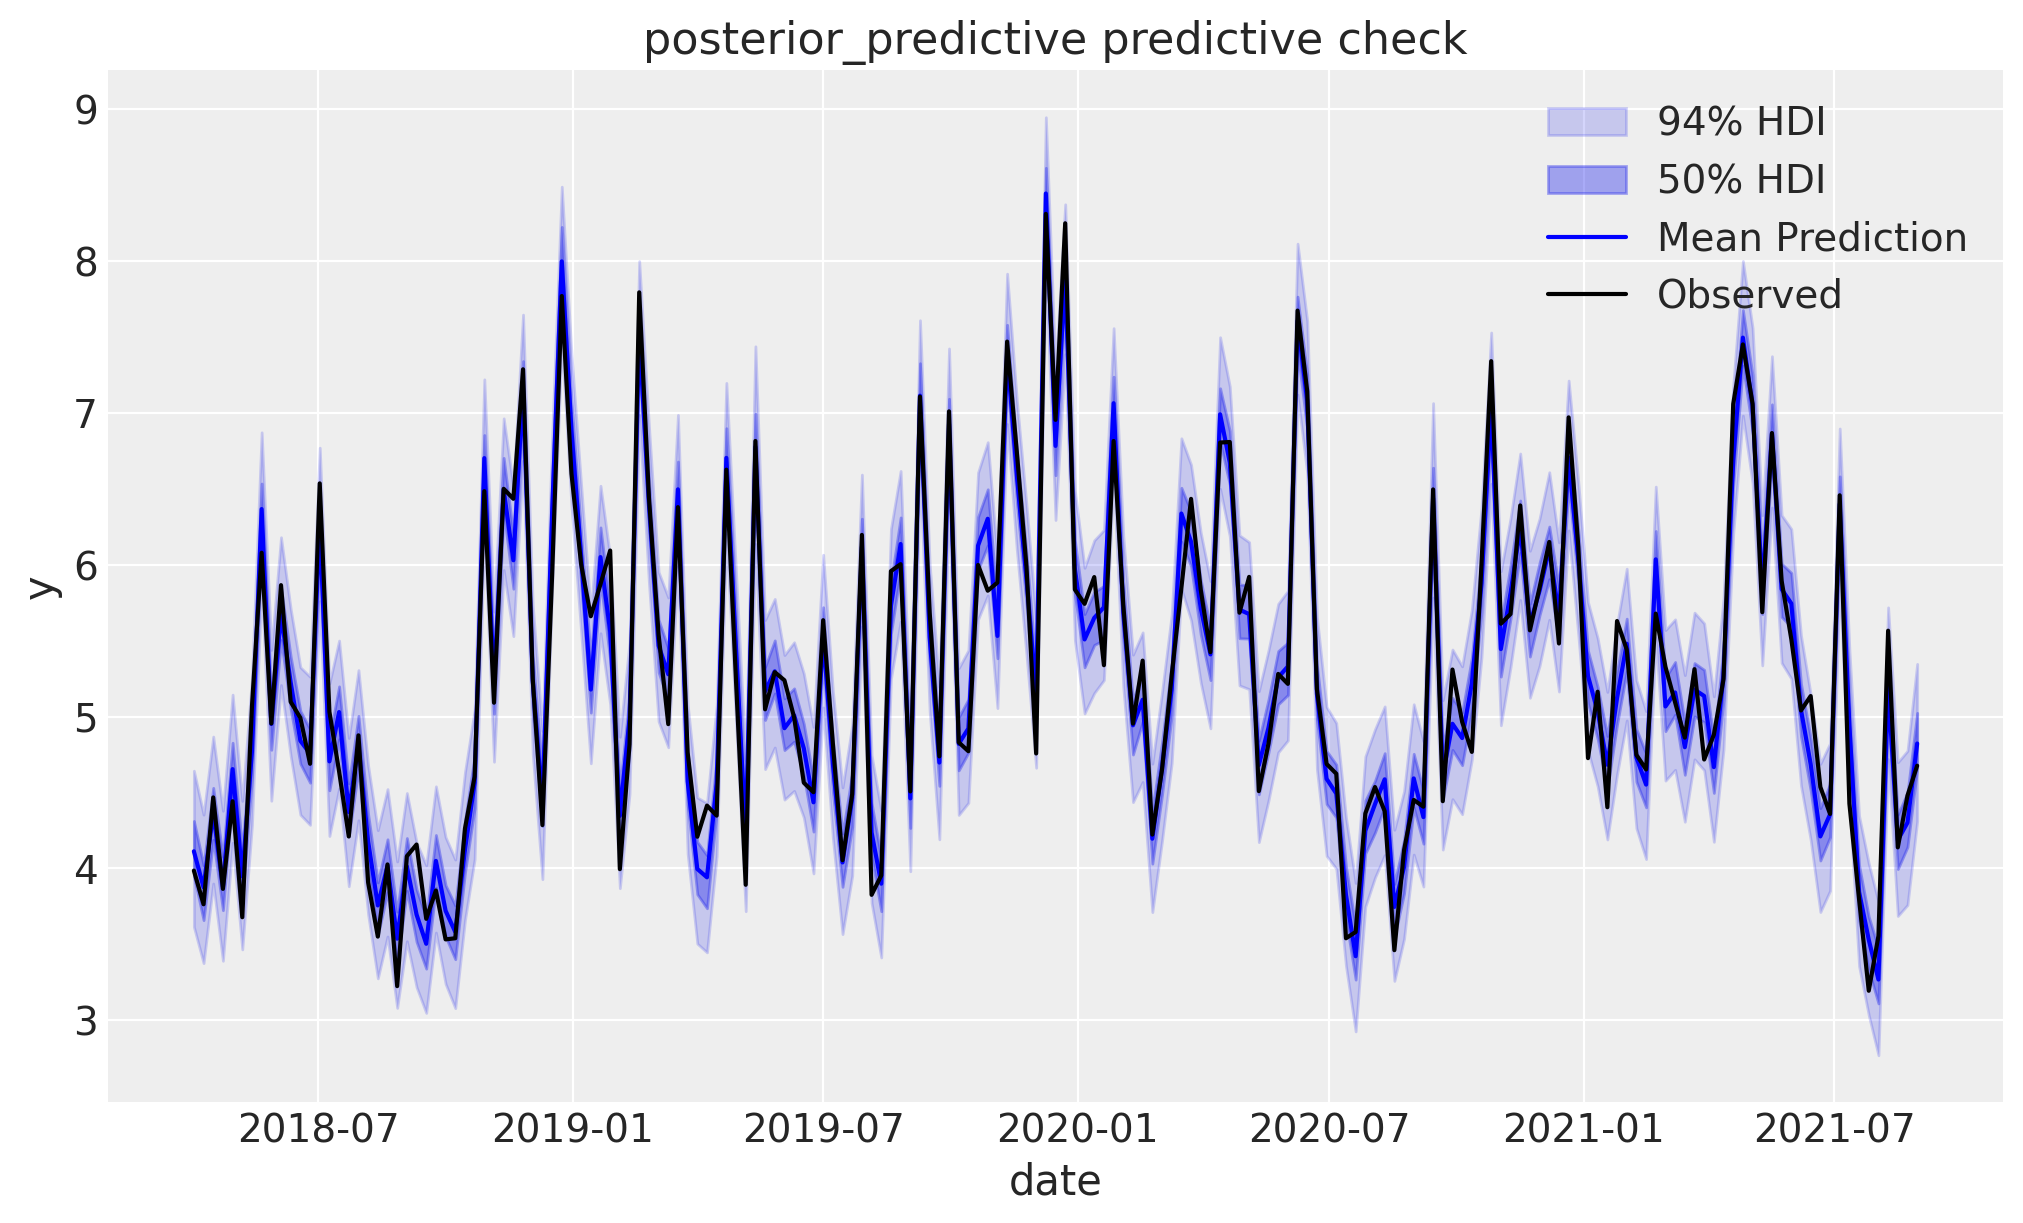

In [36]:
mmm.plot_posterior_predictive(original_scale=True);

The fitted sales data looks very good! 

We can not look into the model components:

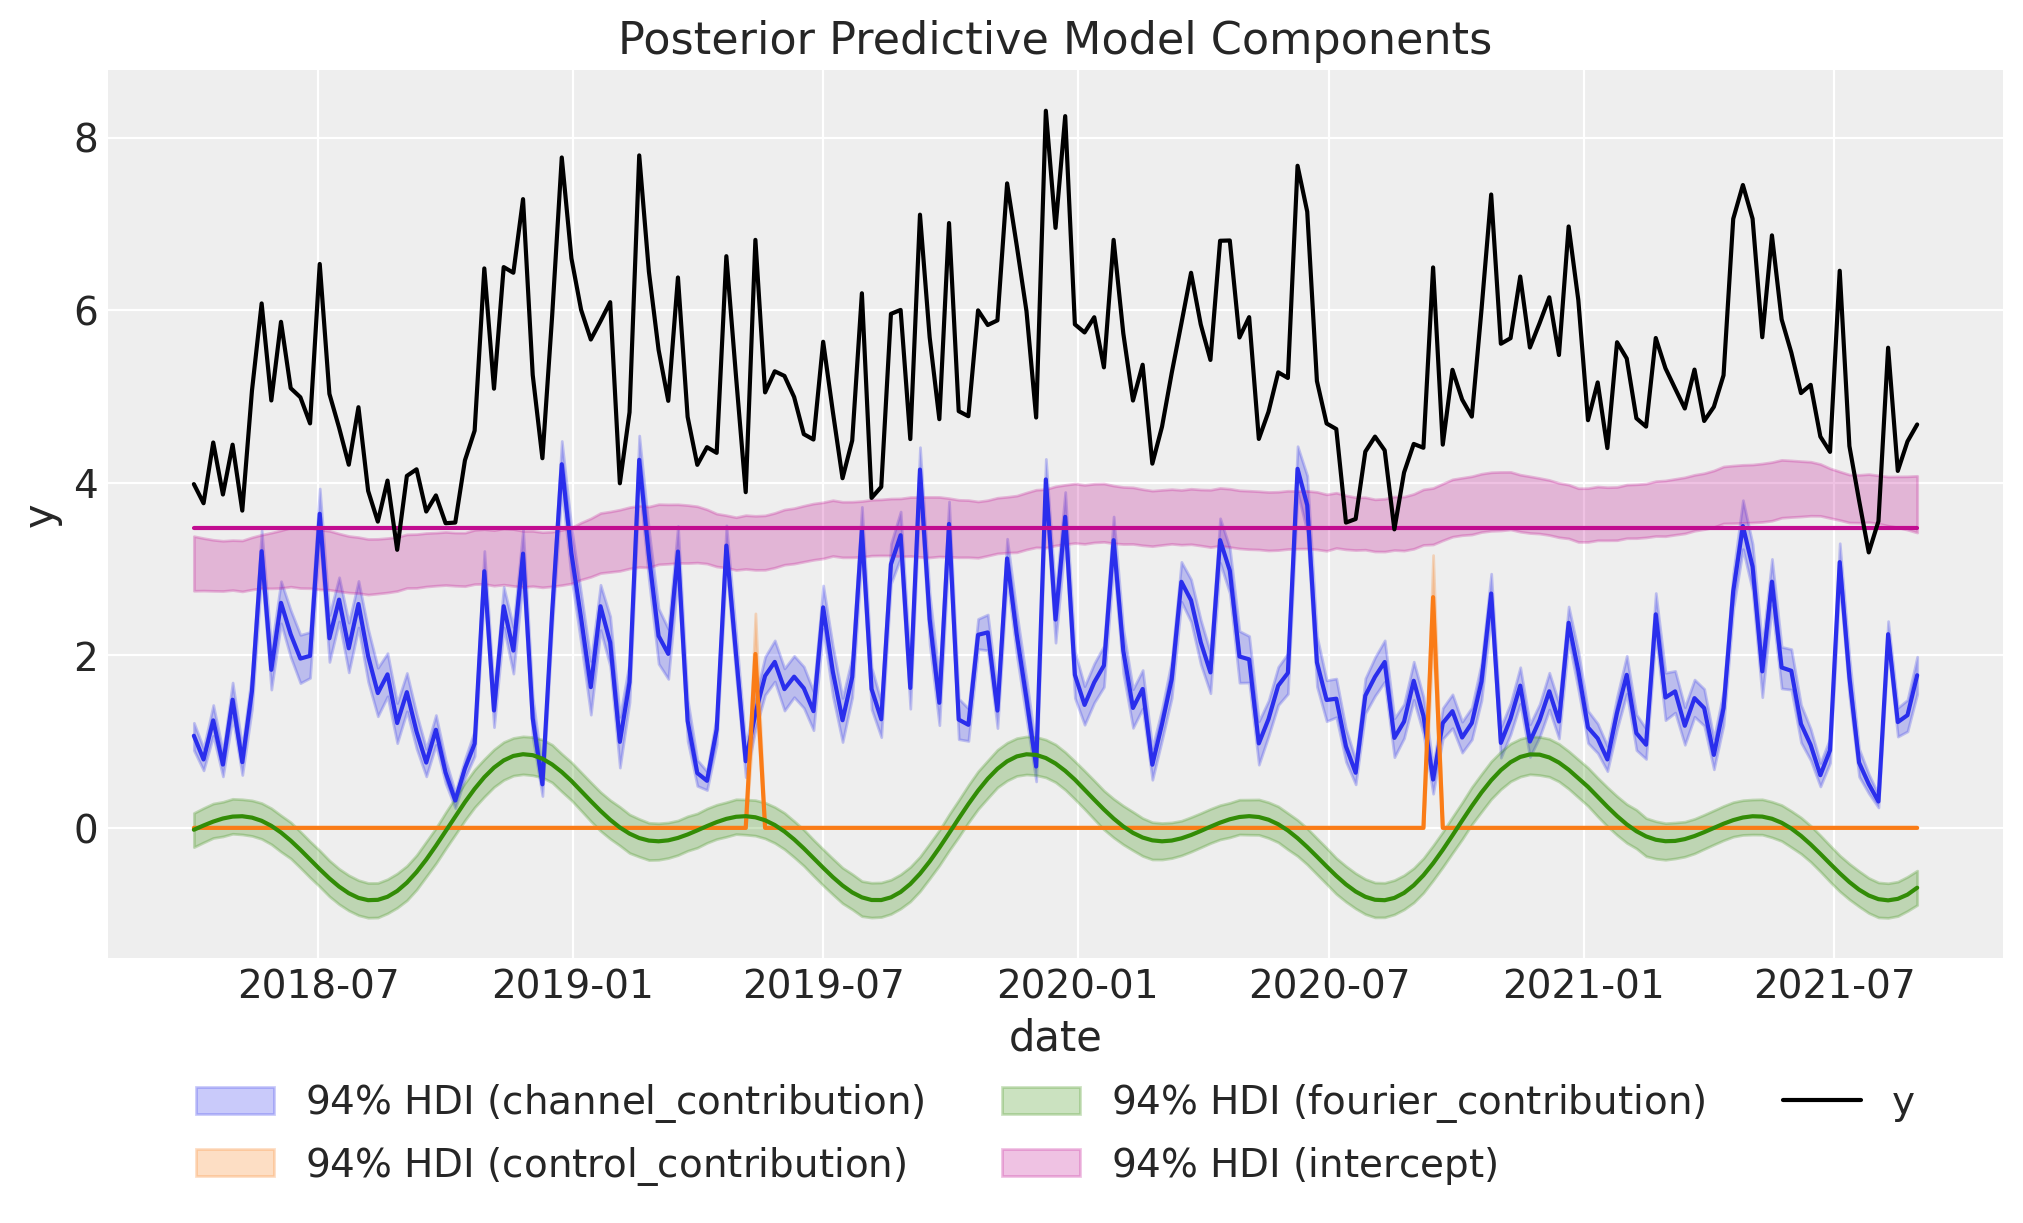

In [37]:
mmm.plot_components_contributions(original_scale=True);

Wee see how the model has captured a mild trend and a nice yearly seasonality component. The results look very consistent with the {ref}`mmm_example` notebook.



Let's look into the channel ROAS.

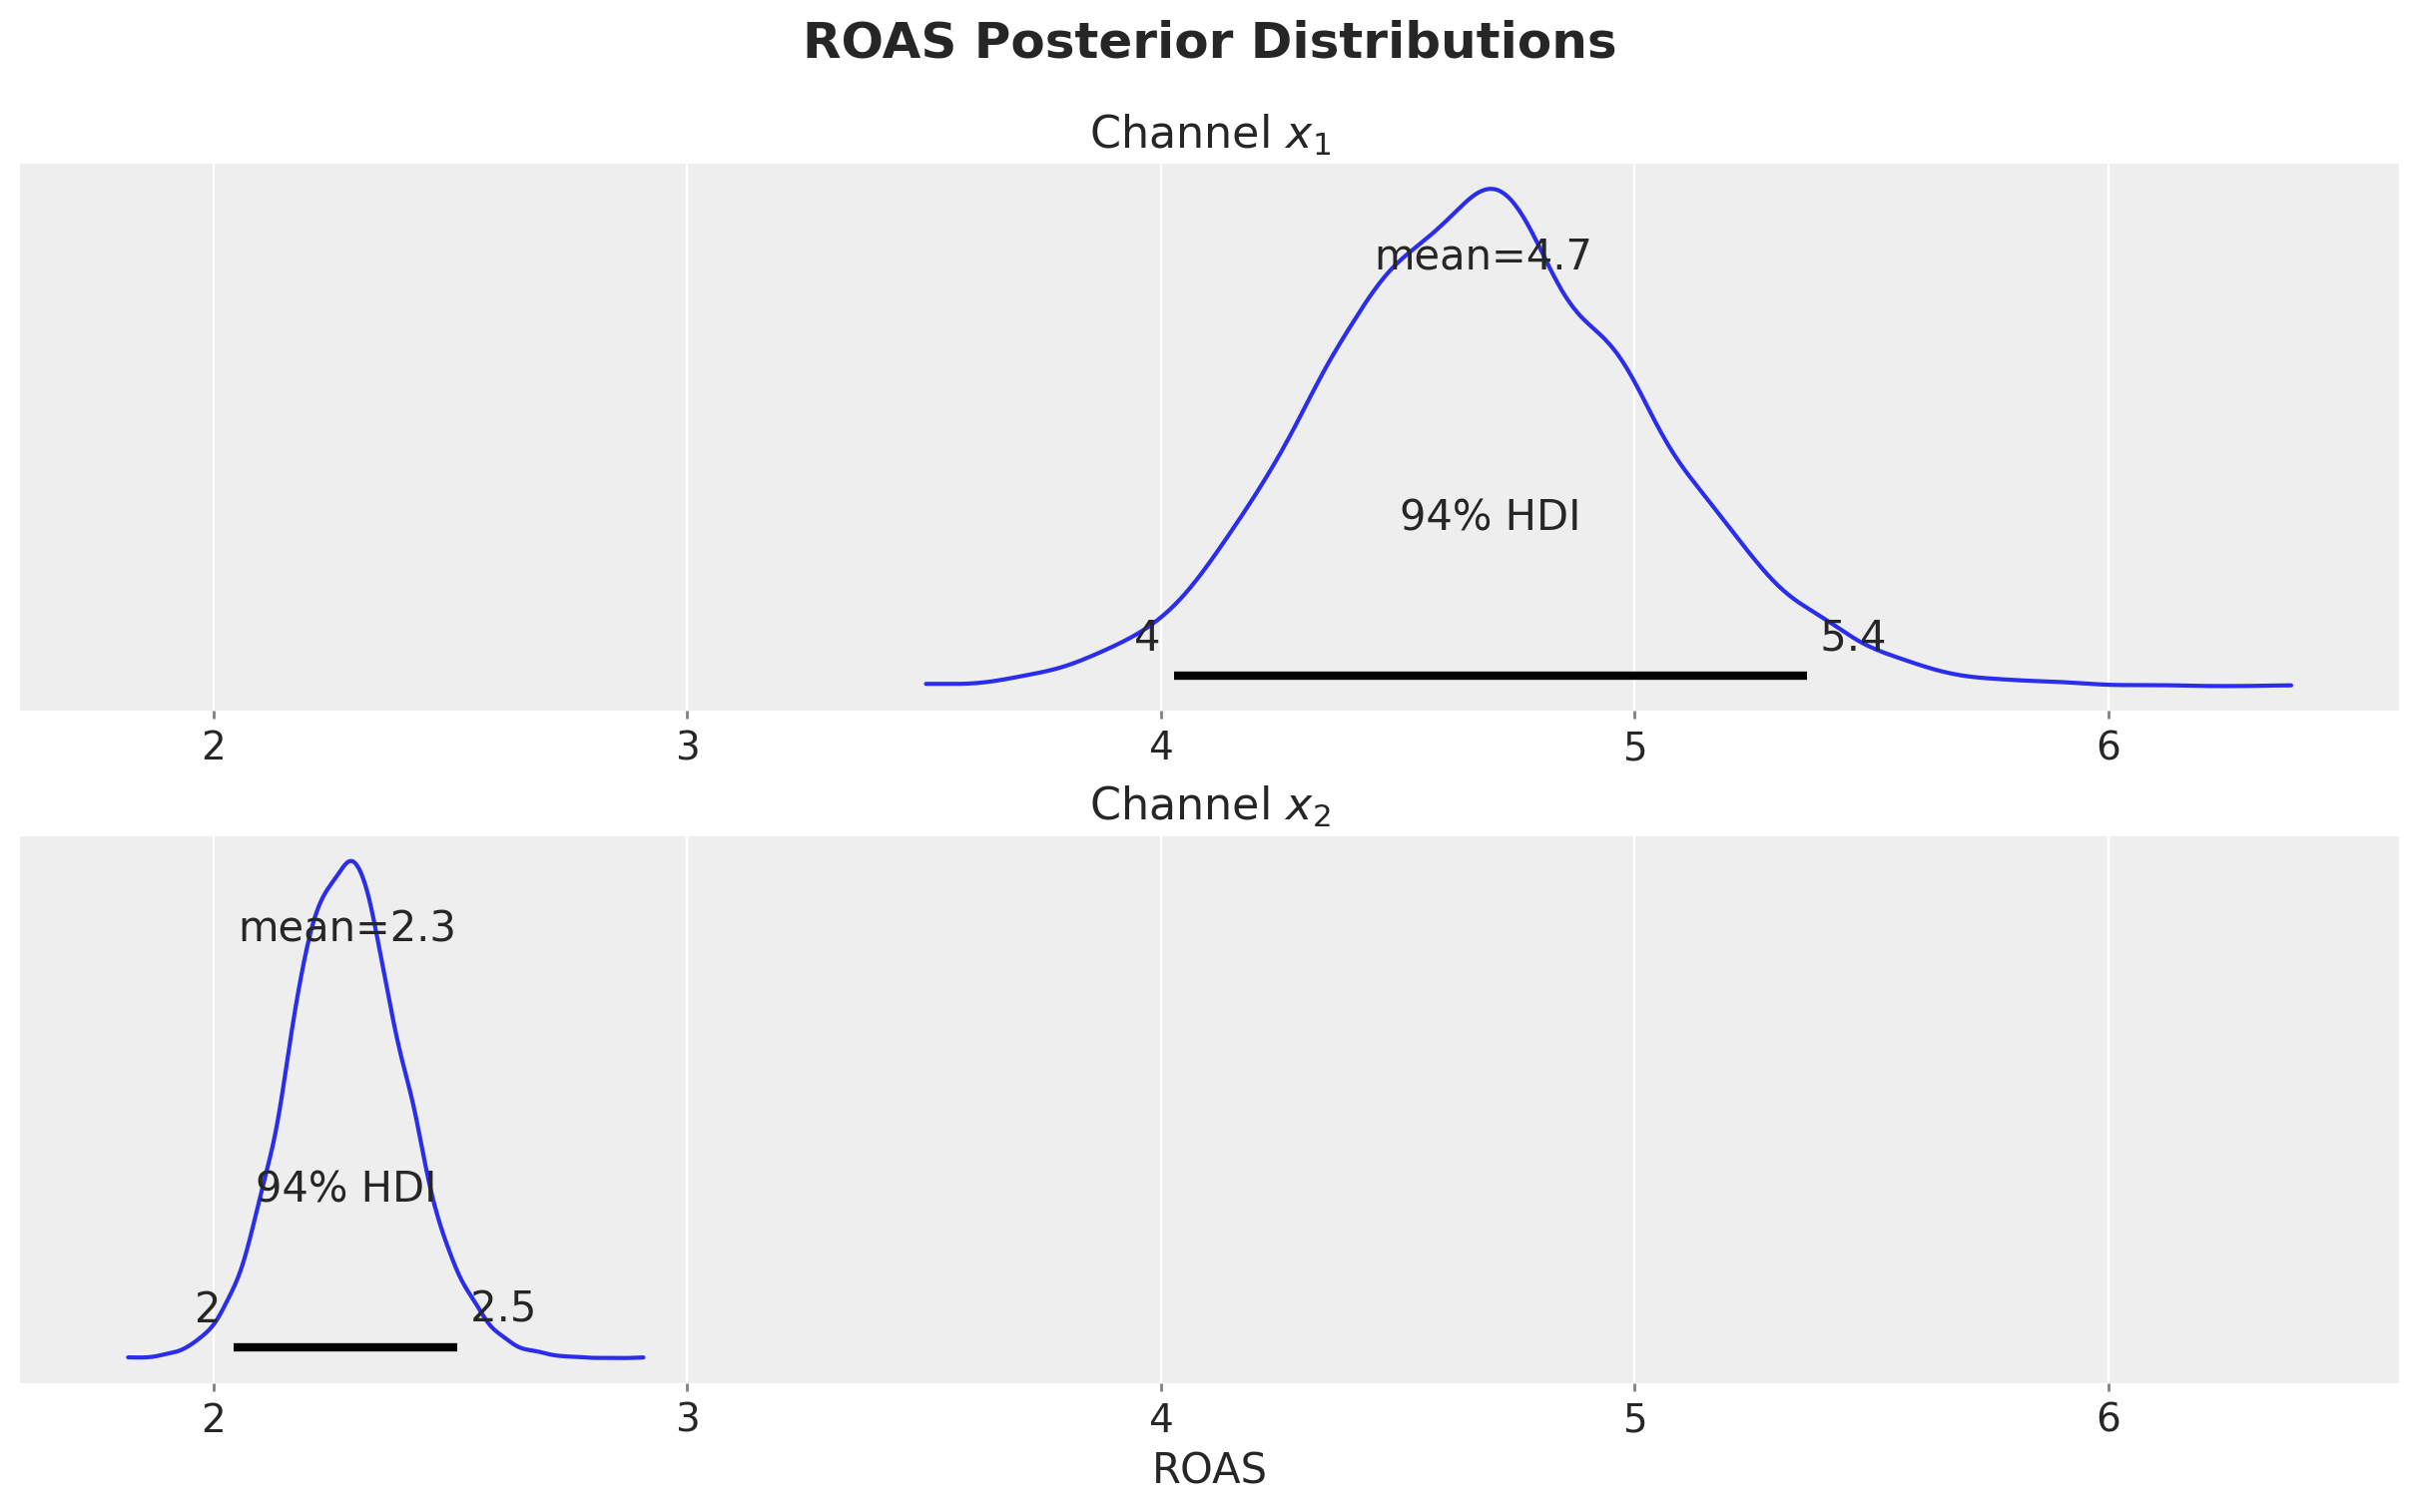

In [38]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale(
    prior=False
)

roas_samples = (
    channel_contribution_original_scale.sum(dim="date")
    / spend_sum[np.newaxis, np.newaxis, :]
)

fig, axes = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
az.plot_posterior(roas_samples, ax=axes)
axes[0].set(title="Channel $x_{1}$")
axes[1].set(title="Channel $x_{2}$", xlabel="ROAS")
fig.suptitle("ROAS Posterior Distributions", fontsize=18, fontweight="bold", y=1.06);

These are the same as the one obtained in the {ref}`mmm_example` notebook (and therefore close to the true values).

A final tip is to compare the prior and posterior ROAS distributions. This can help us to understand the impact of the data on the parameters.

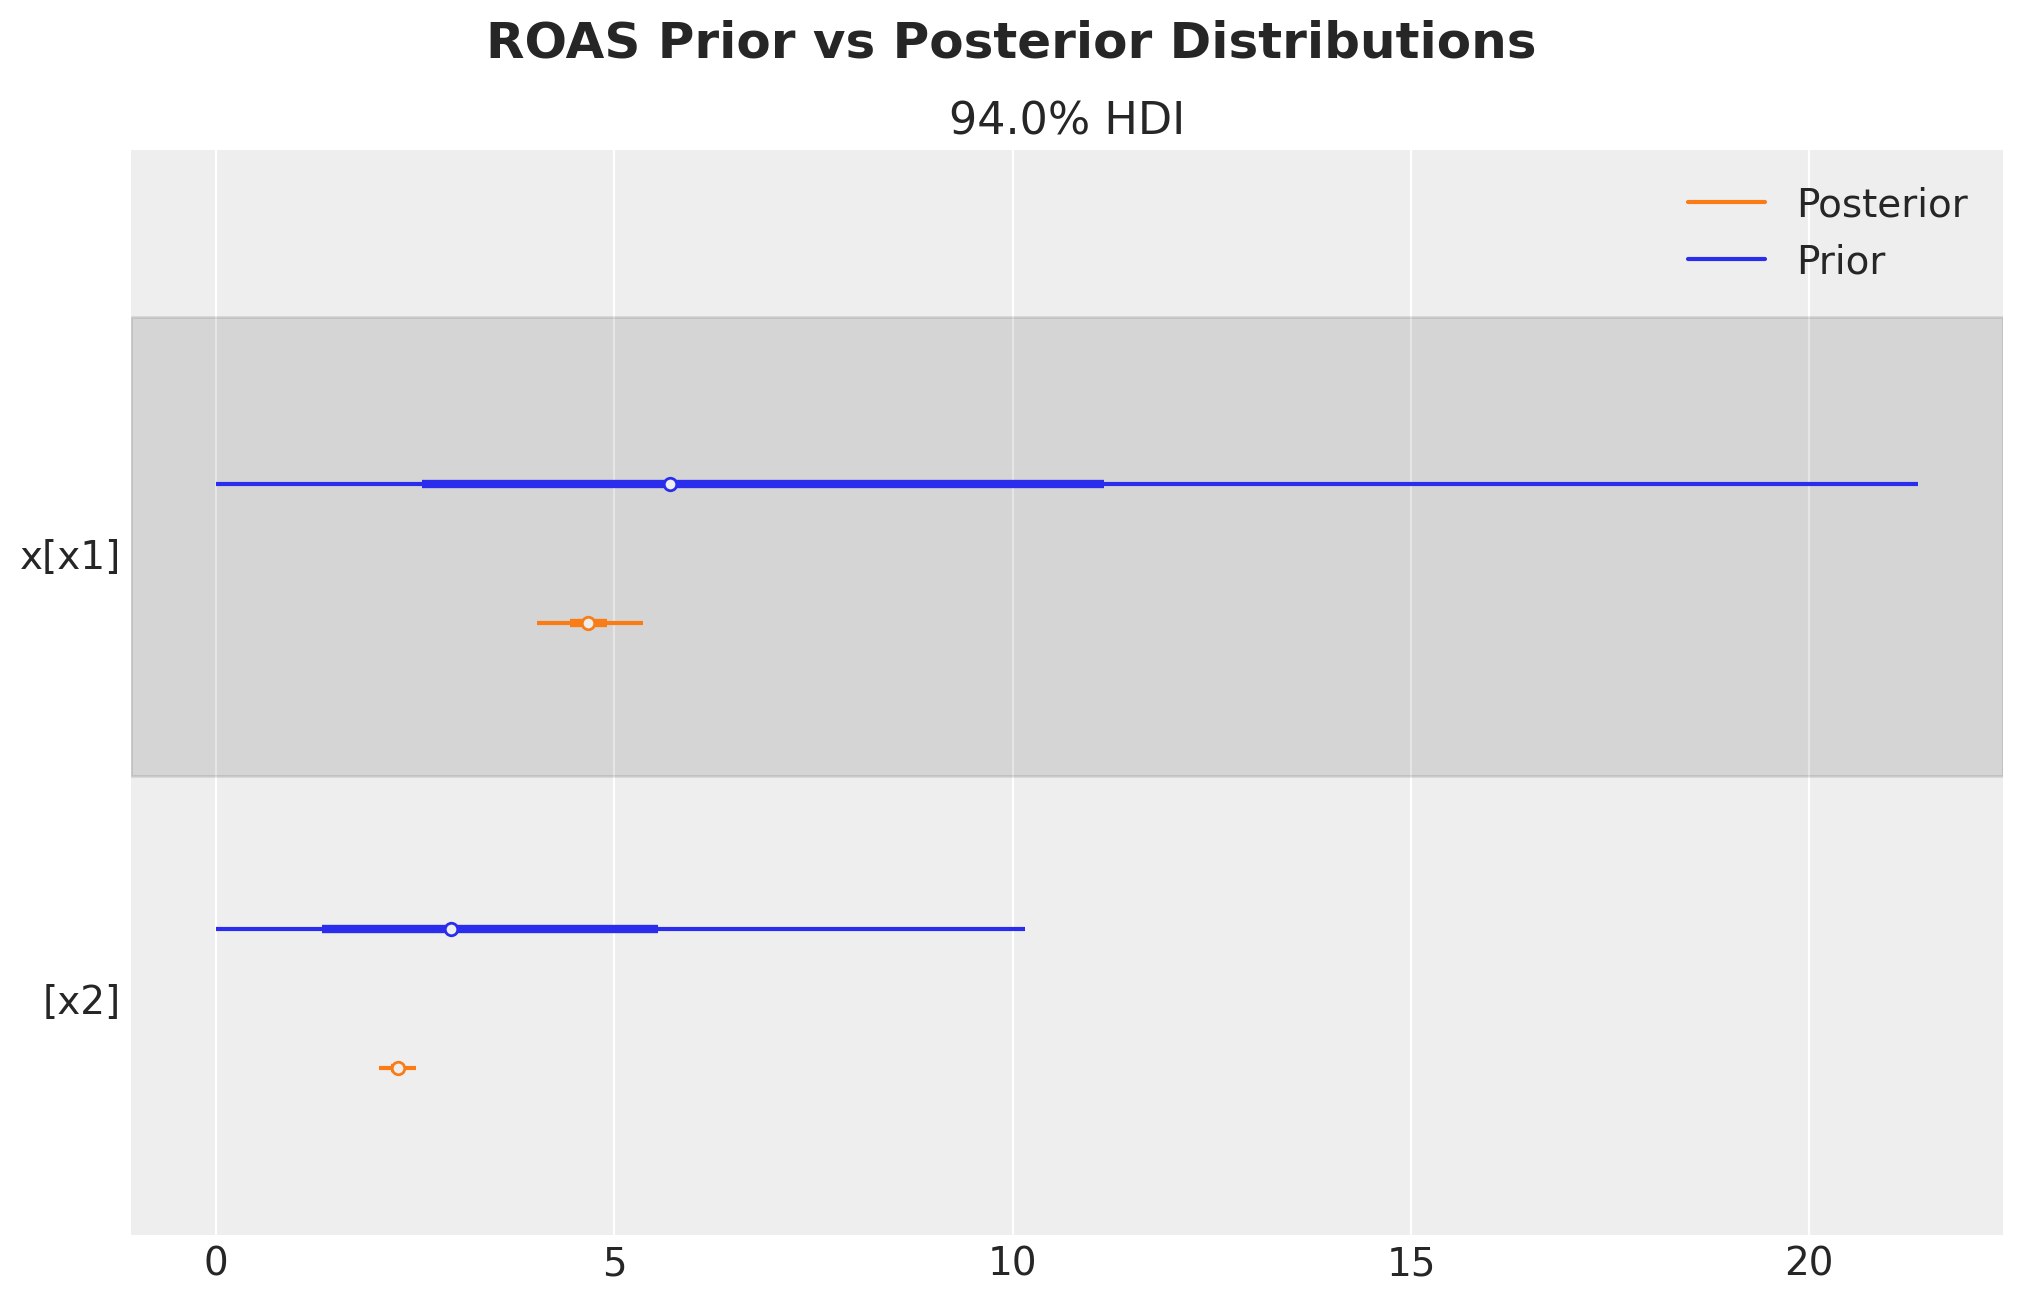

In [39]:
axes = az.plot_forest(
    data=[prior_roas_samples, roas_samples],
    model_names=["Prior", "Posterior"],
    combined=True,
    figsize=(10, 6),
)

fig = plt.gcf()
fig.suptitle(
    "ROAS Prior vs Posterior Distributions", fontsize=18, fontweight="bold", y=1.06
);

We clearly see how the data has shrunk the prior distribution to have a finer posterior estimate. 


```{tip}
We can use lift tests to calibrate our model in PyMC-Marketing using an additional calibration likelihood as explained in {ref}`mmm_lift_test`. This way we do not need to "guess" the media parameters to constrain the model to match the expected range from lift tests. 

An alternative approach is to parametrize the model using the ROAS directly, as suggested in ["Media Mix Model Calibration With Bayesian Priors"](https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/). Please find more details on these approaches in the example notebook {ref}`mmm_roas`.
```

---

## Key Takeaways

1. Prior predictive modeling helps us validate our model assumptions before using real data
2. The {class}`Prior <pymc_marketing.prior.prior.Prior>` class provides a convenient interface for:
   - Creating and visualizing prior distributions
   - Sampling from prior predictive distributions
3. Always visualize your prior predictive distributions to ensure they align with your domain knowledge

## Common Pitfalls and Best Practices

1. **Always Check Your Scales**
   - Make sure your priors are on the right scale for your data
   - Use domain knowledge to set reasonable bounds

2. **Constraint Considerations**
   - Use constraints when you have clear bounds (e.g., rates between 0 and 1)
   - Be careful not to over-constrain your priors

3. **Visualization is Key**
   - Always plot your prior distributions
   - Check prior predictive samples against domain knowledge

```{tip}
The main takeaway from this notebook is that prior predictive checks are a fundamental component of the modeling workflow and it should **never** be skipped. Observe that the prior predictive analysis enables the modeler to model even without using data. This is a great superpower to use simulations to challenge the model assumptions.
```


In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Thu Jan 09 2025

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

pymc_marketing: 0.10.0
pytensor      : 2.26.4

arviz         : 0.20.0
seaborn       : 0.13.2
preliz        : 0.15.0
pandas        : 2.2.3
pymc          : 5.20.0
pymc_marketing: 0.10.0
matplotlib    : 3.10.0
numpy         : 1.26.4

Watermark: 2.5.0

